In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [51]:
# fix random seed for reproducibility
np.random.seed(7)

# Import Data

In [152]:
# load the dataset
dataframe2 = pd.read_csv('TSLA_and_sentiment.csv') 
dataframe = pd.read_csv('TSLA_and_sentiment_lagged.csv')

In [153]:
dataframe = dataframe.rename(columns={'Index':'Date'})
dataframe = dataframe.set_index('Date')
dataframe.head(5)

,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,is_holiday,is_Sun,is_Mon,is_Tue,is_Wed,...,is_holiday_tm5,is_holiday_tm6,is_holiday_tm7,is_holiday_tp1,is_holiday_tp2,is_holiday_tp3,is_holiday_tp4,is_holiday_tp5,is_holiday_tp6,is_holiday_tp7
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-29,38.10,38.44,37.13,37.95,1426600,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-30,37.85,38.00,37.43,37.52,968100,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2013-01-31,37.87,37.87,36.93,37.51,901400,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-02-01,38.17,38.50,37.62,38.30,1100600,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-02-02,38.17,38.50,37.62,38.30,1100600,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
column_list = list(dataframe2.columns)
lag_column_list = list(dataframe.columns)
lag_column_list

['Adj_Open',
 'Adj_High',
 'Adj_Low',
 'Adj_Close',
 'Adj_Volume',
 'is_holiday',
 'is_Sun',
 'is_Mon',
 'is_Tue',
 'is_Wed',
 'is_Thu',
 'is_Fri',
 'is_Sat',
 'sentiment',
 'sentiment_high',
 'sentiment_low',
 'news_volume',
 'news_buzz',
 'Direction',
 'Adj_Close_tm1',
 'Adj_Close_tm2',
 'Adj_Close_tm3',
 'Adj_Close_tm4',
 'Adj_Close_tm5',
 'Adj_Close_tm6',
 'Adj_Close_tm7',
 'Adj_Close_tm8',
 'Adj_Close_tm9',
 'Adj_Close_tm10',
 'Adj_Close_tm11',
 'Adj_Close_tm12',
 'Adj_Close_tm13',
 'Adj_Close_tm14',
 'Adj_Close_tm15',
 'Adj_Close_tm16',
 'Adj_Close_tm17',
 'Adj_Close_tm18',
 'Adj_Close_tm19',
 'Adj_Close_tm20',
 'Adj_Close_tm21',
 'Adj_Close_tm22',
 'Adj_Close_tm23',
 'Adj_Close_tm24',
 'Adj_Close_tm25',
 'Adj_Close_tm26',
 'Adj_Close_tm27',
 'Adj_Close_tm28',
 'Adj_Open_tm1',
 'Adj_Open_tm2',
 'Adj_Open_tm3',
 'Adj_Open_tm4',
 'Adj_Open_tm5',
 'Adj_Open_tm6',
 'Adj_Open_tm7',
 'Adj_Open_tm8',
 'Adj_Open_tm9',
 'Adj_Open_tm10',
 'Adj_Open_tm11',
 'Adj_Open_tm12',
 'Adj_Open_tm13'

In [155]:
no_sentiment_column_list = list(filter(lambda x: not (x.startswith('news') or x.startswith('sentiment')), column_list))
no_sentiment_lag_column_list = list(filter(lambda x: not (x.startswith('news') or x.startswith('sentiment')), lag_column_list))

In [156]:
y_close = dataframe['Adj_Close'].values
y_direction = dataframe['Direction'].values

In [157]:
drop_columns = [
    'Adj_High',
    'Adj_Low',
    'Adj_Close',
    'Adj_Volume',
    'sentiment',
    'sentiment_high',
    'sentiment_low',
    'news_volume',
    'news_buzz',
    'Direction']
len(drop_columns)

10

In [99]:
'Adj_Close_tm11'[-3:]

'm11'

In [158]:
import re

In [105]:
bool(re.search(r'is_\w+','is_Close_tm11'))

True

In [113]:
list(filter(lambda x: bool(re.search(r'is_([A-Z]|[a-z])+$',x)), dataframe.columns))

['is_holiday',
 'is_Sun',
 'is_Mon',
 'is_Tue',
 'is_Wed',
 'is_Thu',
 'is_Fri',
 'is_Sat']

In [159]:
import re
adj_close_columns = list(filter(lambda x: x.find('Adj_Close') > -1, dataframe.columns))
tm1_columns = list(filter(lambda x: x[-3:].find('tm1') > -1, dataframe.columns))
tm2_columns = list(filter(lambda x: x[-3:].find('tm2') > -1, dataframe.columns))
is_columns = list(filter(lambda x: bool(re.search(r'is_([A-Z]|[a-z])+$',x)), dataframe.columns))
keep_columns = list(set(tm1_columns + tm2_columns + is_columns))
keep_columns

['Adj_Volume_tm1',
 'is_Thu',
 'news_buzz_tm1',
 'Adj_Open_tm2',
 'is_Mon',
 'Adj_Open_tm1',
 'is_Tue',
 'Adj_Low_tm2',
 'Direction_tm1',
 'Adj_Volume_tm2',
 'Adj_Close_tm2',
 'is_Sat',
 'news_volume_tm1',
 'Adj_High_tm2',
 'sentiment_tm1',
 'is_holiday_tm1',
 'sentiment_tm2',
 'Direction_tm2',
 'is_Sun',
 'is_holiday_tm2',
 'news_volume_tm2',
 'is_Wed',
 'sentiment_high_tm1',
 'Adj_Close_tm1',
 'Adj_Low_tm1',
 'is_holiday',
 'sentiment_high_tm2',
 'sentiment_low_tm2',
 'news_buzz_tm2',
 'sentiment_low_tm1',
 'Adj_High_tm1',
 'is_Fri']

In [160]:
dataframe.shape

(2268, 201)

In [10]:
dataframe.drop(drop_columns, axis=1, inplace=True)
dataframe.shape

(2268, 191)

In [168]:
dataframe = dataframe[keep_columns]

In [169]:
dataframe.drop('Adj_Close', axis=1, inplace=True)

KeyError: "['Adj_Close'] not found in axis"

# Naive Model

In [170]:
dataframe.columns

Index(['Adj_Volume_tm1', 'is_Thu', 'news_buzz_tm1', 'Adj_Open_tm2', 'is_Mon',
       'Adj_Open_tm1', 'is_Tue', 'Adj_Low_tm2', 'Direction_tm1',
       'Adj_Volume_tm2', 'Adj_Close_tm2', 'is_Sat', 'news_volume_tm1',
       'Adj_High_tm2', 'sentiment_tm1', 'is_holiday_tm1', 'sentiment_tm2',
       'Direction_tm2', 'is_Sun', 'is_holiday_tm2', 'news_volume_tm2',
       'is_Wed', 'sentiment_high_tm1', 'Adj_Close_tm1', 'Adj_Low_tm1',
       'is_holiday', 'sentiment_high_tm2', 'sentiment_low_tm2',
       'news_buzz_tm2', 'sentiment_low_tm1', 'Adj_High_tm1', 'is_Fri'],
      dtype='object')

In [12]:
pred_closing = dataframe[['Adj_Close_tm1']].values
pred_direction = dataframe[['Direction_tm1']].values

In [13]:
pred_closing = pred_closing.reshape(len(pred_closing))
pred_direction = pred_direction.reshape(len(pred_direction))

### Price: Mean Average Error

In [14]:
np.mean(abs(pred_closing - y_close))

3.3900661375661376

### Direction: Accuracy

In [15]:
correct = 0
for idx, pred in enumerate(pred_closing):
    if pred == y_close[idx]:
        correct += 1
accuracy = correct/len(pred_closing)
accuracy

0.31128747795414463

# Scaling & Test-Train Split

In [81]:
dataframe[list(filter(lambda x: x not in drop_columns, no_sentiment_lag_column_list))]

KeyError: "['Adj_Open' 'is_holiday' 'is_Sun' 'is_Mon' 'is_Tue' 'is_Wed' 'is_Thu'\n 'is_Fri' 'is_Sat' 'Adj_Open_tm2' 'Adj_Open_tm3' 'Adj_Open_tm4'\n 'Adj_Open_tm5' 'Adj_Open_tm6' 'Adj_Open_tm7' 'Adj_Open_tm8'\n 'Adj_Open_tm9' 'Adj_Open_tm10' 'Adj_Open_tm11' 'Adj_Open_tm12'\n 'Adj_Open_tm13' 'Adj_Open_tm14' 'Adj_High_tm2' 'Adj_High_tm3'\n 'Adj_High_tm4' 'Adj_High_tm5' 'Adj_High_tm6' 'Adj_High_tm7'\n 'Adj_High_tm8' 'Adj_High_tm9' 'Adj_High_tm10' 'Adj_High_tm11'\n 'Adj_High_tm12' 'Adj_High_tm13' 'Adj_High_tm14' 'Adj_Low_tm2'\n 'Adj_Low_tm3' 'Adj_Low_tm4' 'Adj_Low_tm5' 'Adj_Low_tm6' 'Adj_Low_tm7'\n 'Adj_Low_tm8' 'Adj_Low_tm9' 'Adj_Low_tm10' 'Adj_Low_tm11' 'Adj_Low_tm12'\n 'Adj_Low_tm13' 'Adj_Low_tm14' 'Adj_Volume_tm2' 'Adj_Volume_tm3'\n 'Adj_Volume_tm4' 'Adj_Volume_tm5' 'Adj_Volume_tm6' 'Adj_Volume_tm7'\n 'Adj_Volume_tm8' 'Adj_Volume_tm9' 'Adj_Volume_tm10' 'Adj_Volume_tm11'\n 'Adj_Volume_tm12' 'Adj_Volume_tm13' 'Adj_Volume_tm14' 'Direction_tm2'\n 'Direction_tm3' 'Direction_tm4' 'Direction_tm5' 'Direction_tm6'\n 'Direction_tm7' 'Direction_tm8' 'Direction_tm9' 'Direction_tm10'\n 'Direction_tm11' 'Direction_tm12' 'Direction_tm13' 'Direction_tm14'\n 'is_holiday_tm2' 'is_holiday_tm3' 'is_holiday_tm4' 'is_holiday_tm5'\n 'is_holiday_tm6' 'is_holiday_tm7' 'is_holiday_tp1' 'is_holiday_tp2'\n 'is_holiday_tp3' 'is_holiday_tp4' 'is_holiday_tp5' 'is_holiday_tp6'\n 'is_holiday_tp7'] not in index"

In [171]:
raw_values_1 = dataframe.values
scaler_1 = MinMaxScaler(feature_range=(0, 1))
values_1 = scaler_1.fit_transform(raw_values_1)
X_sent = values_1
train_X_sent = values_1[:n_train_days,]
test_X_sent = values_1[n_train_days:,]
X_sent_lstm = X_sent.reshape((X_sent.shape[0],1,X_sent.shape[1]))
train_X_sent_lstm = train_X_sent.reshape((train_X_sent.shape[0],1,train_X_sent.shape[1]))
test_X_sent_lstm = test_X_sent.reshape((test_X_sent.shape[0],1,test_X_sent.shape[1]))

In [83]:
raw_values_1 = dataframe.values
raw_values_2 = dataframe[list(filter(lambda x: x not in drop_columns, no_sentiment_lag_column_list))].values

# normalize features
scaler_3 = scaler_2 = scaler_1 = MinMaxScaler(feature_range=(0, 1))
values_1 = scaler_1.fit_transform(raw_values_1)
# values_2 = scaler_1.fit_transform(raw_values_2)

n_test_days = 180
n_train_days = values_1.shape[0] - n_test_days

X_sent = values_1
X_no_sent = values_2
train_X_sent = values_1[:n_train_days,]
test_X_sent = values_1[n_train_days:,]
train_X_no_sent = values_2[:n_train_days,]
test_X_no_sent = values_2[n_train_days:,]

X_sent_lstm = X_sent.reshape((X_sent.shape[0],1,X_sent.shape[1]))
X_no_sent_lstm = X_no_sent.reshape((X_no_sent.shape[0],1,X_no_sent.shape[1]))
train_X_sent_lstm = train_X_sent.reshape((train_X_sent.shape[0],1,train_X_sent.shape[1]))
test_X_sent_lstm = test_X_sent.reshape((test_X_sent.shape[0],1,test_X_sent.shape[1]))
train_X_no_sent_lstm = train_X_no_sent.reshape((train_X_no_sent.shape[0],1,train_X_no_sent.shape[1]))
test_X_no_sent_lstm = test_X_no_sent.reshape((test_X_no_sent.shape[0],1,test_X_no_sent.shape[1]))

y_close = y_close
y_direction = y_direction
train_y_close = y_close[:n_train_days,]
train_y_direction = y_direction[:n_train_days,]
test_y_close = y_close[n_train_days:,]
test_y_direction = y_direction[n_train_days:,]

print(train_X_sent.shape,train_X_no_sent.shape, train_y_close.shape,train_y_direction.shape,test_X_sent.shape,test_X_no_sent.shape,test_y_close.shape,test_y_direction.shape)

KeyError: "['Adj_Open' 'is_holiday' 'is_Sun' 'is_Mon' 'is_Tue' 'is_Wed' 'is_Thu'\n 'is_Fri' 'is_Sat' 'Adj_Open_tm2' 'Adj_Open_tm3' 'Adj_Open_tm4'\n 'Adj_Open_tm5' 'Adj_Open_tm6' 'Adj_Open_tm7' 'Adj_Open_tm8'\n 'Adj_Open_tm9' 'Adj_Open_tm10' 'Adj_Open_tm11' 'Adj_Open_tm12'\n 'Adj_Open_tm13' 'Adj_Open_tm14' 'Adj_High_tm2' 'Adj_High_tm3'\n 'Adj_High_tm4' 'Adj_High_tm5' 'Adj_High_tm6' 'Adj_High_tm7'\n 'Adj_High_tm8' 'Adj_High_tm9' 'Adj_High_tm10' 'Adj_High_tm11'\n 'Adj_High_tm12' 'Adj_High_tm13' 'Adj_High_tm14' 'Adj_Low_tm2'\n 'Adj_Low_tm3' 'Adj_Low_tm4' 'Adj_Low_tm5' 'Adj_Low_tm6' 'Adj_Low_tm7'\n 'Adj_Low_tm8' 'Adj_Low_tm9' 'Adj_Low_tm10' 'Adj_Low_tm11' 'Adj_Low_tm12'\n 'Adj_Low_tm13' 'Adj_Low_tm14' 'Adj_Volume_tm2' 'Adj_Volume_tm3'\n 'Adj_Volume_tm4' 'Adj_Volume_tm5' 'Adj_Volume_tm6' 'Adj_Volume_tm7'\n 'Adj_Volume_tm8' 'Adj_Volume_tm9' 'Adj_Volume_tm10' 'Adj_Volume_tm11'\n 'Adj_Volume_tm12' 'Adj_Volume_tm13' 'Adj_Volume_tm14' 'Direction_tm2'\n 'Direction_tm3' 'Direction_tm4' 'Direction_tm5' 'Direction_tm6'\n 'Direction_tm7' 'Direction_tm8' 'Direction_tm9' 'Direction_tm10'\n 'Direction_tm11' 'Direction_tm12' 'Direction_tm13' 'Direction_tm14'\n 'is_holiday_tm2' 'is_holiday_tm3' 'is_holiday_tm4' 'is_holiday_tm5'\n 'is_holiday_tm6' 'is_holiday_tm7' 'is_holiday_tp1' 'is_holiday_tp2'\n 'is_holiday_tp3' 'is_holiday_tp4' 'is_holiday_tp5' 'is_holiday_tp6'\n 'is_holiday_tp7'] not in index"

In [18]:
print(X_sent.shape,X_no_sent.shape,y_direction.shape,y_close.shape)

(2268, 191) (2268, 121) (2268,) (2268,)


In [19]:
print(X_sent_lstm.shape,X_no_sent_lstm.shape,y_direction.shape,y_close.shape)

(2268, 1, 191) (2268, 1, 121) (2268,) (2268,)


In [20]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
rs_y_direction = y_direction.reshape(len(y_direction),1)
rs_y_direction_train = train_y_direction.reshape(len(train_y_direction),1)
rs_y_direction_test = test_y_direction.reshape(len(test_y_direction),1)
enc.fit(rs_y_direction)
oh_y_direction = enc.transform(rs_y_direction).toarray()
enc.fit(rs_y_direction_train)
oh_y_direction_train = enc.transform(rs_y_direction_train).toarray()
enc.fit(rs_y_direction_test)
oh_y_direction_test = enc.transform(rs_y_direction_test).toarray()
oh_y_direction

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [21]:
y_close

array([ 37.95,  37.52,  37.51, ..., 267.7 , 267.7 , 266.38])

# MLP Grid Search

In [22]:
cv = [(list(range(n_train_days)),list(range(n_train_days,n_train_days+n_test_days)))]
cv

[([0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135,
   136,
   137,
   138

In [23]:
def build_model(neurons,layers,dropout_rate):
    num_inputs=X_no_sent.shape[1]
    num_outputs=1
    num_layers=layers
    num_neurons=neurons
    model = Sequential()
    model.add(Dense(num_neurons,activation='sigmoid',input_dim=num_inputs))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(num_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs))
    model.compile(loss='mae',optimizer='adam',metrics=['mape'])
    return model

def print_result(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

### Parameter Space

In [24]:
dropout_rate_space = np.linspace(0,.5,num=3).tolist()
neuron_space = np.linspace(10,190,num=5).astype(np.int32).tolist() # 5
layer_space = np.linspace(1,3,num=3).astype(np.int32).tolist() # 5

In [176]:
dropout_rate_space

[0.0, 0.25, 0.5]

In [25]:
neuron_space

[10, 55, 100, 145, 190]

In [177]:
layer_space

[1, 2, 3]

In [178]:
dense_neuron_space

[10, 80, 150]

In [179]:
lstm_neuron_space

[50, 100, 200]

In [ ]:
model = Sequential()
model.add(Dense(50, input_dim=train_X_sent.shape[1]))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam',metrics=['mape'])
model.fit(train_X_sent,train_y_close, epochs=25, batch_size=72, validation_data=(test_X_sent, test_y_close), verbose=2, shuffle=False)

## No Sentiment

#### Price

In [30]:
model = KerasRegressor(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(neurons=neuron_space, layers=layer_space, dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_mlp_nsp = grid.fit(X_no_sent, y_close)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
2084/2084 [==============================] - 0s 146us/step - loss: 231.1869 - mean_absolute_percentage_error: 99.8317
Epoch 2/25
2084/2084 [==============================] - 0s 15us/step - loss: 230.2445 - mean_absolute_percentage_error: 99.3658
Epoch 3/25
2084/2084 [==============================] - 0s 13us/step - loss: 229.7546 - mean_absolute_percentage_error: 99.0988
Epoch 4/25
2084/2084 [==============================] - 0s 17us/step - loss: 229.4119 - mean_absolute_percentage_error: 98.9079
Epoch 5/25
2084/2084 [==============================] - 0s 15us/step - loss: 229.1269 - mean_absolute_percentage_error: 98.7472
Epoch 6/25
2084/2084 [==============================] - 0s 14us/step - loss: 228.8693 - mean_absolute_percentage_error: 98.6018
Epoch 7/25
2084/2084 [==============================] - 0s 15us/step - loss: 228.6263 - mean_absolute_percentag

Epoch 20/25
2084/2084 [==============================] - 0s 16us/step - loss: 136.0151 - mean_absolute_percentage_error: 56.5317
Epoch 21/25
2084/2084 [==============================] - 0s 16us/step - loss: 131.5883 - mean_absolute_percentage_error: 54.8100
Epoch 22/25
2084/2084 [==============================] - 0s 16us/step - loss: 127.2741 - mean_absolute_percentage_error: 53.1274
Epoch 23/25
2084/2084 [==============================] - 0s 15us/step - loss: 122.9688 - mean_absolute_percentage_error: 51.4218
Epoch 24/25
2084/2084 [==============================] - 0s 19us/step - loss: 118.5754 - mean_absolute_percentage_error: 49.6409
Epoch 25/25
2084/2084 [==============================] - 0s 8us/step
Epoch 1/25
2084/2084 [==============================] - 1s 255us/step - loss: 230.6724 - mean_absolute_percentage_error: 99.5049
Epoch 2/25
2084/2084 [==============================] - 0s 24us/step - loss: 230.2301 - mean_absolute_percentage_error: 99.2665
Epoch 3/25
2084/2084 [=======

2084/2084 [==============================] - 0s 17us/step - loss: 216.2713 - mean_absolute_percentage_error: 91.7328
Epoch 7/25
2084/2084 [==============================] - 0s 24us/step - loss: 214.4696 - mean_absolute_percentage_error: 90.7383
Epoch 8/25
2084/2084 [==============================] - 0s 40us/step - loss: 212.6897 - mean_absolute_percentage_error: 89.7605
Epoch 9/25
2084/2084 [==============================] - 0s 31us/step - loss: 210.8685 - mean_absolute_percentage_error: 88.7621
Epoch 10/25
2084/2084 [==============================] - 0s 27us/step - loss: 209.0799 - mean_absolute_percentage_error: 87.7771
Epoch 11/25
2084/2084 [==============================] - 0s 22us/step - loss: 207.3186 - mean_absolute_percentage_error: 86.8087
Epoch 12/25
2084/2084 [==============================] - 0s 13us/step - loss: 205.5745 - mean_absolute_percentage_error: 85.8505
Epoch 13/25
2084/2084 [==============================] - 0s 15us/step - loss: 203.8427 - mean_absolute_percentag

Epoch 18/25
2084/2084 [==============================] - 0s 35us/step - loss: 164.1660 - mean_absolute_percentage_error: 68.4751
Epoch 19/25
2084/2084 [==============================] - 0s 31us/step - loss: 160.9789 - mean_absolute_percentage_error: 67.3779
Epoch 20/25
2084/2084 [==============================] - 0s 32us/step - loss: 157.8285 - mean_absolute_percentage_error: 66.2992
Epoch 21/25
2084/2084 [==============================] - 0s 39us/step - loss: 154.6806 - mean_absolute_percentage_error: 65.2259
Epoch 22/25
2084/2084 [==============================] - 0s 25us/step - loss: 151.3963 - mean_absolute_percentage_error: 64.1059
Epoch 23/25
2084/2084 [==============================] - 0s 22us/step - loss: 148.0929 - mean_absolute_percentage_error: 62.9872
Epoch 24/25
2084/2084 [==============================] - 0s 20us/step - loss: 144.8796 - mean_absolute_percentage_error: 61.9087
Epoch 25/25
2084/2084 [==============================] - 0s 11us/step
Epoch 1/25
2084/2084 [=====

Epoch 4/25
2084/2084 [==============================] - 0s 24us/step - loss: 220.3535 - mean_absolute_percentage_error: 93.9441
Epoch 5/25
2084/2084 [==============================] - 0s 21us/step - loss: 218.5697 - mean_absolute_percentage_error: 92.9658
Epoch 6/25
2084/2084 [==============================] - 0s 21us/step - loss: 216.7556 - mean_absolute_percentage_error: 91.9752
Epoch 7/25
2084/2084 [==============================] - 0s 22us/step - loss: 214.9397 - mean_absolute_percentage_error: 90.9764
Epoch 8/25
2084/2084 [==============================] - 0s 17us/step - loss: 213.1726 - mean_absolute_percentage_error: 90.0050
Epoch 9/25
2084/2084 [==============================] - 0s 21us/step - loss: 211.4347 - mean_absolute_percentage_error: 89.0507
Epoch 10/25
2084/2084 [==============================] - 0s 18us/step - loss: 209.7158 - mean_absolute_percentage_error: 88.1075
Epoch 11/25
2084/2084 [==============================] - 0s 22us/step - loss: 208.0105 - mean_absolute_

2084/2084 [==============================] - 0s 16us/step - loss: 198.2169 - mean_absolute_percentage_error: 82.0612
Epoch 25/25
2084/2084 [==============================] - 0s 11us/step
Epoch 1/25
2084/2084 [==============================] - 1s 471us/step - loss: 229.1730 - mean_absolute_percentage_error: 99.0787
Epoch 2/25
2084/2084 [==============================] - 0s 24us/step - loss: 225.1376 - mean_absolute_percentage_error: 97.0191
Epoch 3/25
2084/2084 [==============================] - 0s 24us/step - loss: 222.4819 - mean_absolute_percentage_error: 95.5843
Epoch 4/25
2084/2084 [==============================] - 0s 19us/step - loss: 220.0908 - mean_absolute_percentage_error: 94.2907
Epoch 5/25
2084/2084 [==============================] - 0s 17us/step - loss: 217.9163 - mean_absolute_percentage_error: 93.1035
Epoch 6/25
2084/2084 [==============================] - 0s 17us/step - loss: 215.7647 - mean_absolute_percentage_error: 91.9552
Epoch 7/25
2084/2084 [======================

Epoch 22/25
2084/2084 [==============================] - 0s 20us/step - loss: 204.8295 - mean_absolute_percentage_error: 85.4043
Epoch 23/25
2084/2084 [==============================] - 0s 18us/step - loss: 203.5937 - mean_absolute_percentage_error: 84.7471
Epoch 24/25
2084/2084 [==============================] - 0s 18us/step - loss: 202.3174 - mean_absolute_percentage_error: 84.0599
Epoch 25/25
2084/2084 [==============================] - 0s 11us/step
Epoch 1/25
2084/2084 [==============================] - 1s 579us/step - loss: 230.1130 - mean_absolute_percentage_error: 99.6245
Epoch 2/25
2084/2084 [==============================] - 0s 25us/step - loss: 225.5938 - mean_absolute_percentage_error: 96.9869
Epoch 3/25
2084/2084 [==============================] - 0s 24us/step - loss: 223.3478 - mean_absolute_percentage_error: 95.6434
Epoch 4/25
2084/2084 [==============================] - 0s 28us/step - loss: 221.6252 - mean_absolute_percentage_error: 94.6846
Epoch 5/25
2084/2084 [========

2084/2084 [==============================] - 0s 47us/step - loss: 199.1475 - mean_absolute_percentage_error: 82.4510
Epoch 9/25
2084/2084 [==============================] - 0s 41us/step - loss: 195.6684 - mean_absolute_percentage_error: 80.5560
Epoch 10/25
2084/2084 [==============================] - 0s 35us/step - loss: 192.2187 - mean_absolute_percentage_error: 78.8436
Epoch 11/25
2084/2084 [==============================] - 0s 38us/step - loss: 189.1329 - mean_absolute_percentage_error: 77.4334
Epoch 12/25
2084/2084 [==============================] - 0s 42us/step - loss: 186.1131 - mean_absolute_percentage_error: 76.2644
Epoch 13/25
2084/2084 [==============================] - 0s 45us/step - loss: 183.3621 - mean_absolute_percentage_error: 75.2716
Epoch 14/25
2084/2084 [==============================] - 0s 37us/step - loss: 180.4347 - mean_absolute_percentage_error: 74.1704
Epoch 15/25
2084/2084 [==============================] - 0s 41us/step - loss: 177.5563 - mean_absolute_percent

Epoch 20/25
2084/2084 [==============================] - 0s 31us/step - loss: 206.9772 - mean_absolute_percentage_error: 86.5193
Epoch 21/25
2084/2084 [==============================] - 0s 25us/step - loss: 205.8596 - mean_absolute_percentage_error: 85.9666
Epoch 22/25
2084/2084 [==============================] - 0s 23us/step - loss: 205.0665 - mean_absolute_percentage_error: 85.4738
Epoch 23/25
2084/2084 [==============================] - 0s 28us/step - loss: 203.9123 - mean_absolute_percentage_error: 84.9416
Epoch 24/25
2084/2084 [==============================] - 0s 25us/step - loss: 202.9648 - mean_absolute_percentage_error: 84.3518
Epoch 25/25
2084/2084 [==============================] - 0s 15us/step
Epoch 1/25
2084/2084 [==============================] - 1s 694us/step - loss: 229.0231 - mean_absolute_percentage_error: 99.0319
Epoch 2/25
2084/2084 [==============================] - 0s 27us/step - loss: 224.6206 - mean_absolute_percentage_error: 96.3710
Epoch 3/25
2084/2084 [======

2084/2084 [==============================] - 0s 67us/step - loss: 206.2060 - mean_absolute_percentage_error: 86.3162
Epoch 7/25
2084/2084 [==============================] - 0s 44us/step - loss: 202.7838 - mean_absolute_percentage_error: 84.4377
Epoch 8/25
2084/2084 [==============================] - 0s 57us/step - loss: 199.4496 - mean_absolute_percentage_error: 82.6581
Epoch 9/25
2084/2084 [==============================] - 0s 50us/step - loss: 196.1551 - mean_absolute_percentage_error: 80.8325
Epoch 10/25
2084/2084 [==============================] - 0s 47us/step - loss: 192.9635 - mean_absolute_percentage_error: 79.1828
Epoch 11/25
2084/2084 [==============================] - 0s 48us/step - loss: 189.8312 - mean_absolute_percentage_error: 77.8039
Epoch 12/25
2084/2084 [==============================] - 0s 45us/step - loss: 186.9589 - mean_absolute_percentage_error: 76.6190
Epoch 13/25
2084/2084 [==============================] - 0s 56us/step - loss: 184.0277 - mean_absolute_percentag

Epoch 18/25
2084/2084 [==============================] - 0s 20us/step - loss: 207.5345 - mean_absolute_percentage_error: 87.1194
Epoch 19/25
2084/2084 [==============================] - 0s 23us/step - loss: 206.1168 - mean_absolute_percentage_error: 86.3226
Epoch 20/25
2084/2084 [==============================] - 0s 20us/step - loss: 205.0876 - mean_absolute_percentage_error: 85.8163
Epoch 21/25
2084/2084 [==============================] - 0s 18us/step - loss: 203.9334 - mean_absolute_percentage_error: 85.0693
Epoch 22/25
2084/2084 [==============================] - 0s 22us/step - loss: 202.4651 - mean_absolute_percentage_error: 84.2800
Epoch 23/25
2084/2084 [==============================] - 0s 21us/step - loss: 201.5832 - mean_absolute_percentage_error: 83.7978
Epoch 24/25
2084/2084 [==============================] - 0s 19us/step - loss: 200.5064 - mean_absolute_percentage_error: 83.2230
Epoch 25/25
2084/2084 [==============================] - 0s 13us/step
Epoch 1/25
2084/2084 [=====

2084/2084 [==============================] - 0s 32us/step - loss: 210.3996 - mean_absolute_percentage_error: 89.3800
Epoch 5/25
2084/2084 [==============================] - 0s 30us/step - loss: 205.9160 - mean_absolute_percentage_error: 86.9852
Epoch 6/25
2084/2084 [==============================] - 0s 41us/step - loss: 201.3754 - mean_absolute_percentage_error: 84.5077
Epoch 7/25
2084/2084 [==============================] - 0s 36us/step - loss: 196.7396 - mean_absolute_percentage_error: 82.0657
Epoch 8/25
2084/2084 [==============================] - 0s 33us/step - loss: 191.9541 - mean_absolute_percentage_error: 79.4016
Epoch 9/25
2084/2084 [==============================] - 0s 29us/step - loss: 187.0706 - mean_absolute_percentage_error: 76.8333
Epoch 10/25
2084/2084 [==============================] - 0s 32us/step - loss: 181.8315 - mean_absolute_percentage_error: 74.2679
Epoch 11/25
2084/2084 [==============================] - 0s 34us/step - loss: 176.9947 - mean_absolute_percentage_

2084/2084 [==============================] - 0s 34us/step - loss: 210.7206 - mean_absolute_percentage_error: 88.6348
Epoch 17/25
2084/2084 [==============================] - 0s 35us/step - loss: 209.7448 - mean_absolute_percentage_error: 88.0699
Epoch 18/25
2084/2084 [==============================] - 0s 24us/step - loss: 208.6537 - mean_absolute_percentage_error: 87.5591
Epoch 19/25
2084/2084 [==============================] - 0s 28us/step - loss: 207.3190 - mean_absolute_percentage_error: 86.7476
Epoch 20/25
2084/2084 [==============================] - 0s 27us/step - loss: 206.3233 - mean_absolute_percentage_error: 86.1747
Epoch 21/25
2084/2084 [==============================] - 0s 23us/step - loss: 205.0470 - mean_absolute_percentage_error: 85.5856
Epoch 22/25
2084/2084 [==============================] - 0s 27us/step - loss: 203.9909 - mean_absolute_percentage_error: 84.9368
Epoch 23/25
2084/2084 [==============================] - 0s 22us/step - loss: 203.0497 - mean_absolute_percen

2084/2084 [==============================] - 0s 29us/step - loss: 210.1575 - mean_absolute_percentage_error: 88.3766
Epoch 15/25
2084/2084 [==============================] - 0s 35us/step - loss: 208.8107 - mean_absolute_percentage_error: 87.5951
Epoch 16/25
2084/2084 [==============================] - 0s 34us/step - loss: 207.7123 - mean_absolute_percentage_error: 86.9803
Epoch 17/25
2084/2084 [==============================] - 0s 25us/step - loss: 206.3684 - mean_absolute_percentage_error: 86.2278
Epoch 18/25
2084/2084 [==============================] - 0s 24us/step - loss: 205.0915 - mean_absolute_percentage_error: 85.5369
Epoch 19/25
2084/2084 [==============================] - 0s 30us/step - loss: 203.7306 - mean_absolute_percentage_error: 84.7912
Epoch 20/25
2084/2084 [==============================] - 0s 35us/step - loss: 202.5995 - mean_absolute_percentage_error: 84.1849
Epoch 21/25
2084/2084 [==============================] - 0s 37us/step - loss: 201.4074 - mean_absolute_percen

In [31]:
print_result(layer_neuron_dropout_grid_result)

Best: -186.011539 using {'dropout_rate': 0.5, 'layers': 1, 'neurons': 190}
-306.090033 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 10}
-283.499570 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 55}
-247.141452 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 100}
-224.466531 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 145}
-186.042310 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 190}
-303.775964 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 10}
-283.289566 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 55}
-264.798593 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 100}
-244.049316 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 145}
-216.225986 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 190}
-307.215637 (0.000000) with: {'dropout_rate': 0.0, 'layers': 3, 'neurons': 10}
-279.419379 (0.000000) with: {'dropout_rate': 0.0,

#### Direction

In [41]:
def build_model(neurons,layers,dropout_rate):
    num_inputs=X_no_sent.shape[1]
    num_outputs=oh_y_direction.shape[1]
    num_layers=layers
    num_neurons=neurons
    model = Sequential()
    model.add(Dense(num_neurons,activation='sigmoid',input_dim=num_inputs))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(num_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

model = KerasClassifier(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(neurons=neuron_space, layers=layer_space, dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_mlp_nsd = grid.fit(X_no_sent, oh_y_direction)

Epoch 1/25
2084/2084 [==============================] - 2s 1ms/step - loss: 1.1175 - acc: 0.3522
Epoch 2/25
2084/2084 [==============================] - 0s 30us/step - loss: 1.0894 - acc: 0.3877
Epoch 3/25
2084/2084 [==============================] - 0s 36us/step - loss: 1.0761 - acc: 0.4391
Epoch 4/25
2084/2084 [==============================] - 0s 46us/step - loss: 1.0610 - acc: 0.4952
Epoch 5/25
2084/2084 [==============================] - 0s 32us/step - loss: 1.0432 - acc: 0.5317
Epoch 6/25
2084/2084 [==============================] - 0s 39us/step - loss: 1.0231 - acc: 0.5734
Epoch 7/25
2084/2084 [==============================] - 0s 34us/step - loss: 1.0008 - acc: 0.6104
Epoch 8/25
2084/2084 [==============================] - 0s 39us/step - loss: 0.9771 - acc: 0.6291
Epoch 9/25
2084/2084 [==============================] - 0s 35us/step - loss: 0.9522 - acc: 0.6464
Epoch 10/25
2084/2084 [==============================] - 0s 37us/step - loss: 0.9261 - acc: 0.6579
Epoch 11/25
2084/208

2084/2084 [==============================] - 0s 43us/step - loss: 0.6315 - acc: 0.6636
Epoch 10/25
2084/2084 [==============================] - 0s 36us/step - loss: 0.5806 - acc: 0.6689
Epoch 11/25
2084/2084 [==============================] - 0s 36us/step - loss: 0.5534 - acc: 0.6718
Epoch 12/25
2084/2084 [==============================] - 0s 35us/step - loss: 0.5349 - acc: 0.6756
Epoch 13/25
2084/2084 [==============================] - 0s 42us/step - loss: 0.5221 - acc: 0.6708
Epoch 14/25
2084/2084 [==============================] - 0s 45us/step - loss: 0.5131 - acc: 0.6727
Epoch 15/25
2084/2084 [==============================] - 0s 36us/step - loss: 0.5065 - acc: 0.6732
Epoch 16/25
2084/2084 [==============================] - 0s 39us/step - loss: 0.5016 - acc: 0.6742
Epoch 17/25
2084/2084 [==============================] - 0s 39us/step - loss: 0.4979 - acc: 0.6819
Epoch 18/25
2084/2084 [==============================] - 0s 37us/step - loss: 0.4950 - acc: 0.6838
Epoch 19/25
2084/2084 

2084/2084 [==============================] - 0s 51us/step - loss: 0.4841 - acc: 0.6675
Epoch 18/25
2084/2084 [==============================] - 0s 50us/step - loss: 0.4836 - acc: 0.6694
Epoch 19/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.4830 - acc: 0.6708
Epoch 20/25
2084/2084 [==============================] - 0s 42us/step - loss: 0.4826 - acc: 0.6708
Epoch 21/25
2084/2084 [==============================] - 0s 45us/step - loss: 0.4821 - acc: 0.6727
Epoch 22/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.4818 - acc: 0.6713
Epoch 23/25
2084/2084 [==============================] - 0s 47us/step - loss: 0.4814 - acc: 0.6727
Epoch 24/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.4810 - acc: 0.6727
Epoch 25/25
2084/2084 [==============================] - 0s 26us/step
Epoch 1/25
2084/2084 [==============================] - 3s 1ms/step - loss: 1.1136 - acc: 0.3479
Epoch 2/25
2084/2084 [==============================]

2084/2084 [==============================] - 0s 25us/step
Epoch 1/25
2084/2084 [==============================] - 3s 2ms/step - loss: 1.1435 - acc: 0.3738
Epoch 2/25
2084/2084 [==============================] - 0s 46us/step - loss: 1.0710 - acc: 0.4165
Epoch 3/25
2084/2084 [==============================] - 0s 48us/step - loss: 1.0026 - acc: 0.4962
Epoch 4/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.9421 - acc: 0.5557
Epoch 5/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.8862 - acc: 0.5960
Epoch 6/25
2084/2084 [==============================] - 0s 48us/step - loss: 0.8257 - acc: 0.6166
Epoch 7/25
2084/2084 [==============================] - 0s 47us/step - loss: 0.7754 - acc: 0.6473
Epoch 8/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.7211 - acc: 0.6406
Epoch 9/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.6819 - acc: 0.6555
Epoch 10/25
2084/2084 [==============================] - 0s 4

2084/2084 [==============================] - 0s 46us/step - loss: 1.1156 - acc: 0.3335
Epoch 8/25
2084/2084 [==============================] - 0s 45us/step - loss: 1.1155 - acc: 0.3316
Epoch 9/25
2084/2084 [==============================] - 0s 46us/step - loss: 1.1121 - acc: 0.3273
Epoch 10/25
2084/2084 [==============================] - 0s 44us/step - loss: 1.1040 - acc: 0.3445
Epoch 11/25
2084/2084 [==============================] - 0s 43us/step - loss: 1.1096 - acc: 0.3311
Epoch 12/25
2084/2084 [==============================] - 0s 44us/step - loss: 1.1018 - acc: 0.3460
Epoch 13/25
2084/2084 [==============================] - 0s 41us/step - loss: 1.1039 - acc: 0.3364
Epoch 14/25
2084/2084 [==============================] - 0s 49us/step - loss: 1.1044 - acc: 0.3378
Epoch 15/25
2084/2084 [==============================] - 0s 44us/step - loss: 1.0948 - acc: 0.3676
Epoch 16/25
2084/2084 [==============================] - 0s 39us/step - loss: 1.1005 - acc: 0.3589
Epoch 17/25
2084/2084 [=

2084/2084 [==============================] - 0s 54us/step - loss: 0.7911 - acc: 0.5940
Epoch 16/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.7724 - acc: 0.5984
Epoch 17/25
2084/2084 [==============================] - 0s 48us/step - loss: 0.7378 - acc: 0.6200
Epoch 18/25
2084/2084 [==============================] - 0s 48us/step - loss: 0.7085 - acc: 0.6132
Epoch 19/25
2084/2084 [==============================] - 0s 48us/step - loss: 0.6901 - acc: 0.6358
Epoch 20/25
2084/2084 [==============================] - 0s 49us/step - loss: 0.6671 - acc: 0.6377
Epoch 21/25
2084/2084 [==============================] - 0s 49us/step - loss: 0.6646 - acc: 0.6161
Epoch 22/25
2084/2084 [==============================] - 0s 42us/step - loss: 0.6430 - acc: 0.6315
Epoch 23/25
2084/2084 [==============================] - 0s 42us/step - loss: 0.6151 - acc: 0.6540
Epoch 24/25
2084/2084 [==============================] - 0s 42us/step - loss: 0.6170 - acc: 0.6425
Epoch 25/25
2084/2084 

2084/2084 [==============================] - 0s 68us/step - loss: 0.4965 - acc: 0.6727
Epoch 24/25
2084/2084 [==============================] - 0s 58us/step - loss: 0.4937 - acc: 0.6718
Epoch 25/25
2084/2084 [==============================] - 0s 39us/step
Epoch 1/25
2084/2084 [==============================] - 4s 2ms/step - loss: 1.2583 - acc: 0.3335
Epoch 2/25
2084/2084 [==============================] - 0s 64us/step - loss: 1.1538 - acc: 0.3532
Epoch 3/25
2084/2084 [==============================] - 0s 64us/step - loss: 1.1129 - acc: 0.3556
Epoch 4/25
2084/2084 [==============================] - 0s 67us/step - loss: 1.0917 - acc: 0.3752
Epoch 5/25
2084/2084 [==============================] - 0s 73us/step - loss: 1.0533 - acc: 0.4261
Epoch 6/25
2084/2084 [==============================] - 0s 62us/step - loss: 0.9890 - acc: 0.5038
Epoch 7/25
2084/2084 [==============================] - 0s 60us/step - loss: 0.8821 - acc: 0.5744
Epoch 8/25
2084/2084 [==============================] - 0s 

2084/2084 [==============================] - 0s 153us/step - loss: 1.0755 - acc: 0.4040
Epoch 6/25
2084/2084 [==============================] - 0s 97us/step - loss: 0.9491 - acc: 0.5441
Epoch 7/25
2084/2084 [==============================] - 0s 96us/step - loss: 0.6743 - acc: 0.6382
Epoch 8/25
2084/2084 [==============================] - 0s 89us/step - loss: 0.5523 - acc: 0.6492
Epoch 9/25
2084/2084 [==============================] - 0s 111us/step - loss: 0.5323 - acc: 0.6473
Epoch 10/25
2084/2084 [==============================] - 0s 101us/step - loss: 0.5204 - acc: 0.6612
Epoch 11/25
2084/2084 [==============================] - 0s 87us/step - loss: 0.5137 - acc: 0.6545
Epoch 12/25
2084/2084 [==============================] - 0s 79us/step - loss: 0.4941 - acc: 0.6718
Epoch 13/25
2084/2084 [==============================] - 0s 106us/step - loss: 0.4952 - acc: 0.6631
Epoch 14/25
2084/2084 [==============================] - 0s 117us/step - loss: 0.4952 - acc: 0.6483
Epoch 15/25
2084/2084

In [42]:
print_result(layer_neuron_dropout_grid_result)

Best: 0.694444 using {'dropout_rate': 0.5, 'layers': 3, 'neurons': 55}
0.644444 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 10}
0.622222 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 55}
0.633333 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 100}
0.622222 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 145}
0.638889 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 190}
0.638889 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 10}
0.633333 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 55}
0.627778 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 100}
0.638889 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 145}
0.661111 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 190}
0.661111 (0.000000) with: {'dropout_rate': 0.0, 'layers': 3, 'neurons': 10}
0.633333 (0.000000) with: {'dropout_rate': 0.0, 'layers': 3, 'neurons': 55}
0.588889 (0

## With Sentiment

### Price

In [26]:
Featuresdef build_model(neurons,layers,dropout_rate):
    num_inputs=X_sent.shape[1]
    num_outputs=1
    num_layers=layers
    num_neurons=neurons
    model = Sequential()
    model.add(Dense(num_neurons,activation='sigmoid',input_dim=num_inputs))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(num_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs))
    model.compile(loss='mae',optimizer='adam',metrics=['mape'])
    return model

model = KerasRegressor(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(neurons=neuron_space, layers=layer_space, dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_mlp_sp = grid.fit(X_sent, y_close)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
2084/2084 [==============================] - 2s 1ms/step - loss: 231.0363 - mean_absolute_percentage_error: 99.7868
Epoch 2/25
2084/2084 [==============================] - 0s 14us/step - loss: 229.9692 - mean_absolute_percentage_error: 99.1878
Epoch 3/25
2084/2084 [==============================] - 0s 15us/step - loss: 229.5731 - mean_absolute_percentage_error: 98.9376
Epoch 4/25
2084/2084 [==============================] - 0s 10us/step - loss: 229.2857 - mean_absolute_percentage_error: 98.7680
Epoch 5/25
2084/2084 [==============================] - 0s 10us/step - loss: 229.0332 - mean_absolute_percentage_error: 98.6213
Epoch 6/25
2084/2084 [==============================] - 0s 10us/step - loss: 228.7971 - mean_absolute_percentage_error: 98.4862
Epoch 7/25
2084/2084 [==============================] - 0s 10us/step - loss: 228.5697 - mean_absolute_percentage_

Epoch 20/25
2084/2084 [==============================] - 0s 15us/step - loss: 145.0880 - mean_absolute_percentage_error: 61.4017
Epoch 21/25
2084/2084 [==============================] - 0s 16us/step - loss: 141.1810 - mean_absolute_percentage_error: 59.9187
Epoch 22/25
2084/2084 [==============================] - 0s 17us/step - loss: 137.3441 - mean_absolute_percentage_error: 58.3819
Epoch 23/25
2084/2084 [==============================] - 0s 17us/step - loss: 133.5531 - mean_absolute_percentage_error: 56.7347
Epoch 24/25
2084/2084 [==============================] - 0s 16us/step - loss: 129.7048 - mean_absolute_percentage_error: 54.8752
Epoch 25/25
2084/2084 [==============================] - 0s 7us/step
Epoch 1/25
2084/2084 [==============================] - 0s 221us/step - loss: 230.6529 - mean_absolute_percentage_error: 99.4989
Epoch 2/25
2084/2084 [==============================] - 0s 11us/step - loss: 230.2078 - mean_absolute_percentage_error: 99.2477
Epoch 3/25
2084/2084 [=======

2084/2084 [==============================] - 0s 14us/step - loss: 216.3472 - mean_absolute_percentage_error: 91.7548
Epoch 7/25
2084/2084 [==============================] - 0s 20us/step - loss: 214.5427 - mean_absolute_percentage_error: 90.7625
Epoch 8/25
2084/2084 [==============================] - 0s 17us/step - loss: 212.7783 - mean_absolute_percentage_error: 89.7920
Epoch 9/25
2084/2084 [==============================] - 0s 14us/step - loss: 211.0338 - mean_absolute_percentage_error: 88.8353
Epoch 10/25
2084/2084 [==============================] - 0s 17us/step - loss: 209.2345 - mean_absolute_percentage_error: 87.8534
Epoch 11/25
2084/2084 [==============================] - 0s 15us/step - loss: 207.4518 - mean_absolute_percentage_error: 86.8731
Epoch 12/25
2084/2084 [==============================] - 0s 18us/step - loss: 205.6966 - mean_absolute_percentage_error: 85.9093
Epoch 13/25
2084/2084 [==============================] - 0s 15us/step - loss: 203.9582 - mean_absolute_percentag

2084/2084 [==============================] - 0s 17us/step - loss: 222.1858 - mean_absolute_percentage_error: 94.9586
Epoch 4/25
2084/2084 [==============================] - 0s 17us/step - loss: 220.3591 - mean_absolute_percentage_error: 93.9452
Epoch 5/25
2084/2084 [==============================] - 0s 18us/step - loss: 218.5791 - mean_absolute_percentage_error: 92.9695
Epoch 6/25
2084/2084 [==============================] - 0s 18us/step - loss: 216.7687 - mean_absolute_percentage_error: 91.9812
Epoch 7/25
2084/2084 [==============================] - 0s 19us/step - loss: 214.9518 - mean_absolute_percentage_error: 90.9824
Epoch 8/25
2084/2084 [==============================] - 0s 21us/step - loss: 213.1839 - mean_absolute_percentage_error: 90.0106
Epoch 9/25
2084/2084 [==============================] - 0s 16us/step - loss: 211.4457 - mean_absolute_percentage_error: 89.0563
Epoch 10/25
2084/2084 [==============================] - 0s 18us/step - loss: 209.7267 - mean_absolute_percentage_e

2084/2084 [==============================] - 0s 31us/step - loss: 176.0092 - mean_absolute_percentage_error: 72.5650
Epoch 16/25
2084/2084 [==============================] - 0s 25us/step - loss: 173.0076 - mean_absolute_percentage_error: 71.5289
Epoch 17/25
2084/2084 [==============================] - 0s 23us/step - loss: 170.0414 - mean_absolute_percentage_error: 70.5086
Epoch 18/25
2084/2084 [==============================] - 0s 28us/step - loss: 167.0800 - mean_absolute_percentage_error: 69.4905
Epoch 19/25
2084/2084 [==============================] - 0s 27us/step - loss: 164.0520 - mean_absolute_percentage_error: 68.4469
Epoch 20/25
2084/2084 [==============================] - 0s 32us/step - loss: 161.0537 - mean_absolute_percentage_error: 67.4192
Epoch 21/25
2084/2084 [==============================] - 0s 30us/step - loss: 158.0821 - mean_absolute_percentage_error: 66.4011
Epoch 22/25
2084/2084 [==============================] - 0s 28us/step - loss: 155.1383 - mean_absolute_percen

2084/2084 [==============================] - 0s 20us/step - loss: 190.6803 - mean_absolute_percentage_error: 78.1596
Epoch 10/25
2084/2084 [==============================] - 0s 20us/step - loss: 186.9866 - mean_absolute_percentage_error: 76.5487
Epoch 11/25
2084/2084 [==============================] - 0s 20us/step - loss: 183.4512 - mean_absolute_percentage_error: 75.1923
Epoch 12/25
2084/2084 [==============================] - 0s 19us/step - loss: 179.7973 - mean_absolute_percentage_error: 73.7790
Epoch 13/25
2084/2084 [==============================] - 0s 20us/step - loss: 176.2281 - mean_absolute_percentage_error: 72.4777
Epoch 14/25
2084/2084 [==============================] - 0s 19us/step - loss: 172.7199 - mean_absolute_percentage_error: 71.2256
Epoch 15/25
2084/2084 [==============================] - 0s 21us/step - loss: 169.1766 - mean_absolute_percentage_error: 70.0076
Epoch 16/25
2084/2084 [==============================] - 0s 20us/step - loss: 165.8022 - mean_absolute_percen

Epoch 21/25
2084/2084 [==============================] - 0s 16us/step - loss: 206.0300 - mean_absolute_percentage_error: 86.0244
Epoch 22/25
2084/2084 [==============================] - 0s 18us/step - loss: 204.8198 - mean_absolute_percentage_error: 85.3947
Epoch 23/25
2084/2084 [==============================] - 0s 19us/step - loss: 203.6070 - mean_absolute_percentage_error: 84.7443
Epoch 24/25
2084/2084 [==============================] - 0s 19us/step - loss: 202.4069 - mean_absolute_percentage_error: 84.1038
Epoch 25/25
2084/2084 [==============================] - 0s 8us/step
Epoch 1/25
2084/2084 [==============================] - 1s 471us/step - loss: 229.9454 - mean_absolute_percentage_error: 99.5528
Epoch 2/25
2084/2084 [==============================] - 0s 18us/step - loss: 225.4637 - mean_absolute_percentage_error: 96.8659
Epoch 3/25
2084/2084 [==============================] - 0s 20us/step - loss: 223.3259 - mean_absolute_percentage_error: 95.5896
Epoch 4/25
2084/2084 [========

2084/2084 [==============================] - 0s 33us/step - loss: 202.6244 - mean_absolute_percentage_error: 84.3522
Epoch 8/25
2084/2084 [==============================] - 0s 28us/step - loss: 199.3264 - mean_absolute_percentage_error: 82.5311
Epoch 9/25
2084/2084 [==============================] - 0s 27us/step - loss: 196.0077 - mean_absolute_percentage_error: 80.7175
Epoch 10/25
2084/2084 [==============================] - 0s 31us/step - loss: 192.6137 - mean_absolute_percentage_error: 79.0313
Epoch 11/25
2084/2084 [==============================] - 0s 28us/step - loss: 189.5255 - mean_absolute_percentage_error: 77.5998
Epoch 12/25
2084/2084 [==============================] - 0s 25us/step - loss: 186.4534 - mean_absolute_percentage_error: 76.3985
Epoch 13/25
2084/2084 [==============================] - 0s 27us/step - loss: 183.6525 - mean_absolute_percentage_error: 75.3844
Epoch 14/25
2084/2084 [==============================] - 0s 26us/step - loss: 180.6968 - mean_absolute_percenta

2084/2084 [==============================] - 0s 44us/step - loss: 213.1049 - mean_absolute_percentage_error: 90.0969
Epoch 5/25
2084/2084 [==============================] - 0s 38us/step - loss: 209.6786 - mean_absolute_percentage_error: 88.2253
Epoch 6/25
2084/2084 [==============================] - 0s 39us/step - loss: 206.2175 - mean_absolute_percentage_error: 86.3222
Epoch 7/25
2084/2084 [==============================] - 0s 40us/step - loss: 202.7948 - mean_absolute_percentage_error: 84.4434
Epoch 8/25
2084/2084 [==============================] - 0s 39us/step - loss: 199.4603 - mean_absolute_percentage_error: 82.6637
Epoch 9/25
2084/2084 [==============================] - 0s 39us/step - loss: 196.1658 - mean_absolute_percentage_error: 80.8380
Epoch 10/25
2084/2084 [==============================] - 0s 39us/step - loss: 192.9739 - mean_absolute_percentage_error: 79.1877
Epoch 11/25
2084/2084 [==============================] - 0s 40us/step - loss: 189.8391 - mean_absolute_percentage_

2084/2084 [==============================] - 0s 18us/step - loss: 211.0260 - mean_absolute_percentage_error: 88.8364
Epoch 17/25
2084/2084 [==============================] - 0s 18us/step - loss: 209.5777 - mean_absolute_percentage_error: 88.0609
Epoch 18/25
2084/2084 [==============================] - 0s 20us/step - loss: 208.6174 - mean_absolute_percentage_error: 87.4642
Epoch 19/25
2084/2084 [==============================] - 0s 19us/step - loss: 207.3188 - mean_absolute_percentage_error: 86.7379
Epoch 20/25
2084/2084 [==============================] - 0s 20us/step - loss: 206.3812 - mean_absolute_percentage_error: 86.2906
Epoch 21/25
2084/2084 [==============================] - 0s 18us/step - loss: 205.3036 - mean_absolute_percentage_error: 85.5940
Epoch 22/25
2084/2084 [==============================] - 0s 18us/step - loss: 203.9309 - mean_absolute_percentage_error: 84.8527
Epoch 23/25
2084/2084 [==============================] - 0s 19us/step - loss: 203.1499 - mean_absolute_percen

2084/2084 [==============================] - 0s 21us/step - loss: 213.0431 - mean_absolute_percentage_error: 89.8819
Epoch 15/25
2084/2084 [==============================] - 0s 21us/step - loss: 211.9532 - mean_absolute_percentage_error: 89.3257
Epoch 16/25
2084/2084 [==============================] - 0s 22us/step - loss: 210.7549 - mean_absolute_percentage_error: 88.6471
Epoch 17/25
2084/2084 [==============================] - 0s 21us/step - loss: 209.8042 - mean_absolute_percentage_error: 88.0931
Epoch 18/25
2084/2084 [==============================] - 0s 19us/step - loss: 208.7746 - mean_absolute_percentage_error: 87.6177
Epoch 19/25
2084/2084 [==============================] - 0s 20us/step - loss: 207.4251 - mean_absolute_percentage_error: 86.8025
Epoch 20/25
2084/2084 [==============================] - 0s 21us/step - loss: 206.4164 - mean_absolute_percentage_error: 86.2220
Epoch 21/25
2084/2084 [==============================] - 0s 21us/step - loss: 205.1332 - mean_absolute_percen

2084/2084 [==============================] - 0s 33us/step - loss: 215.4607 - mean_absolute_percentage_error: 91.2418
Epoch 11/25
2084/2084 [==============================] - 0s 25us/step - loss: 214.1034 - mean_absolute_percentage_error: 90.4168
Epoch 12/25
2084/2084 [==============================] - 0s 24us/step - loss: 212.8079 - mean_absolute_percentage_error: 89.7959
Epoch 13/25
2084/2084 [==============================] - 0s 23us/step - loss: 211.6330 - mean_absolute_percentage_error: 89.1457
Epoch 14/25
2084/2084 [==============================] - 0s 22us/step - loss: 210.1577 - mean_absolute_percentage_error: 88.3764
Epoch 15/25
2084/2084 [==============================] - 0s 24us/step - loss: 208.8088 - mean_absolute_percentage_error: 87.5934
Epoch 16/25
2084/2084 [==============================] - 0s 25us/step - loss: 207.7119 - mean_absolute_percentage_error: 86.9795
Epoch 17/25
2084/2084 [==============================] - 0s 26us/step - loss: 206.3688 - mean_absolute_percen

Epoch 22/25
2084/2084 [==============================] - 0s 39us/step - loss: 172.0035 - mean_absolute_percentage_error: 71.1766
Epoch 23/25
2084/2084 [==============================] - 0s 39us/step - loss: 169.9168 - mean_absolute_percentage_error: 70.4232
Epoch 24/25
2084/2084 [==============================] - 0s 43us/step - loss: 167.8295 - mean_absolute_percentage_error: 69.8828
Epoch 25/25
2084/2084 [==============================] - 0s 17us/step
Epoch 1/25
2084/2084 [==============================] - 2s 913us/step - loss: 225.8852 - mean_absolute_percentage_error: 97.7859
Epoch 2/25
2084/2084 [==============================] - 0s 41us/step - loss: 219.5442 - mean_absolute_percentage_error: 93.6469
Epoch 3/25
2084/2084 [==============================] - 0s 41us/step - loss: 215.9865 - mean_absolute_percentage_error: 91.6867
Epoch 4/25
2084/2084 [==============================] - 0s 41us/step - loss: 212.3830 - mean_absolute_percentage_error: 89.7224
Epoch 5/25
2084/2084 [========

In [27]:
print_result(layer_neuron_dropout_grid_result)

Best: -198.863449 using {'dropout_rate': 0.0, 'layers': 1, 'neurons': 190}
-306.163531 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 10}
-285.535806 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 55}
-254.747009 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 100}
-236.891870 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 145}
-198.863449 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 190}
-303.789917 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 10}
-283.258728 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 55}
-264.896494 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 100}
-245.030844 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 145}
-218.188687 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 190}
-307.217731 (0.000000) with: {'dropout_rate': 0.0, 'layers': 3, 'neurons': 10}
-279.400302 (0.000000) with: {'dropout_rate': 0.0,

### Direction

In [28]:
def build_model(neurons,layers,dropout_rate):
    num_inputs=X_sent.shape[1]
    num_outputs=oh_y_direction.shape[1]
    num_layers=layers
    num_neurons=neurons
    model = Sequential()
    model.add(Dense(num_neurons,activation='sigmoid',input_dim=num_inputs))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(num_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

model = KerasClassifier(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(neurons=neuron_space, layers=layer_space, dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_mlp_sd = grid.fit(X_sent, oh_y_direction)

Epoch 1/25
2084/2084 [==============================] - 2s 1ms/step - loss: 1.2616 - acc: 0.3105
Epoch 2/25
2084/2084 [==============================] - 0s 31us/step - loss: 1.1020 - acc: 0.3369
Epoch 3/25
2084/2084 [==============================] - 0s 29us/step - loss: 1.0931 - acc: 0.3680
Epoch 4/25
2084/2084 [==============================] - 0s 30us/step - loss: 1.0889 - acc: 0.3666
Epoch 5/25
2084/2084 [==============================] - 0s 30us/step - loss: 1.0839 - acc: 0.3767
Epoch 6/25
2084/2084 [==============================] - 0s 28us/step - loss: 1.0768 - acc: 0.4323
Epoch 7/25
2084/2084 [==============================] - 0s 35us/step - loss: 1.0663 - acc: 0.5571
Epoch 8/25
2084/2084 [==============================] - 0s 33us/step - loss: 1.0516 - acc: 0.6185
Epoch 9/25
2084/2084 [==============================] - 0s 31us/step - loss: 1.0334 - acc: 0.6502
Epoch 10/25
2084/2084 [==============================] - 0s 31us/step - loss: 1.0130 - acc: 0.6540
Epoch 11/25
2084/208

2084/2084 [==============================] - 0s 39us/step - loss: 0.5710 - acc: 0.6646
Epoch 10/25
2084/2084 [==============================] - 0s 33us/step - loss: 0.5549 - acc: 0.6737
Epoch 11/25
2084/2084 [==============================] - 0s 33us/step - loss: 0.5477 - acc: 0.6579
Epoch 12/25
2084/2084 [==============================] - 0s 25us/step - loss: 0.5240 - acc: 0.6703
Epoch 13/25
2084/2084 [==============================] - 0s 25us/step - loss: 0.5128 - acc: 0.6881
Epoch 14/25
2084/2084 [==============================] - 0s 25us/step - loss: 0.5061 - acc: 0.6881
Epoch 15/25
2084/2084 [==============================] - 0s 23us/step - loss: 0.5016 - acc: 0.6891
Epoch 16/25
2084/2084 [==============================] - 0s 24us/step - loss: 0.4982 - acc: 0.6905
Epoch 17/25
2084/2084 [==============================] - 0s 24us/step - loss: 0.4954 - acc: 0.6929
Epoch 18/25
2084/2084 [==============================] - 0s 24us/step - loss: 0.4931 - acc: 0.6939
Epoch 19/25
2084/2084 

2084/2084 [==============================] - 0s 32us/step - loss: 0.4880 - acc: 0.6689
Epoch 18/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.4871 - acc: 0.6694
Epoch 19/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.4864 - acc: 0.6665
Epoch 20/25
2084/2084 [==============================] - 0s 30us/step - loss: 0.4858 - acc: 0.6631
Epoch 21/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.4854 - acc: 0.6708
Epoch 22/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.4850 - acc: 0.6708
Epoch 23/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.4847 - acc: 0.6699
Epoch 24/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.4844 - acc: 0.6718
Epoch 25/25
2084/2084 [==============================] - 0s 17us/step
Epoch 1/25
2084/2084 [==============================] - 3s 1ms/step - loss: 1.1157 - acc: 0.3369
Epoch 2/25
2084/2084 [==============================]

2084/2084 [==============================] - 0s 18us/step
Epoch 1/25
2084/2084 [==============================] - 3s 1ms/step - loss: 1.1153 - acc: 0.3892
Epoch 2/25
2084/2084 [==============================] - 0s 31us/step - loss: 1.0523 - acc: 0.4309
Epoch 3/25
2084/2084 [==============================] - 0s 34us/step - loss: 0.9574 - acc: 0.5259
Epoch 4/25
2084/2084 [==============================] - 0s 34us/step - loss: 0.8854 - acc: 0.6012
Epoch 5/25
2084/2084 [==============================] - 0s 32us/step - loss: 0.8290 - acc: 0.6200
Epoch 6/25
2084/2084 [==============================] - 0s 34us/step - loss: 0.7727 - acc: 0.6363
Epoch 7/25
2084/2084 [==============================] - 0s 34us/step - loss: 0.7085 - acc: 0.6560
Epoch 8/25
2084/2084 [==============================] - 0s 33us/step - loss: 0.6740 - acc: 0.6353
Epoch 9/25
2084/2084 [==============================] - 0s 35us/step - loss: 0.6383 - acc: 0.6627
Epoch 10/25
2084/2084 [==============================] - 0s 3

2084/2084 [==============================] - 0s 30us/step - loss: 1.1242 - acc: 0.3249
Epoch 8/25
2084/2084 [==============================] - 0s 28us/step - loss: 1.1220 - acc: 0.3369
Epoch 9/25
2084/2084 [==============================] - 0s 29us/step - loss: 1.1211 - acc: 0.3498
Epoch 10/25
2084/2084 [==============================] - 0s 28us/step - loss: 1.1122 - acc: 0.3556
Epoch 11/25
2084/2084 [==============================] - 0s 28us/step - loss: 1.1091 - acc: 0.3450
Epoch 12/25
2084/2084 [==============================] - 0s 28us/step - loss: 1.1002 - acc: 0.3752
Epoch 13/25
2084/2084 [==============================] - 0s 26us/step - loss: 1.1091 - acc: 0.3508
Epoch 14/25
2084/2084 [==============================] - 0s 25us/step - loss: 1.1043 - acc: 0.3551
Epoch 15/25
2084/2084 [==============================] - 0s 29us/step - loss: 1.1005 - acc: 0.3594
Epoch 16/25
2084/2084 [==============================] - 0s 27us/step - loss: 1.0980 - acc: 0.3599
Epoch 17/25
2084/2084 [=

2084/2084 [==============================] - 0s 34us/step - loss: 0.7214 - acc: 0.6209
Epoch 16/25
2084/2084 [==============================] - 0s 29us/step - loss: 0.6991 - acc: 0.6147
Epoch 17/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.6796 - acc: 0.6276
Epoch 18/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.6543 - acc: 0.6387
Epoch 19/25
2084/2084 [==============================] - 0s 29us/step - loss: 0.6483 - acc: 0.6372
Epoch 20/25
2084/2084 [==============================] - 0s 30us/step - loss: 0.6371 - acc: 0.6291
Epoch 21/25
2084/2084 [==============================] - 0s 30us/step - loss: 0.6194 - acc: 0.6368
Epoch 22/25
2084/2084 [==============================] - 0s 30us/step - loss: 0.6136 - acc: 0.6468
Epoch 23/25
2084/2084 [==============================] - 0s 32us/step - loss: 0.5976 - acc: 0.6497
Epoch 24/25
2084/2084 [==============================] - 0s 31us/step - loss: 0.5931 - acc: 0.6478
Epoch 25/25
2084/2084 

2084/2084 [==============================] - 0s 43us/step - loss: 0.5013 - acc: 0.6646
Epoch 24/25
2084/2084 [==============================] - 0s 40us/step - loss: 0.4982 - acc: 0.6627
Epoch 25/25
2084/2084 [==============================] - 0s 21us/step
Epoch 1/25
2084/2084 [==============================] - 4s 2ms/step - loss: 1.2194 - acc: 0.3426
Epoch 2/25
2084/2084 [==============================] - 0s 44us/step - loss: 1.1495 - acc: 0.3426
Epoch 3/25
2084/2084 [==============================] - 0s 43us/step - loss: 1.0997 - acc: 0.3690
Epoch 4/25
2084/2084 [==============================] - 0s 45us/step - loss: 1.0662 - acc: 0.4333
Epoch 5/25
2084/2084 [==============================] - 0s 46us/step - loss: 1.0034 - acc: 0.4904
Epoch 6/25
2084/2084 [==============================] - 0s 46us/step - loss: 0.9002 - acc: 0.5744
Epoch 7/25
2084/2084 [==============================] - 0s 50us/step - loss: 0.7587 - acc: 0.6108
Epoch 8/25
2084/2084 [==============================] - 0s 

2084/2084 [==============================] - 0s 80us/step - loss: 1.0721 - acc: 0.4069
Epoch 6/25
2084/2084 [==============================] - 0s 81us/step - loss: 0.9364 - acc: 0.5341
Epoch 7/25
2084/2084 [==============================] - 0s 74us/step - loss: 0.6632 - acc: 0.6233
Epoch 8/25
2084/2084 [==============================] - 0s 78us/step - loss: 0.5663 - acc: 0.6276
Epoch 9/25
2084/2084 [==============================] - 0s 81us/step - loss: 0.5487 - acc: 0.6368
Epoch 10/25
2084/2084 [==============================] - 0s 79us/step - loss: 0.5665 - acc: 0.6320
Epoch 11/25
2084/2084 [==============================] - 0s 78us/step - loss: 0.5584 - acc: 0.6444
Epoch 12/25
2084/2084 [==============================] - 0s 77us/step - loss: 0.5217 - acc: 0.6550
Epoch 13/25
2084/2084 [==============================] - 0s 78us/step - loss: 0.5030 - acc: 0.6492
Epoch 14/25
2084/2084 [==============================] - 0s 79us/step - loss: 0.4981 - acc: 0.6569
Epoch 15/25
2084/2084 [===

In [29]:
print_result(layer_neuron_dropout_grid_result)

Best: 0.683333 using {'dropout_rate': 0.5, 'layers': 3, 'neurons': 100}
0.627778 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 10}
0.622222 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 55}
0.627778 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 100}
0.622222 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 145}
0.627778 (0.000000) with: {'dropout_rate': 0.0, 'layers': 1, 'neurons': 190}
0.655556 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 10}
0.638889 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 55}
0.605556 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 100}
0.605556 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 145}
0.627778 (0.000000) with: {'dropout_rate': 0.0, 'layers': 2, 'neurons': 190}
0.361111 (0.000000) with: {'dropout_rate': 0.0, 'layers': 3, 'neurons': 10}
0.633333 (0.000000) with: {'dropout_rate': 0.0, 'layers': 3, 'neurons': 55}
0.633333 (

# LSTM Grid Search

In [26]:
lstm_neuron_space = list([50,100,200])
dense_neuron_space = np.linspace(10,150,num=3).astype(np.int32).tolist() # 5

In [27]:
dense_neuron_space

[10, 80, 150]

### No Sentiment Price

In [33]:
def build_model(lstm_neurons,dense_neurons,layers,dropout_rate):
    num_outputs=1
    num_layers=layers
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(X_no_sent_lstm.shape[1], X_no_sent_lstm.shape[2]),return_sequences=False))
    model.add(Dense(dense_neurons,activation='sigmoid'))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(dense_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs))
    model.compile(loss='mae',optimizer='adam',metrics=['mape'])
    return model

model = KerasRegressor(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(lstm_neurons=lstm_neuron_space,dense_neurons=neuron_space,layers=layer_space,dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_lstm_nsp = grid.fit(X_no_sent_lstm, y_close)

Epoch 1/25
2084/2084 [==============================] - 5s 3ms/step - loss: 229.7614 - mean_absolute_percentage_error: 99.0978
Epoch 2/25
2084/2084 [==============================] - 0s 80us/step - loss: 228.3468 - mean_absolute_percentage_error: 98.3995
Epoch 3/25
2084/2084 [==============================] - 0s 92us/step - loss: 227.6635 - mean_absolute_percentage_error: 97.9927
Epoch 4/25
2084/2084 [==============================] - 0s 86us/step - loss: 227.2912 - mean_absolute_percentage_error: 97.7564
Epoch 5/25
2084/2084 [==============================] - 0s 89us/step - loss: 226.9880 - mean_absolute_percentage_error: 97.5669
Epoch 6/25
2084/2084 [==============================] - 0s 76us/step - loss: 226.7079 - mean_absolute_percentage_error: 97.3950
Epoch 7/25
2084/2084 [==============================] - 0s 78us/step - loss: 226.4403 - mean_absolute_percentage_error: 97.2333
Epoch 8/25
2084/2084 [==============================] - 0s 108us/step - loss: 226.1808 - mean_absolute_pe

2084/2084 [==============================] - 0s 96us/step - loss: 226.5570 - mean_absolute_percentage_error: 97.2236
Epoch 24/25
2084/2084 [==============================] - 0s 95us/step - loss: 226.3541 - mean_absolute_percentage_error: 97.1123
Epoch 25/25
2084/2084 [==============================] - 0s 43us/step
Epoch 1/25
2084/2084 [==============================] - 6s 3ms/step - loss: 229.6636 - mean_absolute_percentage_error: 98.9843
Epoch 2/25
2084/2084 [==============================] - 0s 156us/step - loss: 229.0639 - mean_absolute_percentage_error: 98.6435
Epoch 3/25
2084/2084 [==============================] - 0s 146us/step - loss: 228.6264 - mean_absolute_percentage_error: 98.3941
Epoch 4/25
2084/2084 [==============================] - 0s 140us/step - loss: 228.1942 - mean_absolute_percentage_error: 98.1524
Epoch 5/25
2084/2084 [==============================] - 0s 140us/step - loss: 227.7723 - mean_absolute_percentage_error: 97.9166
Epoch 6/25
2084/2084 [===================

2084/2084 [==============================] - 0s 84us/step - loss: 226.4939 - mean_absolute_percentage_error: 97.1786
Epoch 20/25
2084/2084 [==============================] - 0s 84us/step - loss: 226.2642 - mean_absolute_percentage_error: 97.0746
Epoch 21/25
2084/2084 [==============================] - 0s 81us/step - loss: 226.1675 - mean_absolute_percentage_error: 97.0096
Epoch 22/25
2084/2084 [==============================] - 0s 85us/step - loss: 225.9588 - mean_absolute_percentage_error: 96.9268
Epoch 23/25
2084/2084 [==============================] - 0s 80us/step - loss: 225.8012 - mean_absolute_percentage_error: 96.8112
Epoch 24/25
2084/2084 [==============================] - 0s 83us/step - loss: 225.5934 - mean_absolute_percentage_error: 96.6837
Epoch 25/25
2084/2084 [==============================] - 0s 44us/step
Epoch 1/25
2084/2084 [==============================] - 6s 3ms/step - loss: 230.2584 - mean_absolute_percentage_error: 99.4116
Epoch 2/25
2084/2084 [===================

2084/2084 [==============================] - 0s 176us/step - loss: 225.6084 - mean_absolute_percentage_error: 96.7056
Epoch 16/25
2084/2084 [==============================] - 0s 168us/step - loss: 225.3118 - mean_absolute_percentage_error: 96.5521
Epoch 17/25
2084/2084 [==============================] - 0s 152us/step - loss: 225.0585 - mean_absolute_percentage_error: 96.4069
Epoch 18/25
2084/2084 [==============================] - 0s 152us/step - loss: 224.8630 - mean_absolute_percentage_error: 96.2737
Epoch 19/25
2084/2084 [==============================] - 0s 148us/step - loss: 224.6147 - mean_absolute_percentage_error: 96.1661
Epoch 20/25
2084/2084 [==============================] - 0s 160us/step - loss: 224.2928 - mean_absolute_percentage_error: 95.9659
Epoch 21/25
2084/2084 [==============================] - 0s 221us/step - loss: 224.0180 - mean_absolute_percentage_error: 95.8304
Epoch 22/25
2084/2084 [==============================] - 0s 214us/step - loss: 223.8647 - mean_absolut

2084/2084 [==============================] - 0s 103us/step - loss: 226.6247 - mean_absolute_percentage_error: 97.2685
Epoch 13/25
2084/2084 [==============================] - 0s 121us/step - loss: 226.3445 - mean_absolute_percentage_error: 97.0799
Epoch 14/25
2084/2084 [==============================] - 0s 109us/step - loss: 226.0719 - mean_absolute_percentage_error: 96.9413
Epoch 15/25
2084/2084 [==============================] - 0s 102us/step - loss: 225.8795 - mean_absolute_percentage_error: 96.8704
Epoch 16/25
2084/2084 [==============================] - 0s 107us/step - loss: 225.7192 - mean_absolute_percentage_error: 96.8106
Epoch 17/25
2084/2084 [==============================] - 0s 96us/step - loss: 225.5990 - mean_absolute_percentage_error: 96.7081
Epoch 18/25
2084/2084 [==============================] - 0s 111us/step - loss: 225.3089 - mean_absolute_percentage_error: 96.5286
Epoch 19/25
2084/2084 [==============================] - 0s 106us/step - loss: 225.0532 - mean_absolute

2084/2084 [==============================] - 0s 87us/step - loss: 228.9975 - mean_absolute_percentage_error: 98.5537
Epoch 9/25
2084/2084 [==============================] - 0s 93us/step - loss: 228.5931 - mean_absolute_percentage_error: 98.3454
Epoch 10/25
2084/2084 [==============================] - 0s 84us/step - loss: 228.1775 - mean_absolute_percentage_error: 98.1197
Epoch 11/25
2084/2084 [==============================] - 0s 83us/step - loss: 227.7495 - mean_absolute_percentage_error: 97.8873
Epoch 12/25
2084/2084 [==============================] - 0s 94us/step - loss: 227.4224 - mean_absolute_percentage_error: 97.7120
Epoch 13/25
2084/2084 [==============================] - 0s 85us/step - loss: 227.0332 - mean_absolute_percentage_error: 97.5282
Epoch 14/25
2084/2084 [==============================] - 0s 92us/step - loss: 226.6774 - mean_absolute_percentage_error: 97.2953
Epoch 15/25
2084/2084 [==============================] - 0s 94us/step - loss: 226.2210 - mean_absolute_percent

2084/2084 [==============================] - 0s 175us/step - loss: 223.4790 - mean_absolute_percentage_error: 95.7473
Epoch 5/25
2084/2084 [==============================] - 0s 167us/step - loss: 222.3024 - mean_absolute_percentage_error: 95.0706
Epoch 6/25
2084/2084 [==============================] - 0s 156us/step - loss: 221.1582 - mean_absolute_percentage_error: 94.4177
Epoch 7/25
2084/2084 [==============================] - 0s 155us/step - loss: 220.0353 - mean_absolute_percentage_error: 93.7827
Epoch 8/25
2084/2084 [==============================] - 0s 159us/step - loss: 218.9269 - mean_absolute_percentage_error: 93.1606
Epoch 9/25
2084/2084 [==============================] - 0s 156us/step - loss: 217.8289 - mean_absolute_percentage_error: 92.5480
Epoch 10/25
2084/2084 [==============================] - 0s 165us/step - loss: 216.7387 - mean_absolute_percentage_error: 91.9425
Epoch 11/25
2084/2084 [==============================] - 0s 165us/step - loss: 215.6544 - mean_absolute_per

2084/2084 [==============================] - 0s 43us/step
Epoch 1/25
2084/2084 [==============================] - 11s 5ms/step - loss: 231.3239 - mean_absolute_percentage_error: 100.0175
Epoch 2/25
2084/2084 [==============================] - 0s 114us/step - loss: 228.7383 - mean_absolute_percentage_error: 98.5912
Epoch 3/25
2084/2084 [==============================] - 0s 118us/step - loss: 226.8736 - mean_absolute_percentage_error: 97.5062
Epoch 4/25
2084/2084 [==============================] - 0s 117us/step - loss: 225.4799 - mean_absolute_percentage_error: 96.7182
Epoch 5/25
2084/2084 [==============================] - 0s 120us/step - loss: 224.2334 - mean_absolute_percentage_error: 96.0268
Epoch 6/25
2084/2084 [==============================] - 0s 119us/step - loss: 223.0748 - mean_absolute_percentage_error: 95.3851
Epoch 7/25
2084/2084 [==============================] - 0s 114us/step - loss: 221.9589 - mean_absolute_percentage_error: 94.7725
Epoch 8/25
2084/2084 [=================

2084/2084 [==============================] - 0s 111us/step - loss: 211.4189 - mean_absolute_percentage_error: 89.0673
Epoch 13/25
2084/2084 [==============================] - 0s 110us/step - loss: 210.1029 - mean_absolute_percentage_error: 88.3549
Epoch 14/25
2084/2084 [==============================] - 0s 107us/step - loss: 208.7724 - mean_absolute_percentage_error: 87.6391
Epoch 15/25
2084/2084 [==============================] - 0s 100us/step - loss: 207.5199 - mean_absolute_percentage_error: 86.9164
Epoch 16/25
2084/2084 [==============================] - 0s 112us/step - loss: 206.1971 - mean_absolute_percentage_error: 86.2026
Epoch 17/25
2084/2084 [==============================] - 0s 108us/step - loss: 204.9195 - mean_absolute_percentage_error: 85.4597
Epoch 18/25
2084/2084 [==============================] - 0s 121us/step - loss: 203.6188 - mean_absolute_percentage_error: 84.7240
Epoch 19/25
2084/2084 [==============================] - 0s 112us/step - loss: 202.2959 - mean_absolut

2084/2084 [==============================] - 0s 160us/step - loss: 219.4201 - mean_absolute_percentage_error: 93.3934
Epoch 9/25
2084/2084 [==============================] - 0s 163us/step - loss: 218.3063 - mean_absolute_percentage_error: 92.7717
Epoch 10/25
2084/2084 [==============================] - 0s 163us/step - loss: 217.1725 - mean_absolute_percentage_error: 92.1627
Epoch 11/25
2084/2084 [==============================] - 0s 162us/step - loss: 216.0269 - mean_absolute_percentage_error: 91.5177
Epoch 12/25
2084/2084 [==============================] - 0s 162us/step - loss: 214.7368 - mean_absolute_percentage_error: 90.8056
Epoch 13/25
2084/2084 [==============================] - 0s 162us/step - loss: 213.4671 - mean_absolute_percentage_error: 90.0964
Epoch 14/25
2084/2084 [==============================] - 0s 163us/step - loss: 212.1859 - mean_absolute_percentage_error: 89.3847
Epoch 15/25
2084/2084 [==============================] - 0s 163us/step - loss: 210.9577 - mean_absolute

2084/2084 [==============================] - 0s 132us/step - loss: 224.3971 - mean_absolute_percentage_error: 96.2622
Epoch 5/25
2084/2084 [==============================] - 0s 126us/step - loss: 223.2978 - mean_absolute_percentage_error: 95.6482
Epoch 6/25
2084/2084 [==============================] - 0s 133us/step - loss: 222.2034 - mean_absolute_percentage_error: 95.0126
Epoch 7/25
2084/2084 [==============================] - 0s 118us/step - loss: 221.1489 - mean_absolute_percentage_error: 94.3913
Epoch 8/25
2084/2084 [==============================] - 0s 126us/step - loss: 220.0321 - mean_absolute_percentage_error: 93.8302
Epoch 9/25
2084/2084 [==============================] - 0s 130us/step - loss: 218.9306 - mean_absolute_percentage_error: 93.1940
Epoch 10/25
2084/2084 [==============================] - 0s 127us/step - loss: 217.7655 - mean_absolute_percentage_error: 92.5617
Epoch 11/25
2084/2084 [==============================] - 0s 134us/step - loss: 216.7296 - mean_absolute_per

2084/2084 [==============================] - 0s 87us/step
Epoch 1/25
2084/2084 [==============================] - 14s 7ms/step - loss: 229.0290 - mean_absolute_percentage_error: 98.7942
Epoch 2/25
2084/2084 [==============================] - 0s 103us/step - loss: 225.6495 - mean_absolute_percentage_error: 96.9452
Epoch 3/25
2084/2084 [==============================] - 0s 105us/step - loss: 223.2682 - mean_absolute_percentage_error: 95.5368
Epoch 4/25
2084/2084 [==============================] - 0s 104us/step - loss: 221.7556 - mean_absolute_percentage_error: 94.6662
Epoch 5/25
2084/2084 [==============================] - 0s 125us/step - loss: 220.4813 - mean_absolute_percentage_error: 93.9626
Epoch 6/25
2084/2084 [==============================] - 0s 122us/step - loss: 219.2026 - mean_absolute_percentage_error: 93.2488
Epoch 7/25
2084/2084 [==============================] - 0s 124us/step - loss: 218.1273 - mean_absolute_percentage_error: 92.6724
Epoch 8/25
2084/2084 [==================

2084/2084 [==============================] - 0s 169us/step - loss: 215.1780 - mean_absolute_percentage_error: 91.0586
Epoch 13/25
2084/2084 [==============================] - 0s 172us/step - loss: 214.0063 - mean_absolute_percentage_error: 90.4100
Epoch 14/25
2084/2084 [==============================] - 0s 169us/step - loss: 212.9939 - mean_absolute_percentage_error: 89.8936
Epoch 15/25
2084/2084 [==============================] - 0s 173us/step - loss: 211.9680 - mean_absolute_percentage_error: 89.2480
Epoch 16/25
2084/2084 [==============================] - 0s 169us/step - loss: 210.8273 - mean_absolute_percentage_error: 88.6404
Epoch 17/25
2084/2084 [==============================] - 0s 172us/step - loss: 209.6419 - mean_absolute_percentage_error: 88.0636
Epoch 18/25
2084/2084 [==============================] - 0s 172us/step - loss: 208.2988 - mean_absolute_percentage_error: 87.2505
Epoch 19/25
2084/2084 [==============================] - 0s 171us/step - loss: 207.2028 - mean_absolut

2084/2084 [==============================] - 0s 151us/step - loss: 212.4329 - mean_absolute_percentage_error: 89.6122
Epoch 9/25
2084/2084 [==============================] - 0s 128us/step - loss: 210.5337 - mean_absolute_percentage_error: 88.5741
Epoch 10/25
2084/2084 [==============================] - 0s 129us/step - loss: 208.5950 - mean_absolute_percentage_error: 87.5177
Epoch 11/25
2084/2084 [==============================] - 0s 132us/step - loss: 206.5627 - mean_absolute_percentage_error: 86.4073
Epoch 12/25
2084/2084 [==============================] - 0s 159us/step - loss: 204.5106 - mean_absolute_percentage_error: 85.2810
Epoch 13/25
2084/2084 [==============================] - 0s 137us/step - loss: 202.5149 - mean_absolute_percentage_error: 84.1830
Epoch 14/25
2084/2084 [==============================] - 0s 148us/step - loss: 200.5580 - mean_absolute_percentage_error: 83.1080
Epoch 15/25
2084/2084 [==============================] - 0s 135us/step - loss: 198.6028 - mean_absolute

2084/2084 [==============================] - 0s 115us/step - loss: 221.3986 - mean_absolute_percentage_error: 94.8508
Epoch 5/25
2084/2084 [==============================] - 0s 129us/step - loss: 219.2968 - mean_absolute_percentage_error: 93.6446
Epoch 6/25
2084/2084 [==============================] - 0s 123us/step - loss: 217.3514 - mean_absolute_percentage_error: 92.5417
Epoch 7/25
2084/2084 [==============================] - 0s 115us/step - loss: 215.3254 - mean_absolute_percentage_error: 91.3886
Epoch 8/25
2084/2084 [==============================] - 0s 123us/step - loss: 213.3385 - mean_absolute_percentage_error: 90.2671
Epoch 9/25
2084/2084 [==============================] - 0s 116us/step - loss: 211.4490 - mean_absolute_percentage_error: 89.1912 0s - loss: 167.7098 - mean_absolute_percentage_error: 86.1
Epoch 10/25
2084/2084 [==============================] - 0s 120us/step - loss: 209.4769 - mean_absolute_percentage_error: 88.1134
Epoch 11/25
2084/2084 [=========================

2084/2084 [==============================] - 0s 87us/step
Epoch 1/25
2084/2084 [==============================] - 17s 8ms/step - loss: 227.0091 - mean_absolute_percentage_error: 97.9625
Epoch 2/25
2084/2084 [==============================] - 0s 196us/step - loss: 221.7779 - mean_absolute_percentage_error: 94.9352
Epoch 3/25
2084/2084 [==============================] - 0s 210us/step - loss: 219.1473 - mean_absolute_percentage_error: 93.3468
Epoch 4/25
2084/2084 [==============================] - 0s 205us/step - loss: 216.8780 - mean_absolute_percentage_error: 92.0976
Epoch 5/25
2084/2084 [==============================] - 0s 194us/step - loss: 214.5849 - mean_absolute_percentage_error: 90.8161
Epoch 6/25
2084/2084 [==============================] - 0s 187us/step - loss: 212.3924 - mean_absolute_percentage_error: 89.6181
Epoch 7/25
2084/2084 [==============================] - 0s 186us/step - loss: 210.2515 - mean_absolute_percentage_error: 88.4809
Epoch 8/25
2084/2084 [==================

2084/2084 [==============================] - 0s 192us/step - loss: 204.0508 - mean_absolute_percentage_error: 84.9883
Epoch 13/25
2084/2084 [==============================] - 0s 166us/step - loss: 202.1532 - mean_absolute_percentage_error: 83.9411
Epoch 14/25
2084/2084 [==============================] - 0s 162us/step - loss: 200.1979 - mean_absolute_percentage_error: 82.9138
Epoch 15/25
2084/2084 [==============================] - 0s 182us/step - loss: 198.4249 - mean_absolute_percentage_error: 81.9831
Epoch 16/25
2084/2084 [==============================] - 0s 185us/step - loss: 196.5674 - mean_absolute_percentage_error: 80.9245
Epoch 17/25
2084/2084 [==============================] - 0s 176us/step - loss: 194.6976 - mean_absolute_percentage_error: 79.9878
Epoch 18/25
2084/2084 [==============================] - 0s 172us/step - loss: 192.9932 - mean_absolute_percentage_error: 79.1468
Epoch 19/25
2084/2084 [==============================] - 0s 156us/step - loss: 191.3373 - mean_absolut

2084/2084 [==============================] - 0s 138us/step - loss: 212.4828 - mean_absolute_percentage_error: 89.6901
Epoch 9/25
2084/2084 [==============================] - 0s 131us/step - loss: 210.7311 - mean_absolute_percentage_error: 88.6409
Epoch 10/25
2084/2084 [==============================] - 0s 140us/step - loss: 208.9195 - mean_absolute_percentage_error: 87.6790
Epoch 11/25
2084/2084 [==============================] - 0s 130us/step - loss: 207.1000 - mean_absolute_percentage_error: 86.6930
Epoch 12/25
2084/2084 [==============================] - 0s 136us/step - loss: 205.3464 - mean_absolute_percentage_error: 85.8071
Epoch 13/25
2084/2084 [==============================] - 0s 136us/step - loss: 203.4728 - mean_absolute_percentage_error: 84.7682
Epoch 14/25
2084/2084 [==============================] - 0s 133us/step - loss: 201.6875 - mean_absolute_percentage_error: 83.7747
Epoch 15/25
2084/2084 [==============================] - 0s 136us/step - loss: 199.8035 - mean_absolute

2084/2084 [==============================] - 0s 205us/step - loss: 221.3534 - mean_absolute_percentage_error: 94.4849
Epoch 5/25
2084/2084 [==============================] - 0s 209us/step - loss: 219.7517 - mean_absolute_percentage_error: 93.5918
Epoch 6/25
2084/2084 [==============================] - 0s 213us/step - loss: 218.1897 - mean_absolute_percentage_error: 92.7278
Epoch 7/25
2084/2084 [==============================] - 0s 209us/step - loss: 216.6788 - mean_absolute_percentage_error: 91.9140
Epoch 8/25
2084/2084 [==============================] - 0s 212us/step - loss: 214.9107 - mean_absolute_percentage_error: 90.9597
Epoch 9/25
2084/2084 [==============================] - 0s 215us/step - loss: 213.2465 - mean_absolute_percentage_error: 90.0117
Epoch 10/25
2084/2084 [==============================] - 0s 201us/step - loss: 211.5740 - mean_absolute_percentage_error: 89.0891
Epoch 11/25
2084/2084 [==============================] - 0s 209us/step - loss: 209.8577 - mean_absolute_per

2084/2084 [==============================] - 0s 99us/step
Epoch 1/25
2084/2084 [==============================] - 20s 9ms/step - loss: 227.0859 - mean_absolute_percentage_error: 98.1934
Epoch 2/25
2084/2084 [==============================] - 0s 159us/step - loss: 220.8540 - mean_absolute_percentage_error: 94.4408
Epoch 3/25
2084/2084 [==============================] - 0s 162us/step - loss: 217.7748 - mean_absolute_percentage_error: 92.6395
Epoch 4/25
2084/2084 [==============================] - 0s 158us/step - loss: 214.9735 - mean_absolute_percentage_error: 91.0828
Epoch 5/25
2084/2084 [==============================] - 0s 156us/step - loss: 212.2360 - mean_absolute_percentage_error: 89.5795
Epoch 6/25
2084/2084 [==============================] - 0s 157us/step - loss: 209.4478 - mean_absolute_percentage_error: 88.0505
Epoch 7/25
2084/2084 [==============================] - 0s 158us/step - loss: 206.6965 - mean_absolute_percentage_error: 86.5358
Epoch 8/25
2084/2084 [==================

2084/2084 [==============================] - 0s 146us/step - loss: 195.8781 - mean_absolute_percentage_error: 80.5787
Epoch 13/25
2084/2084 [==============================] - 0s 153us/step - loss: 193.5188 - mean_absolute_percentage_error: 79.3582
Epoch 14/25
2084/2084 [==============================] - 0s 154us/step - loss: 191.3032 - mean_absolute_percentage_error: 78.3498
Epoch 15/25
2084/2084 [==============================] - 0s 154us/step - loss: 189.1483 - mean_absolute_percentage_error: 77.4679
Epoch 16/25
2084/2084 [==============================] - 0s 153us/step - loss: 186.9607 - mean_absolute_percentage_error: 76.6048
Epoch 17/25
2084/2084 [==============================] - 0s 149us/step - loss: 184.8219 - mean_absolute_percentage_error: 75.7905
Epoch 18/25
2084/2084 [==============================] - 0s 154us/step - loss: 182.6576 - mean_absolute_percentage_error: 74.9791
Epoch 19/25
2084/2084 [==============================] - 0s 152us/step - loss: 180.4743 - mean_absolut

2084/2084 [==============================] - 0s 211us/step - loss: 204.8197 - mean_absolute_percentage_error: 85.5971
Epoch 9/25
2084/2084 [==============================] - 0s 217us/step - loss: 202.3078 - mean_absolute_percentage_error: 84.1999
Epoch 10/25
2084/2084 [==============================] - 0s 221us/step - loss: 199.6729 - mean_absolute_percentage_error: 82.7224
Epoch 11/25
2084/2084 [==============================] - 0s 218us/step - loss: 197.2439 - mean_absolute_percentage_error: 81.3974
Epoch 12/25
2084/2084 [==============================] - 0s 221us/step - loss: 194.6908 - mean_absolute_percentage_error: 80.0174
Epoch 13/25
2084/2084 [==============================] - 0s 209us/step - loss: 192.1433 - mean_absolute_percentage_error: 78.7916
Epoch 14/25
2084/2084 [==============================] - 0s 208us/step - loss: 189.9147 - mean_absolute_percentage_error: 77.7938
Epoch 15/25
2084/2084 [==============================] - 0s 213us/step - loss: 187.6268 - mean_absolute

2084/2084 [==============================] - 0s 172us/step - loss: 215.7872 - mean_absolute_percentage_error: 91.5011
Epoch 5/25
2084/2084 [==============================] - 0s 172us/step - loss: 213.2554 - mean_absolute_percentage_error: 90.1042
Epoch 6/25
2084/2084 [==============================] - 0s 170us/step - loss: 210.8024 - mean_absolute_percentage_error: 88.7847
Epoch 7/25
2084/2084 [==============================] - 0s 166us/step - loss: 208.2644 - mean_absolute_percentage_error: 87.3839
Epoch 8/25
2084/2084 [==============================] - 0s 176us/step - loss: 205.8839 - mean_absolute_percentage_error: 86.0511
Epoch 9/25
2084/2084 [==============================] - 0s 185us/step - loss: 203.2689 - mean_absolute_percentage_error: 84.6515
Epoch 10/25
2084/2084 [==============================] - 0s 172us/step - loss: 200.6102 - mean_absolute_percentage_error: 83.1883
Epoch 11/25
2084/2084 [==============================] - 0s 170us/step - loss: 198.0836 - mean_absolute_per

2084/2084 [==============================] - 0s 130us/step
Epoch 1/25
2084/2084 [==============================] - 25s 12ms/step - loss: 226.6662 - mean_absolute_percentage_error: 97.9453
Epoch 2/25
2084/2084 [==============================] - 0s 188us/step - loss: 219.9691 - mean_absolute_percentage_error: 93.9665
Epoch 3/25
2084/2084 [==============================] - 0s 163us/step - loss: 216.4958 - mean_absolute_percentage_error: 91.9939
Epoch 4/25
2084/2084 [==============================] - 0s 182us/step - loss: 213.3482 - mean_absolute_percentage_error: 90.2286
Epoch 5/25
2084/2084 [==============================] - 0s 172us/step - loss: 210.2121 - mean_absolute_percentage_error: 88.4939
Epoch 6/25
2084/2084 [==============================] - 0s 170us/step - loss: 207.1977 - mean_absolute_percentage_error: 86.8622
Epoch 7/25
2084/2084 [==============================] - 0s 177us/step - loss: 204.1991 - mean_absolute_percentage_error: 85.1597
Epoch 8/25
2084/2084 [================

Epoch 12/25
2084/2084 [==============================] - 0s 220us/step - loss: 193.6031 - mean_absolute_percentage_error: 79.5744
Epoch 13/25
2084/2084 [==============================] - 0s 218us/step - loss: 190.9666 - mean_absolute_percentage_error: 78.3085
Epoch 14/25
2084/2084 [==============================] - 0s 224us/step - loss: 188.6203 - mean_absolute_percentage_error: 77.3372
Epoch 15/25
2084/2084 [==============================] - 0s 217us/step - loss: 186.4185 - mean_absolute_percentage_error: 76.4360
Epoch 16/25
2084/2084 [==============================] - 0s 229us/step - loss: 183.9498 - mean_absolute_percentage_error: 75.5275
Epoch 17/25
2084/2084 [==============================] - 1s 243us/step - loss: 181.6421 - mean_absolute_percentage_error: 74.5362
Epoch 18/25
2084/2084 [==============================] - 0s 238us/step - loss: 179.3999 - mean_absolute_percentage_error: 73.7911
Epoch 19/25
2084/2084 [==============================] - 0s 237us/step - loss: 177.1164 - 

2084/2084 [==============================] - 0s 190us/step - loss: 195.4452 - mean_absolute_percentage_error: 80.6209
Epoch 9/25
2084/2084 [==============================] - 0s 176us/step - loss: 191.4631 - mean_absolute_percentage_error: 78.4574
Epoch 10/25
2084/2084 [==============================] - 0s 166us/step - loss: 187.8526 - mean_absolute_percentage_error: 76.8637
Epoch 11/25
2084/2084 [==============================] - 0s 166us/step - loss: 184.2931 - mean_absolute_percentage_error: 75.4587
Epoch 12/25
2084/2084 [==============================] - 0s 171us/step - loss: 180.7200 - mean_absolute_percentage_error: 74.0885
Epoch 13/25
2084/2084 [==============================] - 0s 170us/step - loss: 177.1905 - mean_absolute_percentage_error: 72.7569
Epoch 14/25
2084/2084 [==============================] - 0s 173us/step - loss: 173.7223 - mean_absolute_percentage_error: 71.4552
Epoch 15/25
2084/2084 [==============================] - 0s 176us/step - loss: 170.2985 - mean_absolute

2084/2084 [==============================] - 0s 173us/step - loss: 210.0143 - mean_absolute_percentage_error: 88.4213
Epoch 5/25
2084/2084 [==============================] - 0s 172us/step - loss: 206.3183 - mean_absolute_percentage_error: 86.3904
Epoch 6/25
2084/2084 [==============================] - 0s 170us/step - loss: 202.7026 - mean_absolute_percentage_error: 84.4039
Epoch 7/25
2084/2084 [==============================] - 0s 172us/step - loss: 199.1375 - mean_absolute_percentage_error: 82.4472
Epoch 8/25
2084/2084 [==============================] - 0s 172us/step - loss: 195.5731 - mean_absolute_percentage_error: 80.4972
Epoch 9/25
2084/2084 [==============================] - 0s 170us/step - loss: 192.1221 - mean_absolute_percentage_error: 78.7320
Epoch 10/25
2084/2084 [==============================] - 0s 173us/step - loss: 188.8470 - mean_absolute_percentage_error: 77.3520
Epoch 11/25
2084/2084 [==============================] - 0s 175us/step - loss: 185.6281 - mean_absolute_per

2084/2084 [==============================] - 0s 127us/step
Epoch 1/25
2084/2084 [==============================] - 29s 14ms/step - loss: 227.7287 - mean_absolute_percentage_error: 98.6006
Epoch 2/25
2084/2084 [==============================] - 0s 238us/step - loss: 219.8712 - mean_absolute_percentage_error: 94.3967
Epoch 3/25
2084/2084 [==============================] - 0s 231us/step - loss: 215.9474 - mean_absolute_percentage_error: 91.9863
Epoch 4/25
2084/2084 [==============================] - 1s 248us/step - loss: 212.4211 - mean_absolute_percentage_error: 89.9817
Epoch 5/25
2084/2084 [==============================] - 0s 228us/step - loss: 208.9932 - mean_absolute_percentage_error: 88.0439
Epoch 6/25
2084/2084 [==============================] - 0s 232us/step - loss: 205.5367 - mean_absolute_percentage_error: 86.1365
Epoch 7/25
2084/2084 [==============================] - 0s 231us/step - loss: 201.9916 - mean_absolute_percentage_error: 84.1507
Epoch 8/25
2084/2084 [================

Epoch 12/25
2084/2084 [==============================] - 0s 188us/step - loss: 190.2966 - mean_absolute_percentage_error: 77.9722
Epoch 13/25
2084/2084 [==============================] - 0s 190us/step - loss: 187.7281 - mean_absolute_percentage_error: 76.9593
Epoch 14/25
2084/2084 [==============================] - 0s 190us/step - loss: 185.1200 - mean_absolute_percentage_error: 75.9085
Epoch 15/25
2084/2084 [==============================] - 0s 203us/step - loss: 182.4506 - mean_absolute_percentage_error: 74.9262
Epoch 16/25
2084/2084 [==============================] - 0s 200us/step - loss: 179.8521 - mean_absolute_percentage_error: 73.9210
Epoch 17/25
2084/2084 [==============================] - 0s 190us/step - loss: 177.2955 - mean_absolute_percentage_error: 73.0205
Epoch 18/25
2084/2084 [==============================] - 0s 193us/step - loss: 174.7117 - mean_absolute_percentage_error: 72.1145
Epoch 19/25
2084/2084 [==============================] - 0s 188us/step - loss: 172.0311 - 

2084/2084 [==============================] - 0s 173us/step - loss: 194.0362 - mean_absolute_percentage_error: 80.0302
Epoch 9/25
2084/2084 [==============================] - 0s 173us/step - loss: 189.6942 - mean_absolute_percentage_error: 77.7488
Epoch 10/25
2084/2084 [==============================] - 0s 174us/step - loss: 185.3823 - mean_absolute_percentage_error: 75.9097
Epoch 11/25
2084/2084 [==============================] - 0s 167us/step - loss: 181.5531 - mean_absolute_percentage_error: 74.4853
Epoch 12/25
2084/2084 [==============================] - 0s 184us/step - loss: 177.4922 - mean_absolute_percentage_error: 72.8546
Epoch 13/25
2084/2084 [==============================] - 0s 167us/step - loss: 173.7848 - mean_absolute_percentage_error: 71.5279
Epoch 14/25
2084/2084 [==============================] - 0s 181us/step - loss: 170.2918 - mean_absolute_percentage_error: 70.2442
Epoch 15/25
2084/2084 [==============================] - 0s 170us/step - loss: 166.6141 - mean_absolute

2084/2084 [==============================] - 1s 263us/step - loss: 211.8939 - mean_absolute_percentage_error: 89.4524
Epoch 5/25
2084/2084 [==============================] - 1s 249us/step - loss: 208.5445 - mean_absolute_percentage_error: 87.6172
Epoch 6/25
2084/2084 [==============================] - 1s 260us/step - loss: 205.1118 - mean_absolute_percentage_error: 85.7436
Epoch 7/25
2084/2084 [==============================] - 1s 262us/step - loss: 201.4660 - mean_absolute_percentage_error: 83.7210
Epoch 8/25
2084/2084 [==============================] - 1s 254us/step - loss: 197.9546 - mean_absolute_percentage_error: 81.8392
Epoch 9/25
2084/2084 [==============================] - 1s 254us/step - loss: 194.5495 - mean_absolute_percentage_error: 80.0063
Epoch 10/25
2084/2084 [==============================] - 1s 260us/step - loss: 191.1759 - mean_absolute_percentage_error: 78.3966
Epoch 11/25
2084/2084 [==============================] - 1s 277us/step - loss: 187.8259 - mean_absolute_per

In [33]:
print_result(layer_neuron_dropout_grid_result)

Best: -217.801114 using {'dense_neurons': 150, 'dropout_rate': 0.5, 'layers': 1, 'lstm_neurons': 50}
-305.703290 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 50}
-307.737061 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 100}
-306.080609 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 200}
-305.201825 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 50}
-305.710608 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 100}
-307.226453 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 200}
-305.627765 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3, 'lstm_neurons': 50}
-306.415570 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3, 'lstm_neurons': 100}
-301.864954 (0.000000) with: {'dense_neurons': 10, 'dr

### No Sentiment Direction

In [43]:
dense_neuron_space

[10, 80, 150]

In [41]:
param_grid

{'lstm_neurons': [50, 100, 200],
 'dense_neurons': [10, 55, 100, 145, 190],
 'layers': [1, 2, 3],
 'dropout_rate': [0.0, 0.25, 0.5]}

In [44]:
def build_model(lstm_neurons,dense_neurons,layers,dropout_rate):
    num_inputs=X_no_sent.shape[1]
    num_outputs=oh_y_direction.shape[1]
    num_layers=layers
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(X_no_sent_lstm.shape[1], X_no_sent_lstm.shape[2]),return_sequences=False))
    model.add(Dense(dense_neurons,activation='sigmoid'))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(dense_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

model = KerasClassifier(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(lstm_neurons=lstm_neuron_space,dense_neurons=dense_neuron_space,layers=layer_space,dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_lstm_nsd = grid.fit(X_no_sent_lstm, oh_y_direction)

Epoch 1/25
2084/2084 [==============================] - 16s 8ms/step - loss: 1.0945 - acc: 0.3311
Epoch 2/25
2084/2084 [==============================] - 0s 127us/step - loss: 1.0425 - acc: 0.5456
Epoch 3/25
2084/2084 [==============================] - 0s 104us/step - loss: 0.9501 - acc: 0.6257
Epoch 4/25
2084/2084 [==============================] - 0s 125us/step - loss: 0.8343 - acc: 0.6396
Epoch 5/25
2084/2084 [==============================] - 0s 125us/step - loss: 0.7284 - acc: 0.6468
Epoch 6/25
2084/2084 [==============================] - 0s 120us/step - loss: 0.6525 - acc: 0.6531
Epoch 7/25
2084/2084 [==============================] - 0s 127us/step - loss: 0.6105 - acc: 0.6636
Epoch 8/25
2084/2084 [==============================] - 0s 149us/step - loss: 0.5874 - acc: 0.6627
Epoch 9/25
2084/2084 [==============================] - 0s 138us/step - loss: 0.5492 - acc: 0.6799
Epoch 10/25
2084/2084 [==============================] - 0s 144us/step - loss: 0.5320 - acc: 0.6823
Epoch 11/2

2084/2084 [==============================] - 0s 132us/step - loss: 0.8537 - acc: 0.6684
Epoch 8/25
2084/2084 [==============================] - 0s 118us/step - loss: 0.7619 - acc: 0.6545
Epoch 9/25
2084/2084 [==============================] - 0s 111us/step - loss: 0.6880 - acc: 0.6588
Epoch 10/25
2084/2084 [==============================] - 0s 107us/step - loss: 0.6354 - acc: 0.6627
Epoch 11/25
2084/2084 [==============================] - 0s 190us/step - loss: 0.5990 - acc: 0.6631
Epoch 12/25
2084/2084 [==============================] - 0s 168us/step - loss: 0.5731 - acc: 0.6631
Epoch 13/25
2084/2084 [==============================] - 0s 135us/step - loss: 0.5554 - acc: 0.6631
Epoch 14/25
2084/2084 [==============================] - 0s 114us/step - loss: 0.5426 - acc: 0.6631
Epoch 15/25
2084/2084 [==============================] - 0s 117us/step - loss: 0.5331 - acc: 0.6631
Epoch 16/25
2084/2084 [==============================] - 0s 117us/step - loss: 0.5257 - acc: 0.6631
Epoch 17/25
20

Epoch 11/25
2084/2084 [==============================] - 0s 109us/step - loss: 0.5940 - acc: 0.6468
Epoch 12/25
2084/2084 [==============================] - 0s 118us/step - loss: 0.5723 - acc: 0.6574
Epoch 13/25
2084/2084 [==============================] - 0s 117us/step - loss: 0.5592 - acc: 0.6727
Epoch 14/25
2084/2084 [==============================] - 0s 109us/step - loss: 0.5553 - acc: 0.6540
Epoch 15/25
2084/2084 [==============================] - 0s 111us/step - loss: 0.5451 - acc: 0.6641
Epoch 16/25
2084/2084 [==============================] - 0s 118us/step - loss: 0.5341 - acc: 0.6737
Epoch 17/25
2084/2084 [==============================] - 0s 121us/step - loss: 0.5330 - acc: 0.6689
Epoch 18/25
2084/2084 [==============================] - 0s 114us/step - loss: 0.5286 - acc: 0.6694
Epoch 19/25
2084/2084 [==============================] - 0s 107us/step - loss: 0.5274 - acc: 0.6641
Epoch 20/25
2084/2084 [==============================] - 0s 109us/step - loss: 0.5228 - acc: 0.6737


2084/2084 [==============================] - 0s 122us/step - loss: 0.5875 - acc: 0.6531
Epoch 18/25
2084/2084 [==============================] - 0s 114us/step - loss: 0.5808 - acc: 0.6492
Epoch 19/25
2084/2084 [==============================] - 0s 117us/step - loss: 0.5662 - acc: 0.6396
Epoch 20/25
2084/2084 [==============================] - 0s 125us/step - loss: 0.5587 - acc: 0.6392
Epoch 21/25
2084/2084 [==============================] - 0s 120us/step - loss: 0.5479 - acc: 0.6598
Epoch 22/25
2084/2084 [==============================] - 0s 149us/step - loss: 0.5414 - acc: 0.6675
Epoch 23/25
2084/2084 [==============================] - 0s 113us/step - loss: 0.5365 - acc: 0.6699
Epoch 24/25
2084/2084 [==============================] - 0s 120us/step - loss: 0.5315 - acc: 0.6684
Epoch 25/25
2084/2084 [==============================] - 0s 66us/step
Epoch 1/25
2084/2084 [==============================] - 22s 11ms/step - loss: 1.1783 - acc: 0.3263
Epoch 2/25
2084/2084 [=====================

2084/2084 [==============================] - 0s 127us/step - loss: 0.8431 - acc: 0.6440
Epoch 24/25
2084/2084 [==============================] - 0s 118us/step - loss: 0.8039 - acc: 0.6430
Epoch 25/25
2084/2084 [==============================] - 0s 71us/step
Epoch 1/25
2084/2084 [==============================] - 21s 10ms/step - loss: 1.1934 - acc: 0.3412
Epoch 2/25
2084/2084 [==============================] - 0s 149us/step - loss: 1.1540 - acc: 0.3263
Epoch 3/25
2084/2084 [==============================] - 0s 147us/step - loss: 1.1323 - acc: 0.3508
Epoch 4/25
2084/2084 [==============================] - 0s 146us/step - loss: 1.1209 - acc: 0.3393
Epoch 5/25
2084/2084 [==============================] - 0s 146us/step - loss: 1.0729 - acc: 0.3853
Epoch 6/25
2084/2084 [==============================] - 0s 150us/step - loss: 1.0213 - acc: 0.4319
Epoch 7/25
2084/2084 [==============================] - 0s 145us/step - loss: 0.9706 - acc: 0.4765
Epoch 8/25
2084/2084 [===========================

2084/2084 [==============================] - 0s 148us/step - loss: 0.5616 - acc: 0.6780
Epoch 5/25
2084/2084 [==============================] - 0s 135us/step - loss: 0.5132 - acc: 0.6814
Epoch 6/25
2084/2084 [==============================] - 0s 137us/step - loss: 0.5007 - acc: 0.6799
Epoch 7/25
2084/2084 [==============================] - 0s 145us/step - loss: 0.5003 - acc: 0.6895
Epoch 8/25
2084/2084 [==============================] - 0s 154us/step - loss: 0.4977 - acc: 0.6943
Epoch 9/25
2084/2084 [==============================] - 0s 138us/step - loss: 0.4838 - acc: 0.6905
Epoch 10/25
2084/2084 [==============================] - 0s 153us/step - loss: 0.4812 - acc: 0.6891
Epoch 11/25
2084/2084 [==============================] - 0s 152us/step - loss: 0.4801 - acc: 0.6919
Epoch 12/25
2084/2084 [==============================] - 0s 146us/step - loss: 0.4792 - acc: 0.6905
Epoch 13/25
2084/2084 [==============================] - 0s 146us/step - loss: 0.4783 - acc: 0.6919
Epoch 14/25
2084/

2084/2084 [==============================] - 0s 152us/step - loss: 0.4877 - acc: 0.6512
Epoch 11/25
2084/2084 [==============================] - 0s 155us/step - loss: 0.4873 - acc: 0.6545
Epoch 12/25
2084/2084 [==============================] - 0s 150us/step - loss: 0.4869 - acc: 0.6550
Epoch 13/25
2084/2084 [==============================] - 0s 158us/step - loss: 0.4865 - acc: 0.6574
Epoch 14/25
2084/2084 [==============================] - 0s 156us/step - loss: 0.4862 - acc: 0.6598
Epoch 15/25
2084/2084 [==============================] - 0s 149us/step - loss: 0.4857 - acc: 0.6612
Epoch 16/25
2084/2084 [==============================] - 0s 149us/step - loss: 0.4852 - acc: 0.6660
Epoch 17/25
2084/2084 [==============================] - 0s 157us/step - loss: 0.4846 - acc: 0.6646
Epoch 18/25
2084/2084 [==============================] - 0s 163us/step - loss: 0.4841 - acc: 0.6694
Epoch 19/25
2084/2084 [==============================] - 0s 153us/step - loss: 0.4836 - acc: 0.6679
Epoch 20/25


2084/2084 [==============================] - 0s 164us/step - loss: 0.4882 - acc: 0.6756
Epoch 17/25
2084/2084 [==============================] - 0s 149us/step - loss: 0.4821 - acc: 0.6905
Epoch 18/25
2084/2084 [==============================] - 0s 156us/step - loss: 0.4811 - acc: 0.6891
Epoch 19/25
2084/2084 [==============================] - 0s 161us/step - loss: 0.4826 - acc: 0.6867
Epoch 20/25
2084/2084 [==============================] - 0s 157us/step - loss: 0.4843 - acc: 0.6881
Epoch 21/25
2084/2084 [==============================] - 0s 154us/step - loss: 0.4827 - acc: 0.6843
Epoch 22/25
2084/2084 [==============================] - 0s 159us/step - loss: 0.4820 - acc: 0.6876
Epoch 23/25
2084/2084 [==============================] - 0s 158us/step - loss: 0.4780 - acc: 0.6881
Epoch 24/25
2084/2084 [==============================] - 0s 172us/step - loss: 0.4808 - acc: 0.6871
Epoch 25/25
2084/2084 [==============================] - 0s 88us/step
Epoch 1/25
2084/2084 [====================

2084/2084 [==============================] - 0s 157us/step - loss: 0.4937 - acc: 0.6727
Epoch 23/25
2084/2084 [==============================] - 0s 163us/step - loss: 0.4815 - acc: 0.6847
Epoch 24/25
2084/2084 [==============================] - 0s 176us/step - loss: 0.4838 - acc: 0.6958
Epoch 25/25
2084/2084 [==============================] - 0s 94us/step
Epoch 1/25
2084/2084 [==============================] - 30s 15ms/step - loss: 1.2117 - acc: 0.3244
Epoch 2/25
2084/2084 [==============================] - 0s 221us/step - loss: 1.0845 - acc: 0.4247
Epoch 3/25
2084/2084 [==============================] - 1s 297us/step - loss: 0.8478 - acc: 0.5893
Epoch 4/25
2084/2084 [==============================] - 1s 254us/step - loss: 0.6249 - acc: 0.6468
Epoch 5/25
2084/2084 [==============================] - 0s 237us/step - loss: 0.5654 - acc: 0.6512
Epoch 6/25
2084/2084 [==============================] - 1s 253us/step - loss: 0.5354 - acc: 0.6444
Epoch 7/25
2084/2084 [==========================

2084/2084 [==============================] - 1s 244us/step - loss: 1.1824 - acc: 0.3460
Epoch 3/25
2084/2084 [==============================] - 1s 242us/step - loss: 1.1220 - acc: 0.3700
Epoch 4/25
2084/2084 [==============================] - 0s 232us/step - loss: 1.0156 - acc: 0.4957
Epoch 5/25
2084/2084 [==============================] - 1s 331us/step - loss: 0.7190 - acc: 0.6497
Epoch 6/25
2084/2084 [==============================] - 0s 218us/step - loss: 0.5743 - acc: 0.6569
Epoch 7/25
2084/2084 [==============================] - 1s 246us/step - loss: 0.5406 - acc: 0.6555
Epoch 8/25
2084/2084 [==============================] - 1s 262us/step - loss: 0.5243 - acc: 0.6574
Epoch 9/25
2084/2084 [==============================] - 0s 222us/step - loss: 0.5244 - acc: 0.6454
Epoch 10/25
2084/2084 [==============================] - 0s 231us/step - loss: 0.5111 - acc: 0.6569
Epoch 11/25
2084/2084 [==============================] - 1s 245us/step - loss: 0.5091 - acc: 0.6492
Epoch 12/25
2084/20

2084/2084 [==============================] - 1s 250us/step - loss: 0.4929 - acc: 0.6646
Epoch 9/25
2084/2084 [==============================] - 1s 249us/step - loss: 0.4867 - acc: 0.6679
Epoch 10/25
2084/2084 [==============================] - 1s 246us/step - loss: 0.4845 - acc: 0.6756
Epoch 11/25
2084/2084 [==============================] - 1s 250us/step - loss: 0.4828 - acc: 0.6761
Epoch 12/25
2084/2084 [==============================] - 1s 266us/step - loss: 0.4823 - acc: 0.6795
Epoch 13/25
2084/2084 [==============================] - 0s 237us/step - loss: 0.4827 - acc: 0.6828
Epoch 14/25
2084/2084 [==============================] - 1s 259us/step - loss: 0.4861 - acc: 0.6780
Epoch 15/25
2084/2084 [==============================] - 1s 278us/step - loss: 0.4844 - acc: 0.6771
Epoch 16/25
2084/2084 [==============================] - 1s 269us/step - loss: 0.4925 - acc: 0.6708
Epoch 17/25
2084/2084 [==============================] - 1s 253us/step - loss: 0.4798 - acc: 0.6895
Epoch 18/25
2

2084/2084 [==============================] - 0s 230us/step - loss: 0.4809 - acc: 0.6891
Epoch 15/25
2084/2084 [==============================] - 0s 229us/step - loss: 0.4818 - acc: 0.6876
Epoch 16/25
2084/2084 [==============================] - 0s 227us/step - loss: 0.4856 - acc: 0.6828
Epoch 17/25
2084/2084 [==============================] - 0s 225us/step - loss: 0.4774 - acc: 0.6891
Epoch 18/25
2084/2084 [==============================] - 1s 244us/step - loss: 0.4792 - acc: 0.6886
Epoch 19/25
2084/2084 [==============================] - 0s 233us/step - loss: 0.4818 - acc: 0.7044
Epoch 20/25
2084/2084 [==============================] - 1s 241us/step - loss: 0.4822 - acc: 0.6867
Epoch 21/25
2084/2084 [==============================] - 0s 227us/step - loss: 0.4812 - acc: 0.6924
Epoch 22/25
2084/2084 [==============================] - 0s 238us/step - loss: 0.4776 - acc: 0.6982
Epoch 23/25
2084/2084 [==============================] - 1s 242us/step - loss: 0.4767 - acc: 0.6924
Epoch 24/25


2084/2084 [==============================] - 1s 258us/step - loss: 0.4827 - acc: 0.6780
Epoch 21/25
2084/2084 [==============================] - 1s 262us/step - loss: 0.4840 - acc: 0.6679
Epoch 22/25
2084/2084 [==============================] - 1s 247us/step - loss: 0.4823 - acc: 0.6814
Epoch 23/25
2084/2084 [==============================] - 1s 254us/step - loss: 0.4792 - acc: 0.6852
Epoch 24/25
2084/2084 [==============================] - 1s 253us/step - loss: 0.4819 - acc: 0.6809
Epoch 25/25
2084/2084 [==============================] - 0s 136us/step
Epoch 1/25
2084/2084 [==============================] - 40s 19ms/step - loss: 1.2631 - acc: 0.3335
Epoch 2/25
2084/2084 [==============================] - 0s 163us/step - loss: 1.1610 - acc: 0.3863
Epoch 3/25
2084/2084 [==============================] - 0s 178us/step - loss: 0.9746 - acc: 0.5163
Epoch 4/25
2084/2084 [==============================] - 0s 165us/step - loss: 0.7623 - acc: 0.6089
Epoch 5/25
2084/2084 [=======================

2084/2084 [==============================] - 0s 118us/step
Epoch 1/25
2084/2084 [==============================] - 35s 17ms/step - loss: 1.2462 - acc: 0.3229
Epoch 2/25
2084/2084 [==============================] - 0s 156us/step - loss: 1.1523 - acc: 0.3378
Epoch 3/25
2084/2084 [==============================] - 0s 160us/step - loss: 1.1147 - acc: 0.3464
Epoch 4/25
2084/2084 [==============================] - 0s 155us/step - loss: 1.0345 - acc: 0.4635
Epoch 5/25
2084/2084 [==============================] - 0s 153us/step - loss: 0.6724 - acc: 0.6339
Epoch 6/25
2084/2084 [==============================] - 0s 155us/step - loss: 0.5221 - acc: 0.6670
Epoch 7/25
2084/2084 [==============================] - 0s 149us/step - loss: 0.5078 - acc: 0.6579
Epoch 8/25
2084/2084 [==============================] - 0s 151us/step - loss: 0.5039 - acc: 0.6478
Epoch 9/25
2084/2084 [==============================] - 0s 155us/step - loss: 0.4918 - acc: 0.6751
Epoch 10/25
2084/2084 [===========================

In [45]:
print_result(layer_neuron_dropout_grid_result)

Best: 0.672222 using {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 100}
0.627778 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 50}
0.533333 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 100}
0.627778 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 200}
0.544444 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 50}
0.672222 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 100}
0.605556 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 200}
0.672222 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3, 'lstm_neurons': 50}
0.672222 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3, 'lstm_neurons': 100}
0.672222 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3,

### Sentiment Price

In [ ]:
def build_model(lstm_neurons,dense_neurons,layers,dropout_rate):
    num_outputs=1
    num_layers=layers
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(X_sent_lstm.shape[1], X_sent_lstm.shape[2]),return_sequences=False))
    model.add(Dense(dense_neurons,activation='sigmoid'))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(dense_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs))
    model.compile(loss='mae',optimizer='adam',metrics=['mape'])
    return model

model = KerasRegressor(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(lstm_neurons=lstm_neuron_space,dense_neurons=dense_neuron_space,layers=layer_space,dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_lstm_sp = grid.fit(X_sent_lstm, y_close)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
2088/2088 [==============================] - 4s 2ms/step - loss: 0.1403 - mean_absolute_percentage_error: 198464.6877
Epoch 2/25
2088/2088 [==============================] - 0s 57us/step - loss: 0.1576 - mean_absolute_percentage_error: 233983.4405
Epoch 3/25
2088/2088 [==============================] - 0s 54us/step - loss: 0.1453 - mean_absolute_percentage_error: 194693.2704
Epoch 4/25
2088/2088 [==============================] - 0s 53us/step - loss: 0.1185 - mean_absolute_percentage_error: 161075.8896
Epoch 5/25
2088/2088 [==============================] - 0s 54us/step - loss: 0.0906 - mean_absolute_percentage_error: 132663.1290
Epoch 6/25
2088/2088 [==============================] - 0s 61us/step - loss: 0.0670 - mean_absolute_percentage_error: 102986.9236
Epoch 7/25
2088/2088 [==============================] - 0s 65us/step - loss: 0.0601 - mean_absolute_p

2088/2088 [==============================] - 0s 150us/step - loss: 0.0491 - mean_absolute_percentage_error: 17139.2944
Epoch 9/25
2088/2088 [==============================] - 0s 187us/step - loss: 0.0558 - mean_absolute_percentage_error: 35574.0744
Epoch 10/25
2088/2088 [==============================] - 0s 172us/step - loss: 0.0604 - mean_absolute_percentage_error: 37395.8554
Epoch 11/25
2088/2088 [==============================] - 0s 161us/step - loss: 0.0500 - mean_absolute_percentage_error: 10975.7395
Epoch 12/25
2088/2088 [==============================] - 0s 186us/step - loss: 0.0615 - mean_absolute_percentage_error: 37356.1625
Epoch 13/25
2088/2088 [==============================] - 0s 148us/step - loss: 0.0504 - mean_absolute_percentage_error: 5472.6000
Epoch 14/25
2088/2088 [==============================] - 0s 208us/step - loss: 0.0683 - mean_absolute_percentage_error: 40576.7944
Epoch 15/25
2088/2088 [==============================] - 0s 153us/step - loss: 0.0475 - mean_abso

2088/2088 [==============================] - 0s 87us/step - loss: 0.1703 - mean_absolute_percentage_error: 264951.0554
Epoch 5/25
2088/2088 [==============================] - 0s 77us/step - loss: 0.1633 - mean_absolute_percentage_error: 252550.9585
Epoch 6/25
2088/2088 [==============================] - 0s 75us/step - loss: 0.1529 - mean_absolute_percentage_error: 244165.9274
Epoch 7/25
2088/2088 [==============================] - 0s 78us/step - loss: 0.1348 - mean_absolute_percentage_error: 231682.0990
Epoch 8/25
2088/2088 [==============================] - 0s 101us/step - loss: 0.1143 - mean_absolute_percentage_error: 218965.8087
Epoch 9/25
2088/2088 [==============================] - 0s 83us/step - loss: 0.1008 - mean_absolute_percentage_error: 209241.3956
Epoch 10/25
2088/2088 [==============================] - 0s 77us/step - loss: 0.0929 - mean_absolute_percentage_error: 206116.5546
Epoch 11/25
2088/2088 [==============================] - 0s 73us/step - loss: 0.0876 - mean_absolut

2088/2088 [==============================] - 0s 156us/step - loss: 0.1022 - mean_absolute_percentage_error: 7700.9264
Epoch 24/25
2088/2088 [==============================] - 0s 152us/step - loss: 0.0959 - mean_absolute_percentage_error: 41173.5815
Epoch 25/25
2088/2088 [==============================] - 0s 36us/step
Epoch 1/25
2088/2088 [==============================] - 3s 1ms/step - loss: 0.3248 - mean_absolute_percentage_error: 142246.0520
Epoch 2/25
2088/2088 [==============================] - 0s 60us/step - loss: 0.2850 - mean_absolute_percentage_error: 158604.0869
Epoch 3/25
2088/2088 [==============================] - 0s 58us/step - loss: 0.2761 - mean_absolute_percentage_error: 247791.9456
Epoch 4/25
2088/2088 [==============================] - 0s 75us/step - loss: 0.2650 - mean_absolute_percentage_error: 248363.6069
Epoch 5/25
2088/2088 [==============================] - 0s 67us/step - loss: 0.2529 - mean_absolute_percentage_error: 197785.4932
Epoch 6/25
2088/2088 [==========

2088/2088 [==============================] - 0s 103us/step - loss: 0.1839 - mean_absolute_percentage_error: 291374.6979
Epoch 19/25
2088/2088 [==============================] - 0s 129us/step - loss: 0.1769 - mean_absolute_percentage_error: 230882.5981
Epoch 20/25
2088/2088 [==============================] - 0s 96us/step - loss: 0.1678 - mean_absolute_percentage_error: 111184.3847
Epoch 21/25
2088/2088 [==============================] - 0s 137us/step - loss: 0.1589 - mean_absolute_percentage_error: 202777.6003
Epoch 22/25
2088/2088 [==============================] - 0s 115us/step - loss: 0.1554 - mean_absolute_percentage_error: 72831.7710
Epoch 23/25
2088/2088 [==============================] - 0s 110us/step - loss: 0.1529 - mean_absolute_percentage_error: 104660.5809
Epoch 24/25
2088/2088 [==============================] - 0s 121us/step - loss: 0.1533 - mean_absolute_percentage_error: 201775.8747
Epoch 25/25
2088/2088 [==============================] - 0s 22us/step
Epoch 1/25
2088/2088

2088/2088 [==============================] - 0s 65us/step - loss: 0.2421 - mean_absolute_percentage_error: 399777.6601
Epoch 15/25
2088/2088 [==============================] - 0s 91us/step - loss: 0.2333 - mean_absolute_percentage_error: 397571.6252
Epoch 16/25
2088/2088 [==============================] - 0s 76us/step - loss: 0.2270 - mean_absolute_percentage_error: 355248.9445
Epoch 17/25
2088/2088 [==============================] - 0s 75us/step - loss: 0.2201 - mean_absolute_percentage_error: 330330.5267
Epoch 18/25
2088/2088 [==============================] - 0s 67us/step - loss: 0.2167 - mean_absolute_percentage_error: 108243.0428
Epoch 19/25
2088/2088 [==============================] - 0s 69us/step - loss: 0.2083 - mean_absolute_percentage_error: 265799.3529
Epoch 20/25
2088/2088 [==============================] - 0s 73us/step - loss: 0.1990 - mean_absolute_percentage_error: 263919.2054
Epoch 21/25
2088/2088 [==============================] - 0s 76us/step - loss: 0.1963 - mean_abs

2088/2088 [==============================] - 1s 363us/step - loss: 0.2860 - mean_absolute_percentage_error: 1162.8599
Epoch 10/25
2088/2088 [==============================] - 1s 327us/step - loss: 0.2816 - mean_absolute_percentage_error: 497107.0155
Epoch 11/25
2088/2088 [==============================] - 0s 207us/step - loss: 0.2693 - mean_absolute_percentage_error: 206157.0413
Epoch 12/25
2088/2088 [==============================] - 0s 172us/step - loss: 0.2524 - mean_absolute_percentage_error: 336958.4127
Epoch 13/25
2088/2088 [==============================] - 0s 177us/step - loss: 0.2508 - mean_absolute_percentage_error: 252991.6286
Epoch 14/25
2088/2088 [==============================] - 0s 161us/step - loss: 0.2431 - mean_absolute_percentage_error: 515475.9734
Epoch 15/25
2088/2088 [==============================] - 0s 174us/step - loss: 0.2367 - mean_absolute_percentage_error: 294050.4333
Epoch 16/25
2088/2088 [==============================] - 0s 150us/step - loss: 0.2382 - me

2088/2088 [==============================] - 0s 90us/step - loss: 0.0461 - mean_absolute_percentage_error: 43788.0592
Epoch 21/25
2088/2088 [==============================] - 0s 110us/step - loss: 0.0549 - mean_absolute_percentage_error: 5677.1118
Epoch 22/25
2088/2088 [==============================] - 0s 100us/step - loss: 0.0530 - mean_absolute_percentage_error: 114310.9529
Epoch 23/25
2088/2088 [==============================] - 0s 104us/step - loss: 0.0543 - mean_absolute_percentage_error: 14563.7629
Epoch 24/25
2088/2088 [==============================] - 0s 97us/step - loss: 0.0645 - mean_absolute_percentage_error: 100589.6914
Epoch 25/25
2088/2088 [==============================] - 0s 39us/step
Epoch 1/25
2088/2088 [==============================] - 5s 2ms/step - loss: 0.2566 - mean_absolute_percentage_error: 299571.0035
Epoch 2/25
2088/2088 [==============================] - 0s 171us/step - loss: 0.1701 - mean_absolute_percentage_error: 209595.7685
Epoch 3/25
2088/2088 [======

2088/2088 [==============================] - 0s 83us/step - loss: 0.1839 - mean_absolute_percentage_error: 213635.4358
Epoch 16/25
2088/2088 [==============================] - 0s 78us/step - loss: 0.1435 - mean_absolute_percentage_error: 117407.6292
Epoch 17/25
2088/2088 [==============================] - 0s 100us/step - loss: 0.2018 - mean_absolute_percentage_error: 59132.7421
Epoch 18/25
2088/2088 [==============================] - 0s 76us/step - loss: 0.2414 - mean_absolute_percentage_error: 36424.9663
Epoch 19/25
2088/2088 [==============================] - 0s 74us/step - loss: 0.0938 - mean_absolute_percentage_error: 38910.3241
Epoch 20/25
2088/2088 [==============================] - 0s 82us/step - loss: 0.1256 - mean_absolute_percentage_error: 270766.0266
Epoch 21/25
2088/2088 [==============================] - 0s 76us/step - loss: 0.1001 - mean_absolute_percentage_error: 194713.6506
Epoch 22/25
2088/2088 [==============================] - 0s 95us/step - loss: 0.1257 - mean_absol

2088/2088 [==============================] - 0s 164us/step - loss: 0.0839 - mean_absolute_percentage_error: 119339.4623
Epoch 11/25
2088/2088 [==============================] - 0s 193us/step - loss: 0.0844 - mean_absolute_percentage_error: 77681.3730
Epoch 12/25
2088/2088 [==============================] - 0s 165us/step - loss: 0.0830 - mean_absolute_percentage_error: 117808.8694
Epoch 13/25
2088/2088 [==============================] - 0s 174us/step - loss: 0.0745 - mean_absolute_percentage_error: 58730.6955
Epoch 14/25
2088/2088 [==============================] - 0s 185us/step - loss: 0.0649 - mean_absolute_percentage_error: 21846.7960
Epoch 15/25
2088/2088 [==============================] - 0s 169us/step - loss: 0.0692 - mean_absolute_percentage_error: 26540.3980
Epoch 16/25
2088/2088 [==============================] - 0s 179us/step - loss: 0.0614 - mean_absolute_percentage_error: 17169.0924
Epoch 17/25
2088/2088 [==============================] - 0s 172us/step - loss: 0.0706 - mean_

2088/2088 [==============================] - 0s 111us/step - loss: 0.1126 - mean_absolute_percentage_error: 1745.6646
Epoch 22/25
2088/2088 [==============================] - 0s 144us/step - loss: 0.1306 - mean_absolute_percentage_error: 66049.3496
Epoch 23/25
2088/2088 [==============================] - 0s 124us/step - loss: 0.1458 - mean_absolute_percentage_error: 6699.1163
Epoch 24/25
2088/2088 [==============================] - 0s 105us/step - loss: 0.1428 - mean_absolute_percentage_error: 6683.5141
Epoch 25/25
2088/2088 [==============================] - 0s 40us/step
Epoch 1/25
2088/2088 [==============================] - 7s 4ms/step - loss: 0.4306 - mean_absolute_percentage_error: 814149.7833
Epoch 2/25
2088/2088 [==============================] - 0s 203us/step - loss: 0.3514 - mean_absolute_percentage_error: 378787.0237
Epoch 3/25
2088/2088 [==============================] - 0s 177us/step - loss: 0.3321 - mean_absolute_percentage_error: 532202.4427
Epoch 4/25
2088/2088 [========

2088/2088 [==============================] - 0s 95us/step - loss: 0.1310 - mean_absolute_percentage_error: 100389.8547
Epoch 17/25
2088/2088 [==============================] - 0s 90us/step - loss: 0.1221 - mean_absolute_percentage_error: 50964.5721
Epoch 18/25
2088/2088 [==============================] - 0s 91us/step - loss: 0.1096 - mean_absolute_percentage_error: 10527.7783
Epoch 19/25
2088/2088 [==============================] - 0s 89us/step - loss: 0.1051 - mean_absolute_percentage_error: 32243.0655
Epoch 20/25
2088/2088 [==============================] - 0s 88us/step - loss: 0.0998 - mean_absolute_percentage_error: 71851.8446
Epoch 21/25
2088/2088 [==============================] - 0s 82us/step - loss: 0.1019 - mean_absolute_percentage_error: 21098.3694
Epoch 22/25
2088/2088 [==============================] - 0s 87us/step - loss: 0.0901 - mean_absolute_percentage_error: 122213.9271
Epoch 23/25
2088/2088 [==============================] - 0s 88us/step - loss: 0.0919 - mean_absolute

2088/2088 [==============================] - 0s 186us/step - loss: 0.1496 - mean_absolute_percentage_error: 106582.4345
Epoch 13/25
2088/2088 [==============================] - 0s 189us/step - loss: 0.1390 - mean_absolute_percentage_error: 170660.4315
Epoch 14/25
2088/2088 [==============================] - 0s 188us/step - loss: 0.1399 - mean_absolute_percentage_error: 121176.3676
Epoch 15/25
2088/2088 [==============================] - 0s 176us/step - loss: 0.1261 - mean_absolute_percentage_error: 74672.2856
Epoch 16/25
2088/2088 [==============================] - 0s 179us/step - loss: 0.1259 - mean_absolute_percentage_error: 74489.7083
Epoch 17/25
2088/2088 [==============================] - 0s 182us/step - loss: 0.1219 - mean_absolute_percentage_error: 61292.3366
Epoch 18/25
2088/2088 [==============================] - 0s 163us/step - loss: 0.1122 - mean_absolute_percentage_error: 97810.5423
Epoch 19/25
2088/2088 [==============================] - 0s 170us/step - loss: 0.1061 - mean

In [31]:
print_result(layer_neuron_dropout_grid_result)

NameError: name 'print_result' is not defined

### Sentiment Direction

In [28]:
def build_model(lstm_neurons,dense_neurons,layers,dropout_rate):
    num_inputs=X_no_sent.shape[1]
    num_outputs=oh_y_direction.shape[1]
    num_layers=layers
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(X_sent_lstm.shape[1], X_sent_lstm.shape[2]),return_sequences=False))
    model.add(Dense(dense_neurons,activation='sigmoid'))
    for hidden_layer in range(num_layers-1):
        model.add(Dense(dense_neurons, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model

model = KerasClassifier(build_fn=build_model, epochs=25, batch_size=72, shuffle=False)
param_grid = dict(lstm_neurons=lstm_neuron_space,dense_neurons=dense_neuron_space,layers=layer_space,dropout_rate=dropout_rate_space) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
layer_neuron_dropout_grid_result_lstm_sd = grid.fit(X_sent_lstm, y_direction)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
2088/2088 [==============================] - 2s 733us/step - loss: 1.0901 - acc: 0.3477
Epoch 2/25
2088/2088 [==============================] - 0s 50us/step - loss: 1.0248 - acc: 0.5709
Epoch 3/25
2088/2088 [==============================] - 0s 62us/step - loss: 0.8941 - acc: 0.6442
Epoch 4/25
2088/2088 [==============================] - 0s 51us/step - loss: 0.7568 - acc: 0.6576
Epoch 5/25
2088/2088 [==============================] - 0s 49us/step - loss: 0.6613 - acc: 0.6719
Epoch 6/25
2088/2088 [==============================] - 0s 56us/step - loss: 0.6068 - acc: 0.6791
Epoch 7/25
2088/2088 [==============================] - 0s 53us/step - loss: 0.5804 - acc: 0.6777
Epoch 8/25
2088/2088 [==============================] - 0s 56us/step - loss: 0.5696 - acc: 0.6782
Epoch 9/25
2088/2088 [==============================] - 0s 55us/step - loss: 0.5650 - acc: 0.67

2088/2088 [==============================] - 0s 58us/step - loss: 1.1031 - acc: 0.3357
Epoch 4/25
2088/2088 [==============================] - 0s 50us/step - loss: 1.0939 - acc: 0.3357
Epoch 5/25
2088/2088 [==============================] - 0s 48us/step - loss: 1.0848 - acc: 0.3343
Epoch 6/25
2088/2088 [==============================] - 0s 54us/step - loss: 1.0662 - acc: 0.3855
Epoch 7/25
2088/2088 [==============================] - 0s 67us/step - loss: 1.0308 - acc: 0.5517
Epoch 8/25
2088/2088 [==============================] - 0s 50us/step - loss: 0.9766 - acc: 0.6284
Epoch 9/25
2088/2088 [==============================] - 0s 47us/step - loss: 0.9030 - acc: 0.6351
Epoch 10/25
2088/2088 [==============================] - 0s 47us/step - loss: 0.8257 - acc: 0.6432
Epoch 11/25
2088/2088 [==============================] - 0s 52us/step - loss: 0.7586 - acc: 0.6432
Epoch 12/25
2088/2088 [==============================] - 0s 55us/step - loss: 0.7034 - acc: 0.6470
Epoch 13/25
2088/2088 [=====

2088/2088 [==============================] - 0s 52us/step - loss: 0.9654 - acc: 0.4995
Epoch 8/25
2088/2088 [==============================] - 0s 45us/step - loss: 0.8867 - acc: 0.5795
Epoch 9/25
2088/2088 [==============================] - 0s 41us/step - loss: 0.8320 - acc: 0.5929
Epoch 10/25
2088/2088 [==============================] - 0s 44us/step - loss: 0.7824 - acc: 0.6097
Epoch 11/25
2088/2088 [==============================] - 0s 46us/step - loss: 0.7456 - acc: 0.6130
Epoch 12/25
2088/2088 [==============================] - 0s 44us/step - loss: 0.6880 - acc: 0.6312
Epoch 13/25
2088/2088 [==============================] - 0s 41us/step - loss: 0.6588 - acc: 0.6322
Epoch 14/25
2088/2088 [==============================] - 0s 43us/step - loss: 0.6389 - acc: 0.6351
Epoch 15/25
2088/2088 [==============================] - 0s 48us/step - loss: 0.6065 - acc: 0.6671
Epoch 16/25
2088/2088 [==============================] - 0s 44us/step - loss: 0.5944 - acc: 0.6509
Epoch 17/25
2088/2088 [=

2088/2088 [==============================] - 0s 47us/step - loss: 0.5841 - acc: 0.6260
Epoch 16/25
2088/2088 [==============================] - 0s 44us/step - loss: 0.5714 - acc: 0.6523
Epoch 17/25
2088/2088 [==============================] - 0s 45us/step - loss: 0.5705 - acc: 0.6226
Epoch 18/25
2088/2088 [==============================] - 0s 50us/step - loss: 0.5620 - acc: 0.6475
Epoch 19/25
2088/2088 [==============================] - 0s 46us/step - loss: 0.5560 - acc: 0.6389
Epoch 20/25
2088/2088 [==============================] - 0s 47us/step - loss: 0.5553 - acc: 0.6375
Epoch 21/25
2088/2088 [==============================] - 0s 46us/step - loss: 0.5517 - acc: 0.6370
Epoch 22/25
2088/2088 [==============================] - 0s 46us/step - loss: 0.5495 - acc: 0.6489
Epoch 23/25
2088/2088 [==============================] - 0s 52us/step - loss: 0.5511 - acc: 0.6394
Epoch 24/25
2088/2088 [==============================] - 0s 47us/step - loss: 0.5506 - acc: 0.6408
Epoch 25/25
2088/2088 

2088/2088 [==============================] - 0s 50us/step - loss: 0.6476 - acc: 0.6408
Epoch 24/25
2088/2088 [==============================] - 0s 48us/step - loss: 0.6329 - acc: 0.6322
Epoch 25/25
2088/2088 [==============================] - 0s 18us/step
Epoch 1/25
2088/2088 [==============================] - 4s 2ms/step - loss: 1.1796 - acc: 0.3314
Epoch 2/25
2088/2088 [==============================] - 0s 83us/step - loss: 1.1527 - acc: 0.3314
Epoch 3/25
2088/2088 [==============================] - 0s 61us/step - loss: 1.1439 - acc: 0.3204
Epoch 4/25
2088/2088 [==============================] - 0s 84us/step - loss: 1.1299 - acc: 0.3448
Epoch 5/25
2088/2088 [==============================] - 0s 79us/step - loss: 1.1211 - acc: 0.3405
Epoch 6/25
2088/2088 [==============================] - 0s 72us/step - loss: 1.1262 - acc: 0.3420
Epoch 7/25
2088/2088 [==============================] - 0s 76us/step - loss: 1.1208 - acc: 0.3348
Epoch 8/25
2088/2088 [==============================] - 0s 

2088/2088 [==============================] - 0s 73us/step - loss: 0.5294 - acc: 0.6748
Epoch 6/25
2088/2088 [==============================] - 0s 76us/step - loss: 0.5569 - acc: 0.6585
Epoch 7/25
2088/2088 [==============================] - 0s 76us/step - loss: 0.5208 - acc: 0.6609
Epoch 8/25
2088/2088 [==============================] - 0s 79us/step - loss: 0.4970 - acc: 0.6753
Epoch 9/25
2088/2088 [==============================] - 0s 75us/step - loss: 0.4865 - acc: 0.6815
Epoch 10/25
2088/2088 [==============================] - 0s 81us/step - loss: 0.4845 - acc: 0.6849
Epoch 11/25
2088/2088 [==============================] - 0s 84us/step - loss: 0.4833 - acc: 0.6853
Epoch 12/25
2088/2088 [==============================] - 0s 78us/step - loss: 0.4825 - acc: 0.6834
Epoch 13/25
2088/2088 [==============================] - 0s 75us/step - loss: 0.4817 - acc: 0.6844
Epoch 14/25
2088/2088 [==============================] - 0s 76us/step - loss: 0.4810 - acc: 0.6815
Epoch 15/25
2088/2088 [===

2088/2088 [==============================] - 0s 86us/step - loss: 0.4861 - acc: 0.6796
Epoch 14/25
2088/2088 [==============================] - 0s 79us/step - loss: 0.4925 - acc: 0.6830
Epoch 15/25
2088/2088 [==============================] - 0s 89us/step - loss: 0.4936 - acc: 0.6652
Epoch 16/25
2088/2088 [==============================] - 0s 83us/step - loss: 0.4863 - acc: 0.6830
Epoch 17/25
2088/2088 [==============================] - 0s 81us/step - loss: 0.4869 - acc: 0.6806
Epoch 18/25
2088/2088 [==============================] - 0s 93us/step - loss: 0.4858 - acc: 0.6801
Epoch 19/25
2088/2088 [==============================] - 0s 89us/step - loss: 0.4801 - acc: 0.7011
Epoch 20/25
2088/2088 [==============================] - 0s 87us/step - loss: 0.4830 - acc: 0.6920
Epoch 21/25
2088/2088 [==============================] - 0s 87us/step - loss: 0.4817 - acc: 0.6882
Epoch 22/25
2088/2088 [==============================] - 0s 82us/step - loss: 0.4833 - acc: 0.6877
Epoch 23/25
2088/2088 

2088/2088 [==============================] - 0s 99us/step - loss: 0.4925 - acc: 0.6461
Epoch 22/25
2088/2088 [==============================] - 0s 89us/step - loss: 0.4877 - acc: 0.6576
Epoch 23/25
2088/2088 [==============================] - 0s 93us/step - loss: 0.4881 - acc: 0.6571
Epoch 24/25
2088/2088 [==============================] - 0s 93us/step - loss: 0.4890 - acc: 0.6523
Epoch 25/25
2088/2088 [==============================] - 0s 47us/step
Epoch 1/25
2088/2088 [==============================] - 7s 3ms/step - loss: 1.1584 - acc: 0.3180
Epoch 2/25
2088/2088 [==============================] - 0s 157us/step - loss: 1.1192 - acc: 0.3592
Epoch 3/25
2088/2088 [==============================] - 0s 148us/step - loss: 0.9310 - acc: 0.5374
Epoch 4/25
2088/2088 [==============================] - 0s 139us/step - loss: 0.6289 - acc: 0.6389
Epoch 5/25
2088/2088 [==============================] - 0s 144us/step - loss: 0.5578 - acc: 0.6312
Epoch 6/25
2088/2088 [==============================]

2088/2088 [==============================] - 0s 147us/step - loss: 1.0982 - acc: 0.4009
Epoch 4/25
2088/2088 [==============================] - 0s 159us/step - loss: 0.8619 - acc: 0.5867
Epoch 5/25
2088/2088 [==============================] - 0s 154us/step - loss: 0.6307 - acc: 0.6413
Epoch 6/25
2088/2088 [==============================] - 0s 157us/step - loss: 0.5610 - acc: 0.6475
Epoch 7/25
2088/2088 [==============================] - 0s 153us/step - loss: 0.5403 - acc: 0.6461
Epoch 8/25
2088/2088 [==============================] - 0s 146us/step - loss: 0.5292 - acc: 0.6461
Epoch 9/25
2088/2088 [==============================] - 0s 155us/step - loss: 0.5143 - acc: 0.6509
Epoch 10/25
2088/2088 [==============================] - 0s 162us/step - loss: 0.5013 - acc: 0.6624
Epoch 11/25
2088/2088 [==============================] - 0s 148us/step - loss: 0.4949 - acc: 0.6753
Epoch 12/25
2088/2088 [==============================] - 0s 150us/step - loss: 0.4937 - acc: 0.6619
Epoch 13/25
2088/2

2088/2088 [==============================] - 0s 154us/step - loss: 0.4777 - acc: 0.6988
Epoch 12/25
2088/2088 [==============================] - 0s 147us/step - loss: 0.4785 - acc: 0.6930
Epoch 13/25
2088/2088 [==============================] - 0s 147us/step - loss: 0.4790 - acc: 0.6887
Epoch 14/25
2088/2088 [==============================] - 0s 151us/step - loss: 0.4760 - acc: 0.6944
Epoch 15/25
2088/2088 [==============================] - 0s 151us/step - loss: 0.4757 - acc: 0.6992
Epoch 16/25
2088/2088 [==============================] - 0s 157us/step - loss: 0.4764 - acc: 0.6968
Epoch 17/25
2088/2088 [==============================] - 0s 146us/step - loss: 0.4744 - acc: 0.6997
Epoch 18/25
2088/2088 [==============================] - 0s 155us/step - loss: 0.4734 - acc: 0.7045
Epoch 19/25
2088/2088 [==============================] - 0s 153us/step - loss: 0.4732 - acc: 0.7031
Epoch 20/25
2088/2088 [==============================] - 0s 151us/step - loss: 0.4723 - acc: 0.7035
Epoch 21/25


2088/2088 [==============================] - 0s 155us/step - loss: 0.4840 - acc: 0.6700
Epoch 20/25
2088/2088 [==============================] - 0s 161us/step - loss: 0.4837 - acc: 0.6719
Epoch 21/25
2088/2088 [==============================] - 0s 174us/step - loss: 0.4831 - acc: 0.6777
Epoch 22/25
2088/2088 [==============================] - 0s 153us/step - loss: 0.4825 - acc: 0.6806
Epoch 23/25
2088/2088 [==============================] - 0s 160us/step - loss: 0.4820 - acc: 0.6830
Epoch 24/25
2088/2088 [==============================] - 0s 160us/step - loss: 0.4814 - acc: 0.6825
Epoch 25/25
2088/2088 [==============================] - 0s 64us/step
Epoch 1/25
2088/2088 [==============================] - 9s 4ms/step - loss: 1.1402 - acc: 0.3578
Epoch 2/25
2088/2088 [==============================] - 0s 84us/step - loss: 1.0383 - acc: 0.4703
Epoch 3/25
2088/2088 [==============================] - 0s 82us/step - loss: 0.7901 - acc: 0.5982
Epoch 4/25
2088/2088 [===========================

2088/2088 [==============================] - 10s 5ms/step - loss: 1.3134 - acc: 0.3247
Epoch 2/25
2088/2088 [==============================] - 0s 96us/step - loss: 1.1536 - acc: 0.3214
Epoch 3/25
2088/2088 [==============================] - 0s 95us/step - loss: 1.1386 - acc: 0.3242
Epoch 4/25
2088/2088 [==============================] - 0s 95us/step - loss: 1.1067 - acc: 0.3760
Epoch 5/25
2088/2088 [==============================] - 0s 104us/step - loss: 0.9769 - acc: 0.5110
Epoch 6/25
2088/2088 [==============================] - 0s 105us/step - loss: 0.6511 - acc: 0.6466
Epoch 7/25
2088/2088 [==============================] - 0s 100us/step - loss: 0.5549 - acc: 0.6432
Epoch 8/25
2088/2088 [==============================] - 0s 98us/step - loss: 0.5304 - acc: 0.6533
Epoch 9/25
2088/2088 [==============================] - 0s 106us/step - loss: 0.5293 - acc: 0.6437
Epoch 10/25
2088/2088 [==============================] - 0s 102us/step - loss: 0.5099 - acc: 0.6513
Epoch 11/25
2088/2088 [==

2088/2088 [==============================] - 0s 99us/step - loss: 0.6579 - acc: 0.6470
Epoch 6/25
2088/2088 [==============================] - 0s 91us/step - loss: 0.6131 - acc: 0.6221
Epoch 7/25
2088/2088 [==============================] - 0s 90us/step - loss: 0.5788 - acc: 0.6379
Epoch 8/25
2088/2088 [==============================] - 0s 103us/step - loss: 0.5839 - acc: 0.6427
Epoch 9/25
2088/2088 [==============================] - 0s 100us/step - loss: 0.5741 - acc: 0.6351
Epoch 10/25
2088/2088 [==============================] - 0s 93us/step - loss: 0.5250 - acc: 0.6523
Epoch 11/25
2088/2088 [==============================] - 0s 93us/step - loss: 0.5128 - acc: 0.6561
Epoch 12/25
2088/2088 [==============================] - 0s 93us/step - loss: 0.5077 - acc: 0.6557
Epoch 13/25
2088/2088 [==============================] - 0s 95us/step - loss: 0.5034 - acc: 0.6695
Epoch 14/25
2088/2088 [==============================] - 0s 92us/step - loss: 0.5031 - acc: 0.6609
Epoch 15/25
2088/2088 [=

2088/2088 [==============================] - 0s 122us/step - loss: 0.4953 - acc: 0.6552
Epoch 14/25
2088/2088 [==============================] - 0s 106us/step - loss: 0.4920 - acc: 0.6595
Epoch 15/25
2088/2088 [==============================] - 0s 107us/step - loss: 0.4933 - acc: 0.6437
Epoch 16/25
2088/2088 [==============================] - 0s 109us/step - loss: 0.4878 - acc: 0.6571
Epoch 17/25
2088/2088 [==============================] - 0s 107us/step - loss: 0.4893 - acc: 0.6485
Epoch 18/25
2088/2088 [==============================] - 0s 110us/step - loss: 0.4911 - acc: 0.6528
Epoch 19/25
2088/2088 [==============================] - 0s 112us/step - loss: 0.4899 - acc: 0.6537
Epoch 20/25
2088/2088 [==============================] - 0s 103us/step - loss: 0.4874 - acc: 0.6643
Epoch 21/25
2088/2088 [==============================] - 0s 104us/step - loss: 0.4865 - acc: 0.6633
Epoch 22/25
2088/2088 [==============================] - 0s 118us/step - loss: 0.4889 - acc: 0.6499
Epoch 23/25


In [29]:
print_result(layer_neuron_dropout_grid_result_lstm_sd)

Best: 0.688889 using {'dense_neurons': 150, 'dropout_rate': 0.25, 'layers': 3, 'lstm_neurons': 50}
0.661111 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 50}
0.633333 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 100}
0.605556 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 1, 'lstm_neurons': 200}
0.666667 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 50}
0.666667 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 100}
0.666667 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 2, 'lstm_neurons': 200}
0.666667 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3, 'lstm_neurons': 50}
0.666667 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3, 'lstm_neurons': 100}
0.666667 (0.000000) with: {'dense_neurons': 10, 'dropout_rate': 0.0, 'layers': 3

# More Epochs

In [45]:
lstm_neurons = 50
dense_neurons = 150
dropout_rate = 0.5
layers = 1
num_inputs=train_X_sent_lstm.shape[1]
num_outputs=1
num_layers=layers
model = Sequential()
model.add(LSTM(lstm_neurons, input_shape=(X_sent_lstm.shape[1], X_sent_lstm.shape[2]),return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(dense_neurons,activation='sigmoid'))
for hidden_layer in range(num_layers-1):
    model.add(Dense(dense_neurons, activation='sigmoid'))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Dense(num_outputs))
model.compile(loss='mae',optimizer='adam',metrics=['mape'])
    
history = model.fit(train_X_sent_lstm, train_y_close, epochs=100, batch_size=72, validation_data=(test_X_sent_lstm, test_y_close), verbose=2, shuffle=False)

Train on 2088 samples, validate on 180 samples
Epoch 1/100
 - 4s - loss: 231.4411 - mean_absolute_percentage_error: 99.8910 - val_loss: 312.2010 - val_mean_absolute_percentage_error: 99.6897
Epoch 2/100
 - 0s - loss: 230.6057 - mean_absolute_percentage_error: 99.4721 - val_loss: 311.0612 - val_mean_absolute_percentage_error: 99.3223
Epoch 3/100
 - 0s - loss: 229.2698 - mean_absolute_percentage_error: 98.7754 - val_loss: 309.3205 - val_mean_absolute_percentage_error: 98.7612
Epoch 4/100
 - 0s - loss: 227.3399 - mean_absolute_percentage_error: 97.7584 - val_loss: 307.0559 - val_mean_absolute_percentage_error: 98.0312
Epoch 5/100
 - 0s - loss: 224.7725 - mean_absolute_percentage_error: 96.3963 - val_loss: 304.0687 - val_mean_absolute_percentage_error: 97.0681
Epoch 6/100
 - 0s - loss: 221.5449 - mean_absolute_percentage_error: 94.6912 - val_loss: 300.4340 - val_mean_absolute_percentage_error: 95.8963
Epoch 7/100
 - 0s - loss: 217.6449 - mean_absolute_percentage_error: 92.6001 - val_loss: 

Epoch 58/100
 - 0s - loss: 56.3902 - mean_absolute_percentage_error: 43.6006 - val_loss: 40.4688 - val_mean_absolute_percentage_error: 12.2486
Epoch 59/100
 - 0s - loss: 56.2261 - mean_absolute_percentage_error: 43.5828 - val_loss: 36.2969 - val_mean_absolute_percentage_error: 10.9108
Epoch 60/100
 - 0s - loss: 56.3031 - mean_absolute_percentage_error: 43.6101 - val_loss: 32.8609 - val_mean_absolute_percentage_error: 9.8663
Epoch 61/100
 - 0s - loss: 56.2456 - mean_absolute_percentage_error: 43.5359 - val_loss: 38.0247 - val_mean_absolute_percentage_error: 11.4597
Epoch 62/100
 - 0s - loss: 56.3019 - mean_absolute_percentage_error: 43.6449 - val_loss: 35.2604 - val_mean_absolute_percentage_error: 10.5990
Epoch 63/100
 - 0s - loss: 56.2403 - mean_absolute_percentage_error: 43.6127 - val_loss: 38.6471 - val_mean_absolute_percentage_error: 11.6839
Epoch 64/100
 - 0s - loss: 56.3442 - mean_absolute_percentage_error: 43.6391 - val_loss: 35.5500 - val_mean_absolute_percentage_error: 10.6784


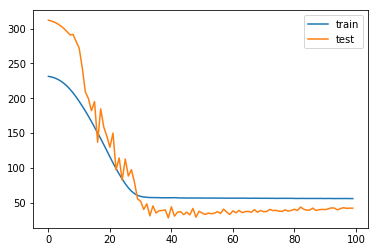

In [46]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [43]:
lstm_neurons = 10
dense_neurons = 150
dropout_rate = 0.25
layers = 3
num_inputs=X_sent_lstm.shape[1]
num_outputs=oh_y_direction.shape[1]
num_layers=layers
model = Sequential()
model.add(LSTM(lstm_neurons, input_shape=(X_sent_lstm.shape[1], X_sent_lstm.shape[2]),return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(dense_neurons,activation='sigmoid'))
for hidden_layer in range(num_layers-1):
    model.add(Dense(dense_neurons, activation='sigmoid'))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Dense(num_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

history = model.fit(train_X_sent_lstm, oh_y_direction_train, epochs=100, batch_size=72, validation_data=(test_X_sent_lstm, oh_y_direction_test), verbose=2, shuffle=False)

Train on 2088 samples, validate on 180 samples
Epoch 1/100
 - 4s - loss: 1.4372 - acc: 0.3697 - val_loss: 1.1752 - val_acc: 0.3778
Epoch 2/100
 - 0s - loss: 0.8220 - acc: 0.6030 - val_loss: 0.6384 - val_acc: 0.5778
Epoch 3/100
 - 0s - loss: 0.6350 - acc: 0.6403 - val_loss: 0.6230 - val_acc: 0.5944
Epoch 4/100
 - 0s - loss: 0.5717 - acc: 0.6489 - val_loss: 0.5587 - val_acc: 0.6389
Epoch 5/100
 - 0s - loss: 0.5247 - acc: 0.6590 - val_loss: 0.8059 - val_acc: 0.5500
Epoch 6/100
 - 0s - loss: 0.5046 - acc: 0.6715 - val_loss: 0.7748 - val_acc: 0.5667
Epoch 7/100
 - 0s - loss: 0.4939 - acc: 0.6748 - val_loss: 0.8921 - val_acc: 0.5611
Epoch 8/100
 - 0s - loss: 0.4866 - acc: 0.6810 - val_loss: 0.8010 - val_acc: 0.6056
Epoch 9/100
 - 0s - loss: 0.4769 - acc: 0.6911 - val_loss: 3.7666 - val_acc: 0.3444
Epoch 10/100
 - 0s - loss: 0.4784 - acc: 0.6964 - val_loss: 1.1945 - val_acc: 0.5556
Epoch 11/100
 - 0s - loss: 0.4725 - acc: 0.6997 - val_loss: 0.8483 - val_acc: 0.6333
Epoch 12/100
 - 0s - loss: 

Epoch 97/100
 - 0s - loss: 0.1541 - acc: 0.9382 - val_loss: 5.8992 - val_acc: 0.4389
Epoch 98/100
 - 0s - loss: 0.1386 - acc: 0.9468 - val_loss: 5.4836 - val_acc: 0.4556
Epoch 99/100
 - 0s - loss: 0.1457 - acc: 0.9425 - val_loss: 4.1704 - val_acc: 0.5444
Epoch 100/100
 - 0s - loss: 0.1368 - acc: 0.9449 - val_loss: 2.6091 - val_acc: 0.6444


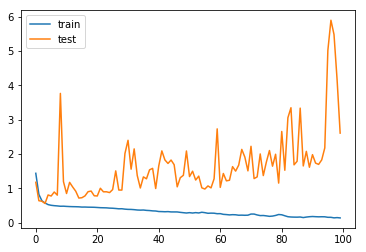

In [44]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Minimal Dataset

In [87]:
lstm_neurons = 50
dense_neurons = 150
dropout_rate = 0.5
layers = 1
num_inputs=train_X_sent_lstm.shape[1]
num_outputs=1
num_layers=layers
model = Sequential()
model.add(LSTM(lstm_neurons, input_shape=(X_sent_lstm.shape[1], X_sent_lstm.shape[2]),return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(dense_neurons,activation='sigmoid'))
for hidden_layer in range(num_layers-1):
    model.add(Dense(dense_neurons, activation='sigmoid'))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())
model.add(Dense(num_outputs))
model.compile(loss='mae',optimizer='adam',metrics=['mape'])
    
history = model.fit(train_X_sent_lstm, train_y_close, epochs=1000, batch_size=72, validation_data=(test_X_sent_lstm, test_y_close), verbose=2, shuffle=False)

Train on 2088 samples, validate on 180 samples
Epoch 1/1000
 - 4s - loss: 231.4513 - mean_absolute_percentage_error: 99.8930 - val_loss: 313.0374 - val_mean_absolute_percentage_error: 99.9547
Epoch 2/1000
 - 0s - loss: 230.6246 - mean_absolute_percentage_error: 99.4737 - val_loss: 312.1378 - val_mean_absolute_percentage_error: 99.6632
Epoch 3/1000
 - 0s - loss: 229.2934 - mean_absolute_percentage_error: 98.7833 - val_loss: 310.6635 - val_mean_absolute_percentage_error: 99.1863
Epoch 4/1000
 - 0s - loss: 227.3681 - mean_absolute_percentage_error: 97.7827 - val_loss: 308.6250 - val_mean_absolute_percentage_error: 98.5272
Epoch 5/1000
 - 0s - loss: 224.8036 - mean_absolute_percentage_error: 96.4175 - val_loss: 305.9282 - val_mean_absolute_percentage_error: 97.6559
Epoch 6/1000
 - 0s - loss: 221.5768 - mean_absolute_percentage_error: 94.7032 - val_loss: 302.6173 - val_mean_absolute_percentage_error: 96.5866
Epoch 7/1000
 - 0s - loss: 217.6784 - mean_absolute_percentage_error: 92.6030 - val

Epoch 58/1000
 - 0s - loss: 56.3577 - mean_absolute_percentage_error: 43.6120 - val_loss: 46.2432 - val_mean_absolute_percentage_error: 14.2499
Epoch 59/1000
 - 0s - loss: 56.3060 - mean_absolute_percentage_error: 43.5997 - val_loss: 47.8846 - val_mean_absolute_percentage_error: 14.8389
Epoch 60/1000
 - 0s - loss: 56.1864 - mean_absolute_percentage_error: 43.5582 - val_loss: 44.1594 - val_mean_absolute_percentage_error: 13.6053
Epoch 61/1000
 - 0s - loss: 56.3082 - mean_absolute_percentage_error: 43.6582 - val_loss: 43.4144 - val_mean_absolute_percentage_error: 13.2675
Epoch 62/1000
 - 0s - loss: 56.2004 - mean_absolute_percentage_error: 43.5791 - val_loss: 42.7409 - val_mean_absolute_percentage_error: 13.0724
Epoch 63/1000
 - 0s - loss: 56.2660 - mean_absolute_percentage_error: 43.6307 - val_loss: 35.0728 - val_mean_absolute_percentage_error: 10.5555
Epoch 64/1000
 - 0s - loss: 56.1035 - mean_absolute_percentage_error: 43.4455 - val_loss: 45.4930 - val_mean_absolute_percentage_error: 

Epoch 115/1000
 - 0s - loss: 55.6282 - mean_absolute_percentage_error: 43.3579 - val_loss: 48.3199 - val_mean_absolute_percentage_error: 14.7885
Epoch 116/1000
 - 0s - loss: 55.6630 - mean_absolute_percentage_error: 43.3794 - val_loss: 44.9253 - val_mean_absolute_percentage_error: 13.6044
Epoch 117/1000
 - 0s - loss: 55.6057 - mean_absolute_percentage_error: 43.3919 - val_loss: 47.8688 - val_mean_absolute_percentage_error: 14.6141
Epoch 118/1000
 - 0s - loss: 55.6169 - mean_absolute_percentage_error: 43.3866 - val_loss: 46.1372 - val_mean_absolute_percentage_error: 13.9920
Epoch 119/1000
 - 0s - loss: 55.6464 - mean_absolute_percentage_error: 43.3846 - val_loss: 49.8099 - val_mean_absolute_percentage_error: 15.2537
Epoch 120/1000
 - 0s - loss: 55.5370 - mean_absolute_percentage_error: 43.3320 - val_loss: 49.3250 - val_mean_absolute_percentage_error: 15.1177
Epoch 121/1000
 - 0s - loss: 55.5963 - mean_absolute_percentage_error: 43.3880 - val_loss: 49.5903 - val_mean_absolute_percentage_

Epoch 172/1000
 - 0s - loss: 55.5001 - mean_absolute_percentage_error: 43.4433 - val_loss: 49.7269 - val_mean_absolute_percentage_error: 15.0873
Epoch 173/1000
 - 0s - loss: 55.4575 - mean_absolute_percentage_error: 43.3711 - val_loss: 52.8485 - val_mean_absolute_percentage_error: 16.1742
Epoch 174/1000
 - 0s - loss: 55.5053 - mean_absolute_percentage_error: 43.4072 - val_loss: 50.2030 - val_mean_absolute_percentage_error: 15.2515
Epoch 175/1000
 - 0s - loss: 55.4689 - mean_absolute_percentage_error: 43.3841 - val_loss: 55.8405 - val_mean_absolute_percentage_error: 17.2190
Epoch 176/1000
 - 0s - loss: 55.4980 - mean_absolute_percentage_error: 43.4023 - val_loss: 49.7555 - val_mean_absolute_percentage_error: 15.0864
Epoch 177/1000
 - 0s - loss: 55.4767 - mean_absolute_percentage_error: 43.3878 - val_loss: 54.0215 - val_mean_absolute_percentage_error: 16.5942
Epoch 178/1000
 - 0s - loss: 55.4671 - mean_absolute_percentage_error: 43.3876 - val_loss: 49.9778 - val_mean_absolute_percentage_

Epoch 229/1000
 - 0s - loss: 55.4518 - mean_absolute_percentage_error: 43.3927 - val_loss: 47.1062 - val_mean_absolute_percentage_error: 14.2676
Epoch 230/1000
 - 0s - loss: 55.4389 - mean_absolute_percentage_error: 43.3984 - val_loss: 47.5664 - val_mean_absolute_percentage_error: 14.4359
Epoch 231/1000
 - 0s - loss: 55.4312 - mean_absolute_percentage_error: 43.3652 - val_loss: 47.4571 - val_mean_absolute_percentage_error: 14.3976
Epoch 232/1000
 - 0s - loss: 55.4042 - mean_absolute_percentage_error: 43.3542 - val_loss: 49.4231 - val_mean_absolute_percentage_error: 15.1039
Epoch 233/1000
 - 0s - loss: 55.4268 - mean_absolute_percentage_error: 43.3686 - val_loss: 46.1686 - val_mean_absolute_percentage_error: 13.9636
Epoch 234/1000
 - 0s - loss: 55.4250 - mean_absolute_percentage_error: 43.3635 - val_loss: 46.7788 - val_mean_absolute_percentage_error: 14.1784
Epoch 235/1000
 - 0s - loss: 55.4348 - mean_absolute_percentage_error: 43.3627 - val_loss: 48.5774 - val_mean_absolute_percentage_

Epoch 286/1000
 - 0s - loss: 55.3492 - mean_absolute_percentage_error: 43.2915 - val_loss: 49.3699 - val_mean_absolute_percentage_error: 15.0892
Epoch 287/1000
 - 0s - loss: 55.4068 - mean_absolute_percentage_error: 43.3461 - val_loss: 46.8340 - val_mean_absolute_percentage_error: 14.2030
Epoch 288/1000
 - 0s - loss: 55.3875 - mean_absolute_percentage_error: 43.3300 - val_loss: 49.1167 - val_mean_absolute_percentage_error: 15.0050
Epoch 289/1000
 - 0s - loss: 55.3910 - mean_absolute_percentage_error: 43.3345 - val_loss: 51.6502 - val_mean_absolute_percentage_error: 15.8823
Epoch 290/1000
 - 0s - loss: 55.3948 - mean_absolute_percentage_error: 43.3390 - val_loss: 45.5174 - val_mean_absolute_percentage_error: 13.7578
Epoch 291/1000
 - 0s - loss: 55.3520 - mean_absolute_percentage_error: 43.3025 - val_loss: 55.4219 - val_mean_absolute_percentage_error: 17.1926
Epoch 292/1000
 - 0s - loss: 55.4125 - mean_absolute_percentage_error: 43.3728 - val_loss: 44.9488 - val_mean_absolute_percentage_

Epoch 343/1000
 - 0s - loss: 55.3598 - mean_absolute_percentage_error: 43.3132 - val_loss: 49.3995 - val_mean_absolute_percentage_error: 15.1148
Epoch 344/1000
 - 0s - loss: 55.3650 - mean_absolute_percentage_error: 43.3556 - val_loss: 46.7434 - val_mean_absolute_percentage_error: 14.2064
Epoch 345/1000
 - 0s - loss: 55.3719 - mean_absolute_percentage_error: 43.3322 - val_loss: 59.2518 - val_mean_absolute_percentage_error: 18.4465
Epoch 346/1000
 - 0s - loss: 55.3744 - mean_absolute_percentage_error: 43.3582 - val_loss: 44.8498 - val_mean_absolute_percentage_error: 13.5684
Epoch 347/1000
 - 0s - loss: 55.3634 - mean_absolute_percentage_error: 43.3237 - val_loss: 50.7796 - val_mean_absolute_percentage_error: 15.5976
Epoch 348/1000
 - 0s - loss: 55.3800 - mean_absolute_percentage_error: 43.3528 - val_loss: 44.6105 - val_mean_absolute_percentage_error: 13.4672
Epoch 349/1000
 - 0s - loss: 55.3612 - mean_absolute_percentage_error: 43.3093 - val_loss: 48.1901 - val_mean_absolute_percentage_

Epoch 400/1000
 - 0s - loss: 55.3299 - mean_absolute_percentage_error: 43.2823 - val_loss: 52.3284 - val_mean_absolute_percentage_error: 16.1302
Epoch 401/1000
 - 0s - loss: 55.3364 - mean_absolute_percentage_error: 43.2866 - val_loss: 44.2989 - val_mean_absolute_percentage_error: 13.3734
Epoch 402/1000
 - 0s - loss: 55.3573 - mean_absolute_percentage_error: 43.2842 - val_loss: 49.6600 - val_mean_absolute_percentage_error: 15.2037
Epoch 403/1000
 - 0s - loss: 55.3056 - mean_absolute_percentage_error: 43.2643 - val_loss: 48.0102 - val_mean_absolute_percentage_error: 14.6322
Epoch 404/1000
 - 0s - loss: 55.3421 - mean_absolute_percentage_error: 43.2787 - val_loss: 51.4391 - val_mean_absolute_percentage_error: 15.8324
Epoch 405/1000
 - 0s - loss: 55.3741 - mean_absolute_percentage_error: 43.3326 - val_loss: 46.4372 - val_mean_absolute_percentage_error: 14.1034
Epoch 406/1000
 - 0s - loss: 55.3221 - mean_absolute_percentage_error: 43.2780 - val_loss: 48.7480 - val_mean_absolute_percentage_

Epoch 457/1000
 - 0s - loss: 55.2914 - mean_absolute_percentage_error: 43.2970 - val_loss: 46.3657 - val_mean_absolute_percentage_error: 14.0462
Epoch 458/1000
 - 0s - loss: 55.3082 - mean_absolute_percentage_error: 43.2794 - val_loss: 53.7086 - val_mean_absolute_percentage_error: 16.5216
Epoch 459/1000
 - 0s - loss: 55.3143 - mean_absolute_percentage_error: 43.3099 - val_loss: 46.3586 - val_mean_absolute_percentage_error: 14.0374
Epoch 460/1000
 - 0s - loss: 55.3058 - mean_absolute_percentage_error: 43.2795 - val_loss: 51.0155 - val_mean_absolute_percentage_error: 15.6413
Epoch 461/1000
 - 0s - loss: 55.3173 - mean_absolute_percentage_error: 43.3095 - val_loss: 47.0148 - val_mean_absolute_percentage_error: 14.2626
Epoch 462/1000
 - 0s - loss: 55.3554 - mean_absolute_percentage_error: 43.3136 - val_loss: 51.7781 - val_mean_absolute_percentage_error: 15.8940
Epoch 463/1000
 - 0s - loss: 55.3580 - mean_absolute_percentage_error: 43.3282 - val_loss: 46.5955 - val_mean_absolute_percentage_

Epoch 514/1000
 - 0s - loss: 55.2931 - mean_absolute_percentage_error: 43.2703 - val_loss: 56.3270 - val_mean_absolute_percentage_error: 17.4119
Epoch 515/1000
 - 0s - loss: 55.3207 - mean_absolute_percentage_error: 43.3295 - val_loss: 50.9571 - val_mean_absolute_percentage_error: 15.5584
Epoch 516/1000
 - 0s - loss: 55.2746 - mean_absolute_percentage_error: 43.2658 - val_loss: 55.8533 - val_mean_absolute_percentage_error: 17.2391
Epoch 517/1000
 - 0s - loss: 55.3166 - mean_absolute_percentage_error: 43.3233 - val_loss: 47.3433 - val_mean_absolute_percentage_error: 14.3328
Epoch 518/1000
 - 0s - loss: 55.3364 - mean_absolute_percentage_error: 43.3222 - val_loss: 55.3811 - val_mean_absolute_percentage_error: 17.0375
Epoch 519/1000
 - 0s - loss: 55.3083 - mean_absolute_percentage_error: 43.3141 - val_loss: 47.7832 - val_mean_absolute_percentage_error: 14.4724
Epoch 520/1000
 - 0s - loss: 55.3421 - mean_absolute_percentage_error: 43.3041 - val_loss: 59.2685 - val_mean_absolute_percentage_

Epoch 571/1000
 - 0s - loss: 55.3089 - mean_absolute_percentage_error: 43.2685 - val_loss: 51.5026 - val_mean_absolute_percentage_error: 15.7324
Epoch 572/1000
 - 0s - loss: 55.2872 - mean_absolute_percentage_error: 43.2997 - val_loss: 52.2916 - val_mean_absolute_percentage_error: 16.0109
Epoch 573/1000
 - 0s - loss: 55.2899 - mean_absolute_percentage_error: 43.2891 - val_loss: 51.0166 - val_mean_absolute_percentage_error: 15.5743
Epoch 574/1000
 - 0s - loss: 55.3091 - mean_absolute_percentage_error: 43.2730 - val_loss: 53.6557 - val_mean_absolute_percentage_error: 16.4657
Epoch 575/1000
 - 0s - loss: 55.2933 - mean_absolute_percentage_error: 43.2775 - val_loss: 51.8361 - val_mean_absolute_percentage_error: 15.8494
Epoch 576/1000
 - 0s - loss: 55.2660 - mean_absolute_percentage_error: 43.2540 - val_loss: 51.6826 - val_mean_absolute_percentage_error: 15.8065
Epoch 577/1000
 - 0s - loss: 55.2966 - mean_absolute_percentage_error: 43.3077 - val_loss: 49.7955 - val_mean_absolute_percentage_

Epoch 628/1000
 - 0s - loss: 55.3044 - mean_absolute_percentage_error: 43.3159 - val_loss: 50.5149 - val_mean_absolute_percentage_error: 15.4012
Epoch 629/1000
 - 0s - loss: 55.2675 - mean_absolute_percentage_error: 43.2727 - val_loss: 51.5566 - val_mean_absolute_percentage_error: 15.7588
Epoch 630/1000
 - 0s - loss: 55.2782 - mean_absolute_percentage_error: 43.2851 - val_loss: 51.7010 - val_mean_absolute_percentage_error: 15.7978
Epoch 631/1000
 - 0s - loss: 55.2627 - mean_absolute_percentage_error: 43.2726 - val_loss: 50.5862 - val_mean_absolute_percentage_error: 15.4353
Epoch 632/1000
 - 0s - loss: 55.2963 - mean_absolute_percentage_error: 43.2745 - val_loss: 54.8423 - val_mean_absolute_percentage_error: 16.8692
Epoch 633/1000
 - 0s - loss: 55.2848 - mean_absolute_percentage_error: 43.2698 - val_loss: 49.1734 - val_mean_absolute_percentage_error: 14.9663
Epoch 634/1000
 - 0s - loss: 55.3099 - mean_absolute_percentage_error: 43.2702 - val_loss: 52.5816 - val_mean_absolute_percentage_

Epoch 685/1000
 - 0s - loss: 55.3041 - mean_absolute_percentage_error: 43.2999 - val_loss: 55.1131 - val_mean_absolute_percentage_error: 16.9578
Epoch 686/1000
 - 0s - loss: 55.2836 - mean_absolute_percentage_error: 43.2886 - val_loss: 48.0103 - val_mean_absolute_percentage_error: 14.5516
Epoch 687/1000
 - 0s - loss: 55.2745 - mean_absolute_percentage_error: 43.2637 - val_loss: 62.4859 - val_mean_absolute_percentage_error: 19.4211
Epoch 688/1000
 - 0s - loss: 55.2699 - mean_absolute_percentage_error: 43.3039 - val_loss: 48.6623 - val_mean_absolute_percentage_error: 14.7822
Epoch 689/1000
 - 0s - loss: 55.2939 - mean_absolute_percentage_error: 43.2848 - val_loss: 54.3081 - val_mean_absolute_percentage_error: 16.6785
Epoch 690/1000
 - 0s - loss: 55.2747 - mean_absolute_percentage_error: 43.3064 - val_loss: 50.4659 - val_mean_absolute_percentage_error: 15.4054
Epoch 691/1000
 - 0s - loss: 55.2848 - mean_absolute_percentage_error: 43.2995 - val_loss: 47.8021 - val_mean_absolute_percentage_

Epoch 742/1000
 - 0s - loss: 55.2546 - mean_absolute_percentage_error: 43.2487 - val_loss: 53.2957 - val_mean_absolute_percentage_error: 16.3822
Epoch 743/1000
 - 0s - loss: 55.2809 - mean_absolute_percentage_error: 43.2797 - val_loss: 50.7890 - val_mean_absolute_percentage_error: 15.5271
Epoch 744/1000
 - 0s - loss: 55.2570 - mean_absolute_percentage_error: 43.2400 - val_loss: 60.3350 - val_mean_absolute_percentage_error: 18.6815
Epoch 745/1000
 - 0s - loss: 55.2584 - mean_absolute_percentage_error: 43.2610 - val_loss: 48.7385 - val_mean_absolute_percentage_error: 14.8340
Epoch 746/1000
 - 0s - loss: 55.2856 - mean_absolute_percentage_error: 43.2670 - val_loss: 54.9322 - val_mean_absolute_percentage_error: 16.9566
Epoch 747/1000
 - 0s - loss: 55.2874 - mean_absolute_percentage_error: 43.3143 - val_loss: 47.0980 - val_mean_absolute_percentage_error: 14.2819
Epoch 748/1000
 - 0s - loss: 55.2618 - mean_absolute_percentage_error: 43.2975 - val_loss: 49.7154 - val_mean_absolute_percentage_

Epoch 799/1000
 - 0s - loss: 55.2598 - mean_absolute_percentage_error: 43.2810 - val_loss: 52.2897 - val_mean_absolute_percentage_error: 16.0075
Epoch 800/1000
 - 0s - loss: 55.2431 - mean_absolute_percentage_error: 43.2744 - val_loss: 49.8947 - val_mean_absolute_percentage_error: 15.1998
Epoch 801/1000
 - 0s - loss: 55.2614 - mean_absolute_percentage_error: 43.2644 - val_loss: 53.5898 - val_mean_absolute_percentage_error: 16.4325
Epoch 802/1000
 - 0s - loss: 55.2889 - mean_absolute_percentage_error: 43.2897 - val_loss: 51.9344 - val_mean_absolute_percentage_error: 15.8899
Epoch 803/1000
 - 0s - loss: 55.2409 - mean_absolute_percentage_error: 43.2708 - val_loss: 55.2192 - val_mean_absolute_percentage_error: 17.0053
Epoch 804/1000
 - 0s - loss: 55.2974 - mean_absolute_percentage_error: 43.3008 - val_loss: 50.8445 - val_mean_absolute_percentage_error: 15.5249
Epoch 805/1000
 - 0s - loss: 55.2624 - mean_absolute_percentage_error: 43.2498 - val_loss: 54.8199 - val_mean_absolute_percentage_

Epoch 856/1000
 - 0s - loss: 55.2632 - mean_absolute_percentage_error: 43.2483 - val_loss: 56.4325 - val_mean_absolute_percentage_error: 17.3933
Epoch 857/1000
 - 0s - loss: 55.2744 - mean_absolute_percentage_error: 43.2771 - val_loss: 50.0941 - val_mean_absolute_percentage_error: 15.2785
Epoch 858/1000
 - 0s - loss: 55.2477 - mean_absolute_percentage_error: 43.2586 - val_loss: 56.1611 - val_mean_absolute_percentage_error: 17.3025
Epoch 859/1000
 - 0s - loss: 55.2574 - mean_absolute_percentage_error: 43.2829 - val_loss: 53.3342 - val_mean_absolute_percentage_error: 16.3424
Epoch 860/1000
 - 0s - loss: 55.2458 - mean_absolute_percentage_error: 43.2630 - val_loss: 52.0017 - val_mean_absolute_percentage_error: 15.9325
Epoch 861/1000
 - 0s - loss: 55.2448 - mean_absolute_percentage_error: 43.2673 - val_loss: 49.7193 - val_mean_absolute_percentage_error: 15.1719
Epoch 862/1000
 - 0s - loss: 55.2709 - mean_absolute_percentage_error: 43.2798 - val_loss: 46.9956 - val_mean_absolute_percentage_

Epoch 913/1000
 - 0s - loss: 55.2605 - mean_absolute_percentage_error: 43.2480 - val_loss: 54.2106 - val_mean_absolute_percentage_error: 16.6532
Epoch 914/1000
 - 0s - loss: 55.2710 - mean_absolute_percentage_error: 43.2588 - val_loss: 53.2507 - val_mean_absolute_percentage_error: 16.3192
Epoch 915/1000
 - 0s - loss: 55.2487 - mean_absolute_percentage_error: 43.2297 - val_loss: 53.8075 - val_mean_absolute_percentage_error: 16.5365
Epoch 916/1000
 - 0s - loss: 55.2623 - mean_absolute_percentage_error: 43.2567 - val_loss: 53.7121 - val_mean_absolute_percentage_error: 16.5016
Epoch 917/1000
 - 0s - loss: 55.2391 - mean_absolute_percentage_error: 43.2574 - val_loss: 53.1982 - val_mean_absolute_percentage_error: 16.3202
Epoch 918/1000
 - 0s - loss: 55.2616 - mean_absolute_percentage_error: 43.2556 - val_loss: 56.3839 - val_mean_absolute_percentage_error: 17.3656
Epoch 919/1000
 - 0s - loss: 55.2491 - mean_absolute_percentage_error: 43.2585 - val_loss: 50.1145 - val_mean_absolute_percentage_

Epoch 970/1000
 - 0s - loss: 55.2743 - mean_absolute_percentage_error: 43.2603 - val_loss: 51.7785 - val_mean_absolute_percentage_error: 15.8371
Epoch 971/1000
 - 0s - loss: 55.2496 - mean_absolute_percentage_error: 43.2525 - val_loss: 57.9499 - val_mean_absolute_percentage_error: 17.9015
Epoch 972/1000
 - 0s - loss: 55.2562 - mean_absolute_percentage_error: 43.2464 - val_loss: 50.5388 - val_mean_absolute_percentage_error: 15.4396
Epoch 973/1000
 - 0s - loss: 55.2475 - mean_absolute_percentage_error: 43.2590 - val_loss: 51.5243 - val_mean_absolute_percentage_error: 15.7755
Epoch 974/1000
 - 0s - loss: 55.2603 - mean_absolute_percentage_error: 43.2567 - val_loss: 53.9826 - val_mean_absolute_percentage_error: 16.5754
Epoch 975/1000
 - 0s - loss: 55.2721 - mean_absolute_percentage_error: 43.2652 - val_loss: 50.9197 - val_mean_absolute_percentage_error: 15.5494
Epoch 976/1000
 - 0s - loss: 55.2492 - mean_absolute_percentage_error: 43.2547 - val_loss: 55.8994 - val_mean_absolute_percentage_

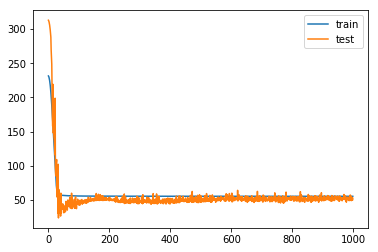

In [88]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Minimaler Dataset

In [196]:
sorted(list(dataframe.columns))

['Adj_Close_tm1',
 'Adj_Close_tm2',
 'Adj_High_tm1',
 'Adj_High_tm2',
 'Adj_Low_tm1',
 'Adj_Low_tm2',
 'Adj_Open_tm1',
 'Adj_Open_tm2',
 'Adj_Volume_tm1',
 'Adj_Volume_tm2',
 'Direction_tm1',
 'Direction_tm2',
 'is_Fri',
 'is_Mon',
 'is_Sat',
 'is_Sun',
 'is_Thu',
 'is_Tue',
 'is_Wed',
 'is_holiday',
 'is_holiday_tm1',
 'is_holiday_tm2',
 'news_buzz_tm1',
 'news_buzz_tm2',
 'news_volume_tm1',
 'news_volume_tm2',
 'sentiment_high_tm1',
 'sentiment_high_tm2',
 'sentiment_low_tm1',
 'sentiment_low_tm2',
 'sentiment_tm1',
 'sentiment_tm2']

In [191]:
test_X_sent_lstm.shape

(180, 1, 32)

In [180]:
lstm_neurons = 50
dense_neurons = 150
dropout_rate = 0.5
layers = 1
num_inputs=train_X_sent_lstm.shape[1]
num_outputs=1
num_layers=layers
model = Sequential()
model.add(LSTM(lstm_neurons, input_shape=(X_sent_lstm.shape[1], X_sent_lstm.shape[2]),return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(dense_neurons,activation='sigmoid'))
for hidden_layer in range(num_layers-1):
    model.add(Dense(dense_neurons, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(num_outputs))
model.compile(loss='mae',optimizer='adam',metrics=['mape'])
    
history = model.fit(train_X_sent_lstm, train_y_close, epochs=250, batch_size=72, 
                    validation_data=(test_X_sent_lstm, test_y_close), verbose=2, shuffle=False)

Train on 2088 samples, validate on 180 samples
Epoch 1/250
 - 6s - loss: 231.4669 - mean_absolute_percentage_error: 99.9230 - val_loss: 312.0198 - val_mean_absolute_percentage_error: 99.6378
Epoch 2/250
 - 0s - loss: 230.6827 - mean_absolute_percentage_error: 99.5302 - val_loss: 310.7382 - val_mean_absolute_percentage_error: 99.2263
Epoch 3/250
 - 0s - loss: 229.3909 - mean_absolute_percentage_error: 98.8707 - val_loss: 308.8869 - val_mean_absolute_percentage_error: 98.6321
Epoch 4/250
 - 0s - loss: 227.4974 - mean_absolute_percentage_error: 97.8881 - val_loss: 306.2987 - val_mean_absolute_percentage_error: 97.7996
Epoch 5/250
 - 0s - loss: 224.9589 - mean_absolute_percentage_error: 96.5541 - val_loss: 303.3931 - val_mean_absolute_percentage_error: 96.8656
Epoch 6/250
 - 0s - loss: 221.7526 - mean_absolute_percentage_error: 94.8552 - val_loss: 299.5867 - val_mean_absolute_percentage_error: 95.6399
Epoch 7/250
 - 0s - loss: 217.8686 - mean_absolute_percentage_error: 92.7847 - val_loss: 

Epoch 58/250
 - 0s - loss: 55.6142 - mean_absolute_percentage_error: 43.4494 - val_loss: 17.2052 - val_mean_absolute_percentage_error: 5.2310
Epoch 59/250
 - 0s - loss: 55.5567 - mean_absolute_percentage_error: 43.3214 - val_loss: 22.2103 - val_mean_absolute_percentage_error: 6.7781
Epoch 60/250
 - 0s - loss: 55.4629 - mean_absolute_percentage_error: 43.2901 - val_loss: 23.9005 - val_mean_absolute_percentage_error: 7.2964
Epoch 61/250
 - 0s - loss: 55.4669 - mean_absolute_percentage_error: 43.3253 - val_loss: 18.2259 - val_mean_absolute_percentage_error: 5.5418
Epoch 62/250
 - 0s - loss: 55.4168 - mean_absolute_percentage_error: 43.2619 - val_loss: 23.9664 - val_mean_absolute_percentage_error: 7.3245
Epoch 63/250
 - 0s - loss: 55.4392 - mean_absolute_percentage_error: 43.3323 - val_loss: 17.2647 - val_mean_absolute_percentage_error: 5.2590
Epoch 64/250
 - 0s - loss: 55.4508 - mean_absolute_percentage_error: 43.2545 - val_loss: 26.4045 - val_mean_absolute_percentage_error: 8.1014
Epoch 

Epoch 116/250
 - 0s - loss: 55.3747 - mean_absolute_percentage_error: 43.2952 - val_loss: 21.7988 - val_mean_absolute_percentage_error: 6.6716
Epoch 117/250
 - 0s - loss: 55.2783 - mean_absolute_percentage_error: 43.2399 - val_loss: 24.5482 - val_mean_absolute_percentage_error: 7.5490
Epoch 118/250
 - 0s - loss: 55.3164 - mean_absolute_percentage_error: 43.3130 - val_loss: 20.0318 - val_mean_absolute_percentage_error: 6.1142
Epoch 119/250
 - 0s - loss: 55.3451 - mean_absolute_percentage_error: 43.2612 - val_loss: 17.4527 - val_mean_absolute_percentage_error: 5.3297
Epoch 120/250
 - 0s - loss: 55.3148 - mean_absolute_percentage_error: 43.2367 - val_loss: 23.0138 - val_mean_absolute_percentage_error: 7.0459
Epoch 121/250
 - 0s - loss: 55.3349 - mean_absolute_percentage_error: 43.2607 - val_loss: 25.9572 - val_mean_absolute_percentage_error: 7.9656
Epoch 122/250
 - 0s - loss: 55.3509 - mean_absolute_percentage_error: 43.3137 - val_loss: 19.0152 - val_mean_absolute_percentage_error: 5.7936

Epoch 174/250
 - 0s - loss: 55.2756 - mean_absolute_percentage_error: 43.2446 - val_loss: 24.0568 - val_mean_absolute_percentage_error: 7.3151
Epoch 175/250
 - 0s - loss: 55.2622 - mean_absolute_percentage_error: 43.2569 - val_loss: 28.6980 - val_mean_absolute_percentage_error: 8.7953
Epoch 176/250
 - 0s - loss: 55.2789 - mean_absolute_percentage_error: 43.2942 - val_loss: 23.0039 - val_mean_absolute_percentage_error: 6.9963
Epoch 177/250
 - 0s - loss: 55.2596 - mean_absolute_percentage_error: 43.2342 - val_loss: 25.4980 - val_mean_absolute_percentage_error: 7.7672
Epoch 178/250
 - 0s - loss: 55.2471 - mean_absolute_percentage_error: 43.2284 - val_loss: 29.4513 - val_mean_absolute_percentage_error: 9.0349
Epoch 179/250
 - 0s - loss: 55.2902 - mean_absolute_percentage_error: 43.3008 - val_loss: 21.7188 - val_mean_absolute_percentage_error: 6.5983
Epoch 180/250
 - 0s - loss: 55.2500 - mean_absolute_percentage_error: 43.2136 - val_loss: 25.3415 - val_mean_absolute_percentage_error: 7.7262

Epoch 232/250
 - 0s - loss: 55.2342 - mean_absolute_percentage_error: 43.2678 - val_loss: 24.9061 - val_mean_absolute_percentage_error: 7.5464
Epoch 233/250
 - 0s - loss: 55.2502 - mean_absolute_percentage_error: 43.1989 - val_loss: 32.6683 - val_mean_absolute_percentage_error: 9.9800
Epoch 234/250
 - 0s - loss: 55.2567 - mean_absolute_percentage_error: 43.2891 - val_loss: 31.1620 - val_mean_absolute_percentage_error: 9.4752
Epoch 235/250
 - 0s - loss: 55.2204 - mean_absolute_percentage_error: 43.2583 - val_loss: 26.1366 - val_mean_absolute_percentage_error: 7.9455
Epoch 236/250
 - 0s - loss: 55.3080 - mean_absolute_percentage_error: 43.2662 - val_loss: 31.5635 - val_mean_absolute_percentage_error: 9.6036
Epoch 237/250
 - 0s - loss: 55.2122 - mean_absolute_percentage_error: 43.2583 - val_loss: 25.3202 - val_mean_absolute_percentage_error: 7.6580
Epoch 238/250
 - 0s - loss: 55.2609 - mean_absolute_percentage_error: 43.2473 - val_loss: 34.0957 - val_mean_absolute_percentage_error: 10.405

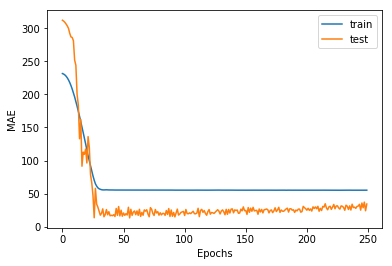

In [190]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [188]:
# make a prediction
test_X = test_X_sent_lstm
scaler = scaler_1
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_close = test_y_close.reshape((len(test_y_close), 1))
inv_y = np.concatenate((test_y_close, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.mean(abs(inv_y - inv_yhat))
print('Test MAE: %.3f' % rmse)

Test MAE: 34.356


# Minimalist Network

In [131]:
np.reshape(train_X_sent_lstm,(train_X_sent_lstm.shape[0],14,train_X_sent_lstm[2]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [172]:
len(dataframe.columns)

32

In [173]:
dataframe.columns

Index(['Adj_Volume_tm1', 'is_Thu', 'news_buzz_tm1', 'Adj_Open_tm2', 'is_Mon',
       'Adj_Open_tm1', 'is_Tue', 'Adj_Low_tm2', 'Direction_tm1',
       'Adj_Volume_tm2', 'Adj_Close_tm2', 'is_Sat', 'news_volume_tm1',
       'Adj_High_tm2', 'sentiment_tm1', 'is_holiday_tm1', 'sentiment_tm2',
       'Direction_tm2', 'is_Sun', 'is_holiday_tm2', 'news_volume_tm2',
       'is_Wed', 'sentiment_high_tm1', 'Adj_Close_tm1', 'Adj_Low_tm1',
       'is_holiday', 'sentiment_high_tm2', 'sentiment_low_tm2',
       'news_buzz_tm2', 'sentiment_low_tm1', 'Adj_High_tm1', 'is_Fri'],
      dtype='object')

In [165]:
train_X_sent_lstm.shape

(2088, 1, 200)

In [164]:
train_X_sent.shape

(2088, 200)

In [174]:
lstm_neurons = 20
dense_neurons = 10
dropout_rate = 0.5
layers = 1
num_inputs=train_X_sent_lstm.shape[1]
num_outputs=1
num_layers=layers
model = Sequential()
# model.add(LSTM(lstm_neurons, input_shape=(X_sent_lstm.shape[1], X_sent_lstm.shape[2]),return_sequences=False))
model.add(Dense(20, input_shape=(X_sent.shape[1],), activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dense(num_outputs))
model.compile(loss='mae',optimizer='adam',metrics=['mape'])

history = model.fit(train_X_sent, train_y_close, epochs=250, batch_size=56, validation_data=(test_X_sent, test_y_close), verbose=2, shuffle=True)

Train on 2088 samples, validate on 180 samples
Epoch 1/250
 - 4s - loss: 231.5954 - mean_absolute_percentage_error: 99.9102 - val_loss: 313.4939 - val_mean_absolute_percentage_error: 100.1027
Epoch 2/250
 - 0s - loss: 231.2646 - mean_absolute_percentage_error: 99.7208 - val_loss: 313.0637 - val_mean_absolute_percentage_error: 99.9640
Epoch 3/250
 - 0s - loss: 230.8133 - mean_absolute_percentage_error: 99.4694 - val_loss: 312.5855 - val_mean_absolute_percentage_error: 99.8098
Epoch 4/250
 - 0s - loss: 230.2264 - mean_absolute_percentage_error: 99.1536 - val_loss: 311.3966 - val_mean_absolute_percentage_error: 99.4276
Epoch 5/250
 - 0s - loss: 229.4977 - mean_absolute_percentage_error: 98.7938 - val_loss: 310.1824 - val_mean_absolute_percentage_error: 99.0377
Epoch 6/250
 - 0s - loss: 228.6240 - mean_absolute_percentage_error: 98.3536 - val_loss: 308.8475 - val_mean_absolute_percentage_error: 98.6091
Epoch 7/250
 - 0s - loss: 227.6040 - mean_absolute_percentage_error: 97.8046 - val_loss:

Epoch 58/250
 - 0s - loss: 14.2362 - mean_absolute_percentage_error: 7.9744 - val_loss: 58.3195 - val_mean_absolute_percentage_error: 18.5801
Epoch 59/250
 - 0s - loss: 13.1017 - mean_absolute_percentage_error: 7.6377 - val_loss: 46.6753 - val_mean_absolute_percentage_error: 14.8807
Epoch 60/250
 - 0s - loss: 11.5711 - mean_absolute_percentage_error: 7.3562 - val_loss: 51.5131 - val_mean_absolute_percentage_error: 16.4348
Epoch 61/250
 - 0s - loss: 10.0995 - mean_absolute_percentage_error: 5.8741 - val_loss: 49.1271 - val_mean_absolute_percentage_error: 15.6408
Epoch 62/250
 - 0s - loss: 10.8074 - mean_absolute_percentage_error: 6.4447 - val_loss: 44.3914 - val_mean_absolute_percentage_error: 14.1495
Epoch 63/250
 - 0s - loss: 11.2292 - mean_absolute_percentage_error: 6.9432 - val_loss: 29.3132 - val_mean_absolute_percentage_error: 9.2908
Epoch 64/250
 - 0s - loss: 10.2465 - mean_absolute_percentage_error: 6.0796 - val_loss: 20.2493 - val_mean_absolute_percentage_error: 6.4010
Epoch 65

Epoch 117/250
 - 0s - loss: 9.3659 - mean_absolute_percentage_error: 5.4022 - val_loss: 8.1245 - val_mean_absolute_percentage_error: 2.5628
Epoch 118/250
 - 0s - loss: 9.0119 - mean_absolute_percentage_error: 5.3654 - val_loss: 6.6387 - val_mean_absolute_percentage_error: 2.1268
Epoch 119/250
 - 0s - loss: 8.5989 - mean_absolute_percentage_error: 5.0432 - val_loss: 11.0406 - val_mean_absolute_percentage_error: 3.4849
Epoch 120/250
 - 0s - loss: 11.1305 - mean_absolute_percentage_error: 6.7967 - val_loss: 7.2511 - val_mean_absolute_percentage_error: 2.2985
Epoch 121/250
 - 0s - loss: 9.1564 - mean_absolute_percentage_error: 5.3338 - val_loss: 6.5521 - val_mean_absolute_percentage_error: 2.1083
Epoch 122/250
 - 0s - loss: 8.8082 - mean_absolute_percentage_error: 5.3516 - val_loss: 7.2693 - val_mean_absolute_percentage_error: 2.3778
Epoch 123/250
 - 0s - loss: 7.9926 - mean_absolute_percentage_error: 4.5275 - val_loss: 6.3507 - val_mean_absolute_percentage_error: 2.0450
Epoch 124/250
 - 0

Epoch 176/250
 - 0s - loss: 9.3352 - mean_absolute_percentage_error: 5.6998 - val_loss: 8.5175 - val_mean_absolute_percentage_error: 2.6929
Epoch 177/250
 - 0s - loss: 9.7675 - mean_absolute_percentage_error: 5.6360 - val_loss: 7.1526 - val_mean_absolute_percentage_error: 2.3269
Epoch 178/250
 - 0s - loss: 10.4557 - mean_absolute_percentage_error: 6.3900 - val_loss: 6.2727 - val_mean_absolute_percentage_error: 2.0191
Epoch 179/250
 - 0s - loss: 10.3426 - mean_absolute_percentage_error: 5.9980 - val_loss: 9.8613 - val_mean_absolute_percentage_error: 3.1127
Epoch 180/250
 - 0s - loss: 8.9352 - mean_absolute_percentage_error: 5.4975 - val_loss: 9.1545 - val_mean_absolute_percentage_error: 2.8902
Epoch 181/250
 - 0s - loss: 9.8425 - mean_absolute_percentage_error: 5.7663 - val_loss: 6.0771 - val_mean_absolute_percentage_error: 1.9404
Epoch 182/250
 - 0s - loss: 8.6133 - mean_absolute_percentage_error: 5.3212 - val_loss: 10.1333 - val_mean_absolute_percentage_error: 3.2984
Epoch 183/250
 - 

Epoch 235/250
 - 0s - loss: 11.6338 - mean_absolute_percentage_error: 6.9863 - val_loss: 6.0194 - val_mean_absolute_percentage_error: 1.9362
Epoch 236/250
 - 0s - loss: 10.1515 - mean_absolute_percentage_error: 5.9761 - val_loss: 6.9742 - val_mean_absolute_percentage_error: 2.2101
Epoch 237/250
 - 0s - loss: 10.2910 - mean_absolute_percentage_error: 5.9127 - val_loss: 5.8475 - val_mean_absolute_percentage_error: 1.8658
Epoch 238/250
 - 0s - loss: 9.4991 - mean_absolute_percentage_error: 5.5500 - val_loss: 6.6108 - val_mean_absolute_percentage_error: 2.0977
Epoch 239/250
 - 0s - loss: 9.7135 - mean_absolute_percentage_error: 5.4530 - val_loss: 8.9535 - val_mean_absolute_percentage_error: 2.9120
Epoch 240/250
 - 0s - loss: 9.4114 - mean_absolute_percentage_error: 5.3931 - val_loss: 8.8846 - val_mean_absolute_percentage_error: 2.8109
Epoch 241/250
 - 0s - loss: 9.5567 - mean_absolute_percentage_error: 5.2960 - val_loss: 9.8413 - val_mean_absolute_percentage_error: 3.2061
Epoch 242/250
 - 

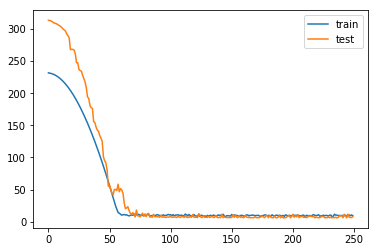

In [175]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### LSTM no Grid Search

In [ ]:
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(train_X_sent_lstm.shape[1], train_X_sent_lstm.shape[2]),return_sequences=False))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Dropout(.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mape','mae'])
# fit network
history = model.fit(train_X_sent_lstm, train_y_close, epochs=50, batch_size=72, validation_data=(test_X_sent_lstm, test_y_close), verbose=2, shuffle=False)

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# plot history
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_close = test_y_close.reshape((len(test_y_close), 1))
inv_y = np.concatenate((test_y_close, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
rs_y_direction_train = train_y_direction.reshape(len(train_y_direction),1)
rs_y_direction_test = test_y_direction.reshape(len(test_y_direction),1)
enc.fit(rs_y_direction_train)
oh_y_direction_train = enc.transform(rs_y_direction_train).toarray()
enc.fit(rs_y_direction_test)
oh_y_direction_test = enc.transform(rs_y_direction_test).toarray()

In [ ]:
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(.1))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(20, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(.4))
model.add(Dense(5))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
# fit network
history = model.fit(train_X, oh_y_direction_train, epochs=500, batch_size=72, validation_data=(test_X, oh_y_direction_test), verbose=2, shuffle=False)

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# plot history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_close = test_y_close.reshape((len(test_y_close), 1))
inv_y = np.concatenate((test_y_close, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)